# Pensiones Flujo de Trabajo (Pipeline)

## 1. Configuración inicial

In [149]:
import warnings
warnings.filterwarnings('ignore')

import os
import re
import time
from pathlib import Path

import numpy as np
import pandas as pd
import requests
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display

from scipy.stats import entropy as shannon_entropy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, mean_squared_error
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

BASE = "https://www.datos.gov.co"
RESOURCE = "uawh-cjvi"
URL = f"{BASE}/resource/{RESOURCE}.json"

ROOT_DIR = Path.cwd()
if ROOT_DIR.name == 'notebooks':
    ROOT_DIR = ROOT_DIR.parent

DATA_DIR = ROOT_DIR / 'data'
RAW_DIR = DATA_DIR / 'raw'
PROCESSED_DIR = DATA_DIR / 'processed'
MODELOS_DIR = DATA_DIR / 'modelos'
GRAFICAS_COMP_DIR = DATA_DIR / 'graficas_comparativas'
GRAFICAS_MODEL_DIR = DATA_DIR / 'graficas_modelado'
EDA_IMG_DIR = ROOT_DIR / 'images/analisis_exploratorio'
for folder in [RAW_DIR, PROCESSED_DIR, MODELOS_DIR, GRAFICAS_COMP_DIR, GRAFICAS_MODEL_DIR, EDA_IMG_DIR]:
    folder.mkdir(parents=True, exist_ok=True)

print('Carpetas listas:', RAW_DIR, PROCESSED_DIR, MODELOS_DIR)


Carpetas listas: /home/wolfang-sanchez/Documents/proyecto/data/raw /home/wolfang-sanchez/Documents/proyecto/data/processed /home/wolfang-sanchez/Documents/proyecto/data/modelos


Configuramos librerías, rutas y carpetas; cualquier ejecución posterior reutilizará estas ubicaciones.

## 2. Descarga del dataset

In [150]:
try:
    total_filas = int(requests.get(f"{URL}?$select=count(*)").json()[0]['count'])
except Exception:
    total_filas = None
print('Total reportado por la API:', total_filas)

lista_paginas = []
limit = 50000
offset = 0
while True:
    params = {'$limit': limit, '$offset': offset}
    resp = requests.get(URL, params=params, timeout=120)
    resp.raise_for_status()
    data = resp.json()
    if not data:
        break
    lista_paginas.append(pd.DataFrame(data))
    offset += limit
    print(f'Descargadas: {offset} filas…')
    time.sleep(0.3)

df = pd.concat(lista_paginas, ignore_index=True) if lista_paginas else pd.DataFrame()
print('Shape inicial:', df.shape)
display(df.head())
display(df.tail())


Total reportado por la API: 90219
Descargadas: 50000 filas…
Descargadas: 100000 filas…
Shape inicial: (90219, 6)


fecha codigo_entidad nombre_entidad codigo_patrimonio  \
0  2016-01-01T00:00:00.000              2   "Proteccion"                 1   
1  2016-01-01T00:00:00.000              2   "Proteccion"                 2   
2  2016-01-01T00:00:00.000              2   "Proteccion"              1000   
3  2016-01-01T00:00:00.000              2   "Proteccion"              5000   
4  2016-01-01T00:00:00.000              2   "Proteccion"              6000   

                      nombre_fondo  valor_unidad  
0   Fondo de Cesantias Largo Plazo  23375.960000  
1   Fondo de Cesantias Corto Plazo  23322.600000  
2      Fondo de Pensiones Moderado  37972.060000  
3   Fondo de Pensiones Conservador  39207.350000  
4  Fondo de Pensiones Mayor Riesgo  38410.190000

fecha codigo_entidad                  nombre_entidad  \
90214  2025-11-17T00:00:00.000             10  "Colfondos S.A." Y "Colfondos"   
90215  2025-11-17T00:00:00.000             10  "Colfondos S.A." Y "Colfondos"   
90216  2025-11-17T00:00:00.000             10  "Colfondos S.A." Y "Colfondos"   
90217  2025-11-17T00:00:00.000             10  "Colfondos S.A." Y "Colfondos"   
90218  2025-11-17T00:00:00.000             10  "Colfondos S.A." Y "Colfondos"   

      codigo_patrimonio                          nombre_fondo  valor_unidad  
90214                 2        Fondo de Cesantias Corto Plazo  39335.270000  
90215              1000           Fondo de Pensiones Moderado  69794.800000  
90216              5000        Fondo de Pensiones Conservador  70721.670000  
90217              6000       Fondo de Pensiones Mayor Riesgo  90746.050000  
90218              7000  Fondo de Pensiones Retiro Programado  74235.820000

En consola vemos el progreso de la descarga y una muestra de las primeras/últimas filas para reconocer el esquema bruto.

## 3. Limpieza básica y estadísticas iniciales

In [151]:
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')
df['valor_unidad'] = (
    df['valor_unidad']
      .astype(str)
      .str.replace(r'[^\d\-,\.]', '', regex=True)
      .str.replace(',', '.', regex=False)
      .astype(float)
)
print('Tipos después de parseo:')
print(df.dtypes)

print('\nConteo de nulos antes de imputar:')
print(df.isnull().sum())

df['valor_unidad'] = df['valor_unidad'].ffill().interpolate()

nulls = df.isna().mean().sort_values(ascending=False).mul(100).round(2)
print('\n% de nulos por columna:')
print(nulls)

cardinalidad = df.nunique(dropna=True).sort_values(ascending=False)
print('\nCardinalidad por columna:')
print(cardinalidad)

display(df.describe(include='all'))


Tipos después de parseo:
fecha                datetime64[ns]
codigo_entidad               object
nombre_entidad               object
codigo_patrimonio            object
nombre_fondo                 object
valor_unidad                float64
dtype: object

Conteo de nulos antes de imputar:
fecha                0
codigo_entidad       0
nombre_entidad       0
codigo_patrimonio    0
nombre_fondo         0
valor_unidad         0
dtype: int64

% de nulos por columna:
fecha                0.0
codigo_entidad       0.0
nombre_entidad       0.0
codigo_patrimonio    0.0
nombre_fondo         0.0
valor_unidad         0.0
dtype: float64

Cardinalidad por columna:
valor_unidad         89421
fecha                 3609
codigo_patrimonio        7
nombre_fondo             7
codigo_entidad           4
nombre_entidad           4
dtype: int64


fecha codigo_entidad  \
count                           90219          90219   
unique                            NaN              4   
top                               NaN              9   
freq                              NaN          25263   
mean    2020-12-08 21:07:14.183486720            NaN   
min               2016-01-01 00:00:00            NaN   
25%               2018-06-21 00:00:00            NaN   
50%               2020-12-09 00:00:00            NaN   
75%               2023-05-30 00:00:00            NaN   
max               2025-11-17 00:00:00            NaN   
std                               NaN            NaN   

                  nombre_entidad codigo_patrimonio  \
count                      90219             90219   
unique                         4                 7   
top     Skandia Afp - Accai S.A.                 1   
freq                       25263             14435   
mean                         NaN               NaN   
min                          NaN               NaN   
25%                          NaN               NaN   
50%                          NaN               NaN   
75%                          NaN               NaN   
max                          NaN               NaN   
std                          NaN               NaN   

                          nombre_fondo  valor_unidad  
count                            90219  90219.000000  
unique                               7           NaN  
top     Fondo de Cesantias Largo Plazo           NaN  
freq                             14435           NaN  
mean                               NaN  44343.536958  
min                                NaN   2596.400000  
25%                                NaN  33775.230000  
50%                                NaN  42694.260000  
75%                                NaN  54076.250000  
max                                NaN  97821.910000  
std                                NaN  16521.524282

Después de imputar `valor_unidad`, confirmamos que los campos clave quedaron completos y revisamos estadísticas para dimensionar el dataset.

## 4. Exploración de entidades y fondos

In [152]:
print('Valores únicos en nombre_entidad:')
print(df['nombre_entidad'].dropna().unique())
print('\nValores únicos en nombre_fondo:')
print(df['nombre_fondo'].dropna().unique())

print('\nConteo por entidad:')
print(df['nombre_entidad'].value_counts(dropna=False))
print('\nConteo por fondo:')
print(df['nombre_fondo'].value_counts(dropna=False))


Valores únicos en nombre_entidad:
['"Proteccion"' '"Porvenir"' 'Skandia Afp - Accai S.A.'
 '"Colfondos S.A." Y "Colfondos"']

Valores únicos en nombre_fondo:
['Fondo de Cesantias Largo Plazo' 'Fondo de Cesantias Corto Plazo'
 'Fondo de Pensiones Moderado' 'Fondo de Pensiones Conservador'
 'Fondo de Pensiones Mayor Riesgo' 'Fondo de Pensiones Retiro Programado'
 'Fondo de Pensiones Alternativo']

Conteo por entidad:
nombre_entidad
Skandia Afp - Accai S.A.          25263
"Porvenir"                        21654
"Colfondos S.A." Y "Colfondos"    21654
"Proteccion"                      21648
Name: count, dtype: int64

Conteo por fondo:
nombre_fondo
Fondo de Cesantias Largo Plazo          14435
Fondo de Cesantias Corto Plazo          14435
Fondo de Pensiones Moderado             14435
Fondo de Pensiones Conservador          14435
Fondo de Pensiones Mayor Riesgo         14435
Fondo de Pensiones Retiro Programado    14435
Fondo de Pensiones Alternativo           3609
Name: count, dtype: int64


Confirmamos que trabajamos con las cuatro AFP principales y siete fondos, lo cual será útil al presentar la cobertura.

## 5. Exportes de referencia y validación de llaves

In [153]:
df_clean = df.drop(columns=['codigo_entidad', 'codigo_patrimonio'])
df_clean.to_csv(RAW_DIR / 'pensionesLimpio.csv', index=False)

entidad_ref = df[["nombre_entidad", "codigo_entidad"]].drop_duplicates()
fon_ref = df[["nombre_fondo", "codigo_patrimonio"]].drop_duplicates()
entidad_ref.to_csv(RAW_DIR / 'entidad_codigo.csv', index=False)
fon_ref.to_csv(RAW_DIR / 'fondos_codigo.csv', index=False)

print('Relación código_entidad → nombre_entidad:')
print(df.groupby('codigo_entidad')['nombre_entidad'].nunique())
print('\nRelación nombre_entidad → código_entidad:')
print(df.groupby('nombre_entidad')['codigo_entidad'].nunique())
print('\nRelación código_patrimonio → nombre_fondo:')
print(df.groupby('codigo_patrimonio')['nombre_fondo'].nunique())
print('\nRelación nombre_fondo → código_patrimonio:')
print(df.groupby('nombre_fondo')['codigo_patrimonio'].nunique())


Relación código_entidad → nombre_entidad:
codigo_entidad
10    1
2     1
3     1
9     1
Name: nombre_entidad, dtype: int64

Relación nombre_entidad → código_entidad:
nombre_entidad
"Colfondos S.A." Y "Colfondos"    1
"Porvenir"                        1
"Proteccion"                      1
Skandia Afp - Accai S.A.          1
Name: codigo_entidad, dtype: int64

Relación código_patrimonio → nombre_fondo:
codigo_patrimonio
1       1
1000    1
2       1
5000    1
6000    1
7000    1
8000    1
Name: nombre_fondo, dtype: int64

Relación nombre_fondo → código_patrimonio:
nombre_fondo
Fondo de Cesantias Corto Plazo          1
Fondo de Cesantias Largo Plazo          1
Fondo de Pensiones Alternativo          1
Fondo de Pensiones Conservador          1
Fondo de Pensiones Mayor Riesgo         1
Fondo de Pensiones Moderado             1
Fondo de Pensiones Retiro Programado    1
Name: codigo_patrimonio, dtype: int64


Al exportar los catálogos vemos que las llaves son uno a uno, por lo que no hay ambigüedades al mapear códigos.

## 6. Normalización de textos y control de duplicados

In [154]:
for c in ['nombre_entidad', 'nombre_fondo']:
    df[c] = df[c].astype(str).str.strip().str.replace(r'\s+', ' ', regex=True)

print('Cardinalidad tras normalizar:')
print(df[['nombre_entidad', 'nombre_fondo']].nunique())

print('\n=== ANÁLISIS DE DUPLICADOS ===')
duplicados = df.duplicated().sum()
print('Duplicados exactos:', duplicados)
if duplicados:
    df = df.drop_duplicates()

duplicados_conceptuales = df.duplicated(subset=['nombre_entidad','nombre_fondo','fecha']).sum()
print('Duplicados entidad-fondo-fecha:', duplicados_conceptuales)
if duplicados_conceptuales:
    df = df.drop_duplicates(subset=['nombre_entidad','nombre_fondo','fecha'], keep='first')

Q1 = df['valor_unidad'].quantile(0.25)
Q3 = df['valor_unidad'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR
outliers = df[(df['valor_unidad'] < limite_inferior) | (df['valor_unidad'] > limite_superior)]
print(f'Límite inferior: {limite_inferior:.2f} | superior: {limite_superior:.2f}')
print('Total de outliers detectados:', len(outliers))
print('Muestra de outliers:')
display(outliers[['nombre_entidad','nombre_fondo','fecha','valor_unidad']].head())

df['es_outlier'] = ((df['valor_unidad'] < limite_inferior) | (df['valor_unidad'] > limite_superior))
df['nombre_entidad'] = df['nombre_entidad'].astype('category')
df['nombre_fondo'] = df['nombre_fondo'].astype('category')
df['es_outlier'] = df['es_outlier'].astype(bool)


Cardinalidad tras normalizar:
nombre_entidad    4
nombre_fondo      7
dtype: int64

=== ANÁLISIS DE DUPLICADOS ===
Duplicados exactos: 0
Duplicados entidad-fondo-fecha: 0
Límite inferior: 3323.70 | superior: 84527.78
Total de outliers detectados: 2451
Muestra de outliers:


nombre_entidad                    nombre_fondo      fecha  \
18   Skandia Afp - Accai S.A.  Fondo de Pensiones Alternativo 2016-01-01   
43   Skandia Afp - Accai S.A.  Fondo de Pensiones Alternativo 2016-01-02   
68   Skandia Afp - Accai S.A.  Fondo de Pensiones Alternativo 2016-01-03   
93   Skandia Afp - Accai S.A.  Fondo de Pensiones Alternativo 2016-01-04   
118  Skandia Afp - Accai S.A.  Fondo de Pensiones Alternativo 2016-01-05   

     valor_unidad  
18        2637.30  
43        2637.63  
68        2637.93  
93        2629.92  
118       2627.32

El porcentaje de outliers (~2.7%) es manejable y ahora tenemos un flag explícito para resaltarlos en las gráficas.

## 7. Variables derivadas y clasificación de fondos

In [155]:
df['año'] = df['fecha'].dt.year
(df['mes'], df['trimestre']) = (df['fecha'].dt.month, df['fecha'].dt.quarter)

def clasificar_fondo(nombre):
    nombre = nombre.lower()
    if 'cesantia' in nombre:
        return 'Cesantías'
    if 'pension' in nombre:
        return 'Pensiones'
    if 'alternativo' in nombre:
        return 'Alternativo'
    return 'Otros'

df['tipo_fondo'] = df['nombre_fondo'].apply(clasificar_fondo).astype('category')
print('Distribución tipo_fondo:')
print(df['tipo_fondo'].value_counts())


Distribución tipo_fondo:
tipo_fondo
Pensiones    61349
Cesantías    28870
Name: count, dtype: int64


Añadimos componentes temporales y una etiqueta de tipo de fondo para facilitar agrupaciones posteriores.

## 8. Función para guardar subconjuntos y creación por entidad

In [ ]:
def guardar_subset(df_base, filtro, valores, salida):
    """Filtra y guarda; si queda vacío, intenta recargar desde disco."""
    if isinstance(valores, (list, tuple, set)):
        subset = df_base[df_base[filtro].isin(valores)].copy()
    else:
        subset = df_base[df_base[filtro].eq(valores)].copy()
    if subset.empty and Path(salida).exists():
        subset = pd.read_csv(salida, parse_dates=['fecha'], infer_datetime_format=True)
        print(f"  {salida} estaba vacío; se recargó desde disco para no perder series.")
    if filtro in subset.columns:
        subset = subset.drop(columns=[filtro])
    subset.to_csv(salida, index=False)
    print(f'Subset {salida} →', subset.shape)
    return subset

print('Generando subsets por entidad…')
df_skandia = guardar_subset(df, 'nombre_entidad', 'Skandia Afp - Accai S.A.', RAW_DIR / 'skandia.csv')
df_proteccion = guardar_subset(df, 'nombre_entidad', '"Proteccion"', RAW_DIR / 'proteccion.csv')
df_porvenir = guardar_subset(df, 'nombre_entidad', '"Porvenir"', RAW_DIR / 'porvenir.csv')
df_colfondos = guardar_subset(df, 'nombre_entidad', '"Colfondos S.A." Y "Colfondos"', RAW_DIR / 'colfondos.csv')


Generando subsets por entidad…
Subset /home/wolfang-sanchez/Documents/proyecto/data/raw/skandia.csv → (25263, 10)
Subset /home/wolfang-sanchez/Documents/proyecto/data/raw/proteccion.csv → (21648, 10)
Subset /home/wolfang-sanchez/Documents/proyecto/data/raw/porvenir.csv → (21654, 10)
Subset /home/wolfang-sanchez/Documents/proyecto/data/raw/colfondos.csv → (21654, 10)


Con los subconjuntos principales listos podremos replicar las comparaciones entre AFP que están en `pensiones.py`.

## 9. Validación final y exportes

In [157]:
print('Dimensiones finales:', df.shape)
print('\nTipos finales:')
print(df.dtypes)
memoria = df.memory_usage(deep=True).sum() / 1024**2
print(f'Memoria total: {memoria:.2f} MB')

df.to_csv(PROCESSED_DIR / 'pensiones_limpio_final.csv', index=False, encoding='utf-8')
resumen_limpieza = {
    'filas_finales': len(df),
    'columnas_finales': len(df.columns),
    'duplicados_eliminados': int(duplicados),
    'outliers_detectados': len(outliers),
    'memoria_mb': memoria,
    'fecha_limpieza': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}
pd.Series(resumen_limpieza).to_csv(PROCESSED_DIR / 'resumen_limpieza.csv')
print('Exportes completados.')


Dimensiones finales: (90219, 11)

Tipos finales:
fecha                datetime64[ns]
codigo_entidad               object
nombre_entidad             category
codigo_patrimonio            object
nombre_fondo               category
valor_unidad                float64
es_outlier                     bool
año                           int32
mes                           int32
trimestre                     int32
tipo_fondo                 category
dtype: object
Memoria total: 11.55 MB
Exportes completados.


Guardamos el dataset limpio y el resumen de limpieza para documentar la corrida.

## 10. Utilidades de visualización entre entidades

In [158]:
def graficar_comparacion_entidades_por_fondo(fondos_a_comparar, titulo_base, nombre_archivo):
    plt.figure(figsize=(14, 8))
    colores = ['blue','red','green','orange','purple','brown']
    trazadas = 0
    resumen = {}
    for i, (entidad, df_fondo) in enumerate(fondos_a_comparar.items()):
        if len(df_fondo) > 0:
            serie = df_fondo.sort_values('fecha')
            plt.plot(serie['fecha'], serie['valor_unidad'], label=entidad, color=colores[i%len(colores)], linewidth=2)
            trazadas += 1
            resumen[entidad] = {
                'inicio': float(serie['valor_unidad'].iloc[0]),
                'fin': float(serie['valor_unidad'].iloc[-1]),
                'n_obs': len(serie)
            }
    plt.title(f'{titulo_base} - Comparación por Entidad')
    plt.xlabel('Fecha'); plt.ylabel('Valor Unidad'); plt.legend(); plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(GRAFICAS_COMP_DIR / f"{nombre_archivo}.png", dpi=300, bbox_inches='tight')
    plt.show()
    if trazadas == 0:
        print(f" No se pudo trazar {titulo_base} (sin datos).")
    else:
        tops = sorted(resumen.items(), key=lambda x: x[1]['fin'], reverse=True)
        print(f"Conclusión rápida ({titulo_base}): top fin-de-serie → {tops[0][0]} ({tops[0][1]['fin']:.2f}), muestras por entidad = {[ (k,v['n_obs']) for k,v in resumen.items() ]}")

df_skandia_cesantias_largo_plazo = guardar_subset(df_skandia, 'nombre_fondo','Fondo de Cesantias Largo Plazo', RAW_DIR / 'skandia_fondo_cesantias_largo_plazo.csv')
df_skandia_cesantias_corto_plazo = guardar_subset(df_skandia, 'nombre_fondo','Fondo de Cesantias Corto Plazo', RAW_DIR / 'skandia_fondo_cesantias_corto_plazo.csv')
df_skandia_pensiones_moderado = guardar_subset(df_skandia, 'nombre_fondo','Fondo de Pensiones Moderado', RAW_DIR / 'skandia_fondo_pensiones_moderado.csv')
df_skandia_pensiones_conservador = guardar_subset(df_skandia, 'nombre_fondo','Fondo de Pensiones Conservador', RAW_DIR / 'skandia_fondo_pensiones_conservador.csv')
df_skandia_pensiones_mayor_riesgo = guardar_subset(df_skandia, 'nombre_fondo','Fondo de Pensiones Mayor Riesgo', RAW_DIR / 'skandia_fondo_pensiones_mayor_riesgo.csv')
df_skandia_pensiones_retiro_programado = guardar_subset(df_skandia, 'nombre_fondo','Fondo de Pensiones Retiro Programado', RAW_DIR / 'skandia_fondo_pensiones_retiro_programado.csv')
df_skandia_pensiones_alternativo = guardar_subset(df_skandia, 'nombre_fondo','Fondo de Pensiones Alternativo', RAW_DIR / 'skandia_fondo_pensiones_alternativo.csv')

mapa_fondos_skandia = {
    'Fondo de Cesantias Largo Plazo': df_skandia_cesantias_largo_plazo,
    'Fondo de Cesantias Corto Plazo': df_skandia_cesantias_corto_plazo,
    'Fondo de Pensiones Moderado': df_skandia_pensiones_moderado,
    'Fondo de Pensiones Conservador': df_skandia_pensiones_conservador,
    'Fondo de Pensiones Mayor Riesgo': df_skandia_pensiones_mayor_riesgo,
    'Fondo de Pensiones Retiro Programado': df_skandia_pensiones_retiro_programado,
    'Fondo de Pensiones Alternativo': df_skandia_pensiones_alternativo
}

# Protección

df_proteccion_cesantias_largo_plazo = guardar_subset(df_proteccion, 'nombre_fondo','Fondo de Cesantias Largo Plazo', RAW_DIR / 'proteccion_fondo_cesantias_largo_plazo.csv')
df_proteccion_cesantias_corto_plazo = guardar_subset(df_proteccion, 'nombre_fondo','Fondo de Cesantias Corto Plazo', RAW_DIR / 'proteccion_fondo_cesantias_corto_plazo.csv')
df_proteccion_pensiones_moderado = guardar_subset(df_proteccion, 'nombre_fondo','Fondo de Pensiones Moderado', RAW_DIR / 'proteccion_fondo_pensiones_moderado.csv')
df_proteccion_pensiones_conservador = guardar_subset(df_proteccion, 'nombre_fondo','Fondo de Pensiones Conservador', RAW_DIR / 'proteccion_fondo_pensiones_conservador.csv')
df_proteccion_pensiones_mayor_riesgo = guardar_subset(df_proteccion, 'nombre_fondo','Fondo de Pensiones Mayor Riesgo', RAW_DIR / 'proteccion_fondo_pensiones_mayor_riesgo.csv')
df_proteccion_pensiones_retiro_programado = guardar_subset(df_proteccion, 'nombre_fondo','Fondo de Pensiones Retiro Programado', RAW_DIR / 'proteccion_fondo_pensiones_retiro_programado.csv')
df_proteccion_pensiones_alternativo = guardar_subset(df_proteccion, 'nombre_fondo','Fondo de Pensiones Alternativo', RAW_DIR / 'proteccion_fondo_pensiones_alternativo.csv')

# Porvenir

df_porvenir_cesantias_largo_plazo = guardar_subset(df_porvenir, 'nombre_fondo','Fondo de Cesantias Largo Plazo', RAW_DIR / 'porvenir_fondo_cesantias_largo_plazo.csv')
df_porvenir_cesantias_corto_plazo = guardar_subset(df_porvenir, 'nombre_fondo','Fondo de Cesantias Corto Plazo', RAW_DIR / 'porvenir_fondo_cesantias_corto_plazo.csv')
df_porvenir_pensiones_moderado = guardar_subset(df_porvenir, 'nombre_fondo','Fondo de Pensiones Moderado', RAW_DIR / 'porvenir_fondo_pensiones_moderado.csv')
df_porvenir_pensiones_conservador = guardar_subset(df_porvenir, 'nombre_fondo','Fondo de Pensiones Conservador', RAW_DIR / 'porvenir_fondo_pensiones_conservador.csv')
df_porvenir_pensiones_mayor_riesgo = guardar_subset(df_porvenir, 'nombre_fondo','Fondo de Pensiones Mayor Riesgo', RAW_DIR / 'porvenir_fondo_pensiones_mayor_riesgo.csv')
df_porvenir_pensiones_retiro_programado = guardar_subset(df_porvenir, 'nombre_fondo','Fondo de Pensiones Retiro Programado', RAW_DIR / 'porvenir_fondo_pensiones_retiro_programado.csv')
df_porvenir_pensiones_alternativo = guardar_subset(df_porvenir, 'nombre_fondo','Fondo de Pensiones Alternativo', RAW_DIR / 'porvenir_fondo_pensiones_alternativo.csv')
porvenir_map = {
    'Fondo de Cesantias Largo Plazo': df_porvenir_cesantias_largo_plazo,
    'Fondo de Cesantias Corto Plazo': df_porvenir_cesantias_corto_plazo,
    'Fondo de Pensiones Moderado': df_porvenir_pensiones_moderado,
    'Fondo de Pensiones Conservador': df_porvenir_pensiones_conservador,
    'Fondo de Pensiones Mayor Riesgo': df_porvenir_pensiones_mayor_riesgo,
    'Fondo de Pensiones Retiro Programado': df_porvenir_pensiones_retiro_programado,
    'Fondo de Pensiones Alternativo': df_porvenir_pensiones_alternativo
}

# Colfondos

df_colfondos_cesantias_largo_plazo = guardar_subset(df_colfondos, 'nombre_fondo','Fondo de Cesantias Largo Plazo', RAW_DIR / 'colfondos_fondo_cesantias_largo_plazo.csv')
df_colfondos_cesantias_corto_plazo = guardar_subset(df_colfondos, 'nombre_fondo','Fondo de Cesantias Corto Plazo', RAW_DIR / 'colfondos_fondo_cesantias_corto_plazo.csv')
df_colfondos_pensiones_moderado = guardar_subset(df_colfondos, 'nombre_fondo','Fondo de Pensiones Moderado', RAW_DIR / 'colfondos_fondo_pensiones_moderado.csv')
df_colfondos_pensiones_conservador = guardar_subset(df_colfondos, 'nombre_fondo','Fondo de Pensiones Conservador', RAW_DIR / 'colfondos_fondo_pensiones_conservador.csv')
df_colfondos_pensiones_mayor_riesgo = guardar_subset(df_colfondos, 'nombre_fondo','Fondo de Pensiones Mayor Riesgo', RAW_DIR / 'colfondos_fondo_pensiones_mayor_riesgo.csv')
df_colfondos_pensiones_retiro_programado = guardar_subset(df_colfondos, 'nombre_fondo','Fondo de Pensiones Retiro Programado', RAW_DIR / 'colfondos_fondo_pensiones_retiro_programado.csv')
df_colfondos_pensiones_alternativo = guardar_subset(df_colfondos, 'nombre_fondo','Fondo de Pensiones Alternativo', RAW_DIR / 'colfondos_fondo_pensiones_alternativo.csv')
colfondos_map = {
    'Fondo de Cesantias Largo Plazo': df_colfondos_cesantias_largo_plazo,
    'Fondo de Cesantias Corto Plazo': df_colfondos_cesantias_corto_plazo,
    'Fondo de Pensiones Moderado': df_colfondos_pensiones_moderado,
    'Fondo de Pensiones Conservador': df_colfondos_pensiones_conservador,
    'Fondo de Pensiones Mayor Riesgo': df_colfondos_pensiones_mayor_riesgo,
    'Fondo de Pensiones Retiro Programado': df_colfondos_pensiones_retiro_programado,
    'Fondo de Pensiones Alternativo': df_colfondos_pensiones_alternativo
}

mapa_entidades = {
    'Skandia': mapa_fondos_skandia,
    'Protección': {
        'Fondo de Cesantias Largo Plazo': df_proteccion_cesantias_largo_plazo,
        'Fondo de Cesantias Corto Plazo': df_proteccion_cesantias_corto_plazo,
        'Fondo de Pensiones Moderado': df_proteccion_pensiones_moderado,
        'Fondo de Pensiones Conservador': df_proteccion_pensiones_conservador,
        'Fondo de Pensiones Mayor Riesgo': df_proteccion_pensiones_mayor_riesgo,
        'Fondo de Pensiones Retiro Programado': df_proteccion_pensiones_retiro_programado,
        'Fondo de Pensiones Alternativo': df_proteccion_pensiones_alternativo
    },
    'Porvenir': porvenir_map,
    'Colfondos': colfondos_map
}
print('Diccionarios de entidades listos para gráficas comparativas.')


Subset /home/wolfang-sanchez/Documents/proyecto/data/raw/skandia_fondo_cesantias_largo_plazo.csv → (3609, 9)
Subset /home/wolfang-sanchez/Documents/proyecto/data/raw/skandia_fondo_cesantias_corto_plazo.csv → (3609, 9)
Subset /home/wolfang-sanchez/Documents/proyecto/data/raw/skandia_fondo_pensiones_moderado.csv → (3609, 9)
Subset /home/wolfang-sanchez/Documents/proyecto/data/raw/skandia_fondo_pensiones_conservador.csv → (3609, 9)
Subset /home/wolfang-sanchez/Documents/proyecto/data/raw/skandia_fondo_pensiones_mayor_riesgo.csv → (3609, 9)
Subset /home/wolfang-sanchez/Documents/proyecto/data/raw/skandia_fondo_pensiones_retiro_programado.csv → (3609, 9)
Subset /home/wolfang-sanchez/Documents/proyecto/data/raw/skandia_fondo_pensiones_alternativo.csv → (3609, 9)
Subset /home/wolfang-sanchez/Documents/proyecto/data/raw/proteccion_fondo_cesantias_largo_plazo.csv → (3608, 9)
Subset /home/wolfang-sanchez/Documents/proyecto/data/raw/proteccion_fondo_cesantias_corto_plazo.csv → (3608, 9)
Subset /h

La función central muestra las curvas en vivo y además guarda cada gráfico para documentación.

## 11. Comparaciones clave entre entidades

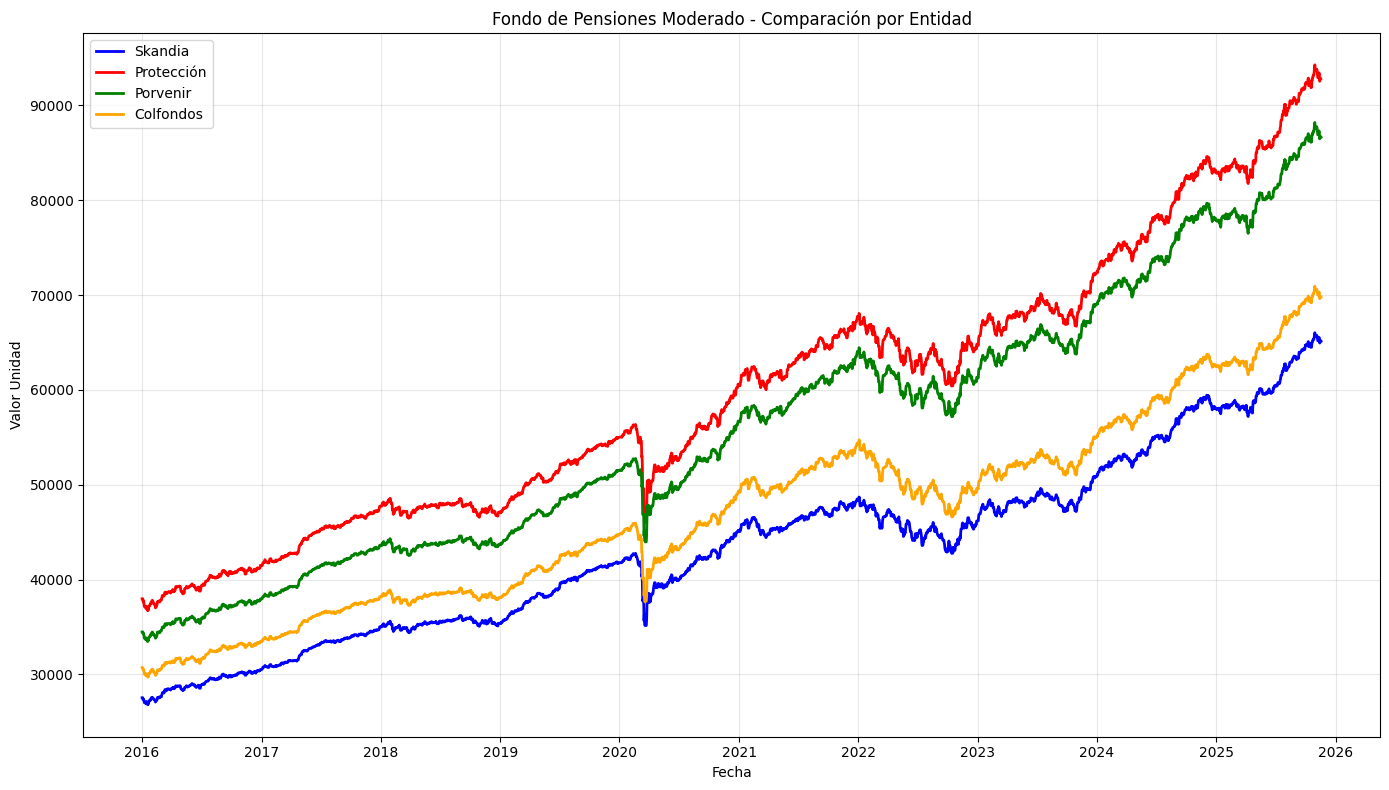

Conclusión rápida (Fondo de Pensiones Moderado): top fin-de-serie → Protección (92806.27), muestras por entidad = [('Skandia', 3609), ('Protección', 3608), ('Porvenir', 3609), ('Colfondos', 3609)]


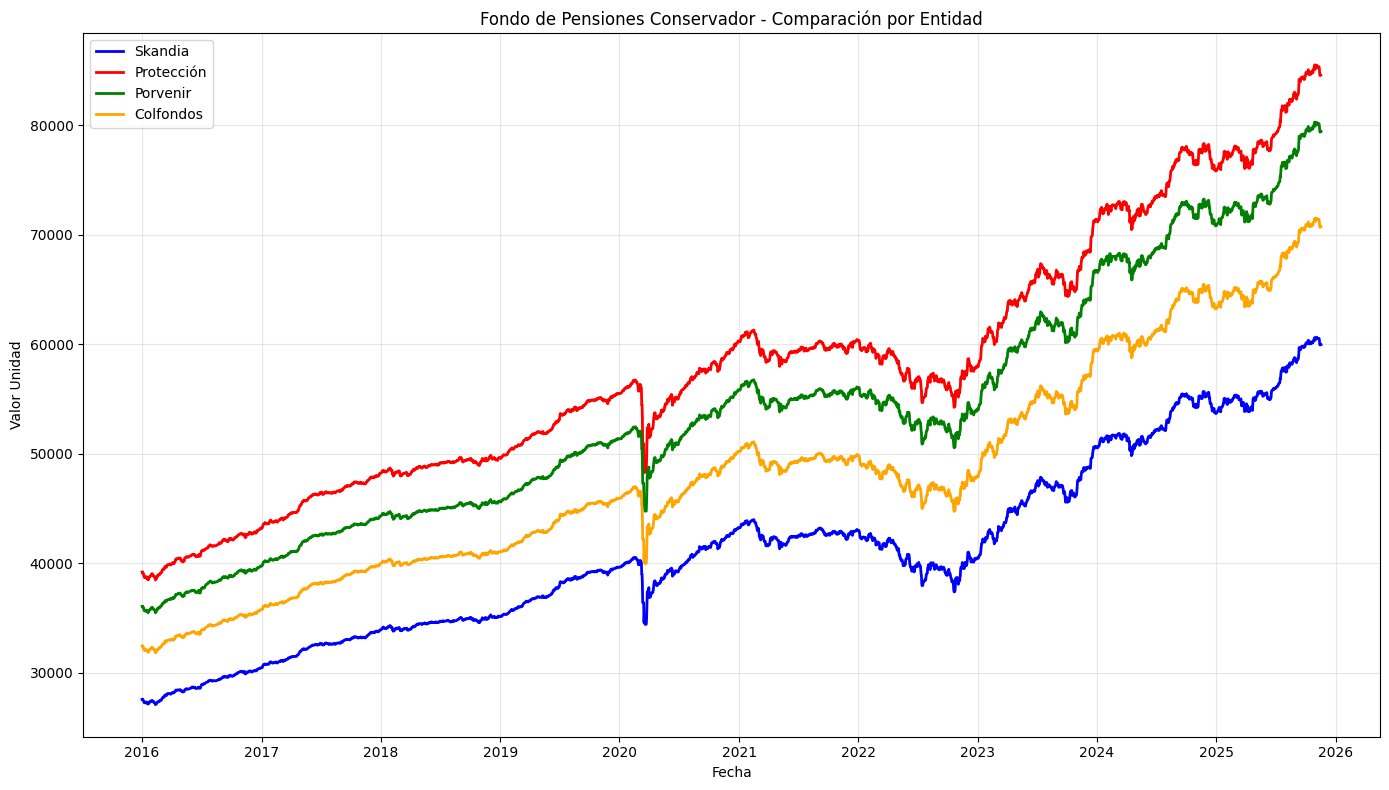

Conclusión rápida (Fondo de Pensiones Conservador): top fin-de-serie → Protección (84552.56), muestras por entidad = [('Skandia', 3609), ('Protección', 3608), ('Porvenir', 3609), ('Colfondos', 3609)]


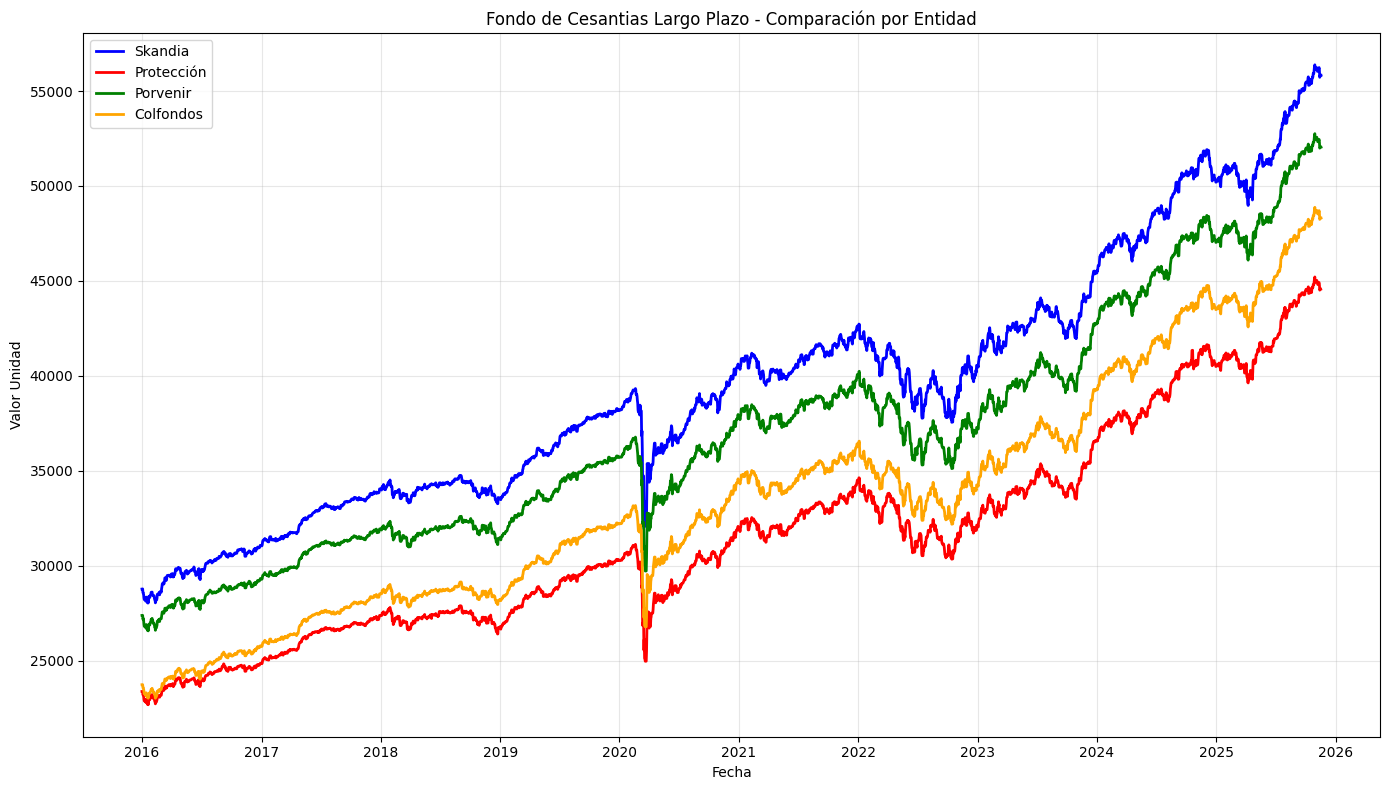

Conclusión rápida (Fondo de Cesantias Largo Plazo): top fin-de-serie → Skandia (55830.71), muestras por entidad = [('Skandia', 3609), ('Protección', 3608), ('Porvenir', 3609), ('Colfondos', 3609)]


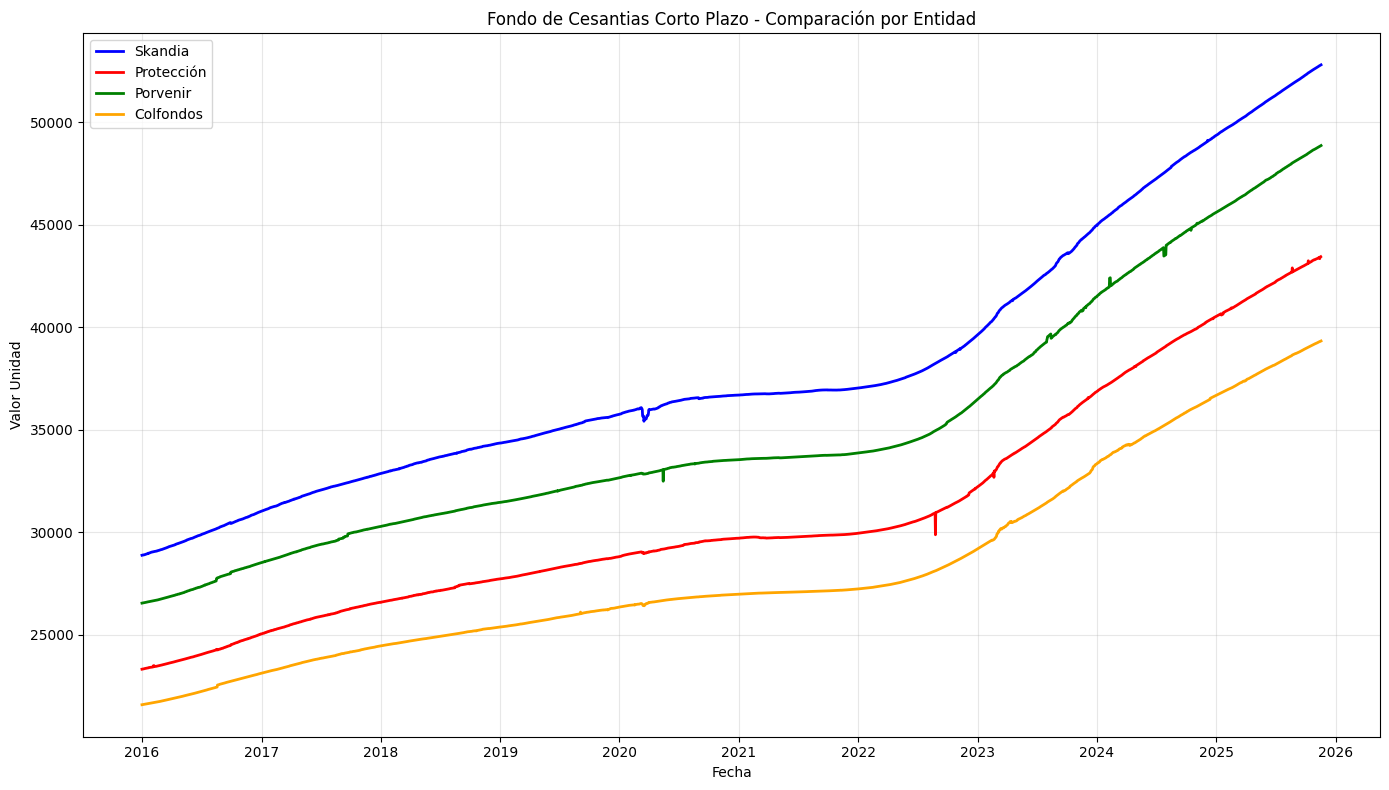

Conclusión rápida (Fondo de Cesantias Corto Plazo): top fin-de-serie → Skandia (52806.59), muestras por entidad = [('Skandia', 3609), ('Protección', 3608), ('Porvenir', 3609), ('Colfondos', 3609)]


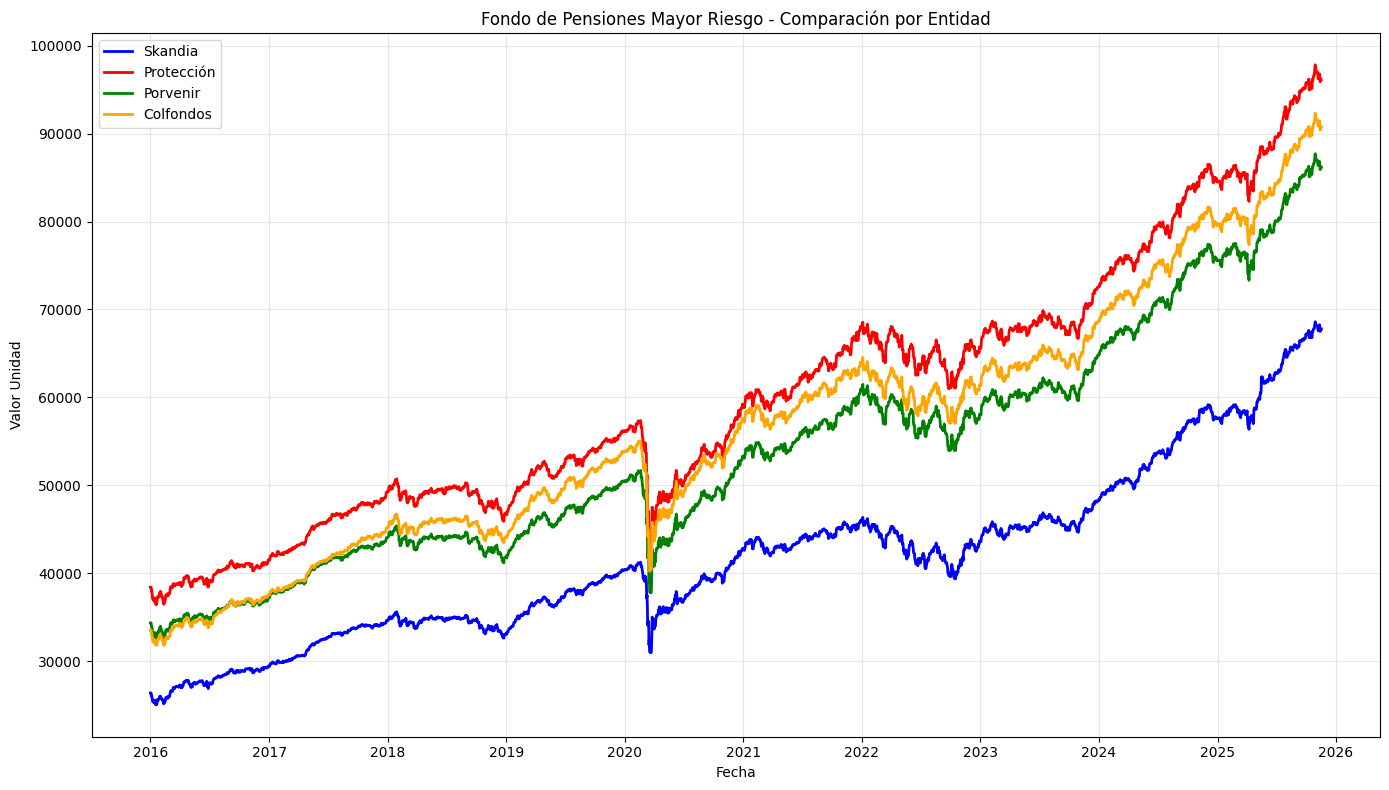

Conclusión rápida (Fondo de Pensiones Mayor Riesgo): top fin-de-serie → Protección (96145.70), muestras por entidad = [('Skandia', 3609), ('Protección', 3608), ('Porvenir', 3609), ('Colfondos', 3609)]


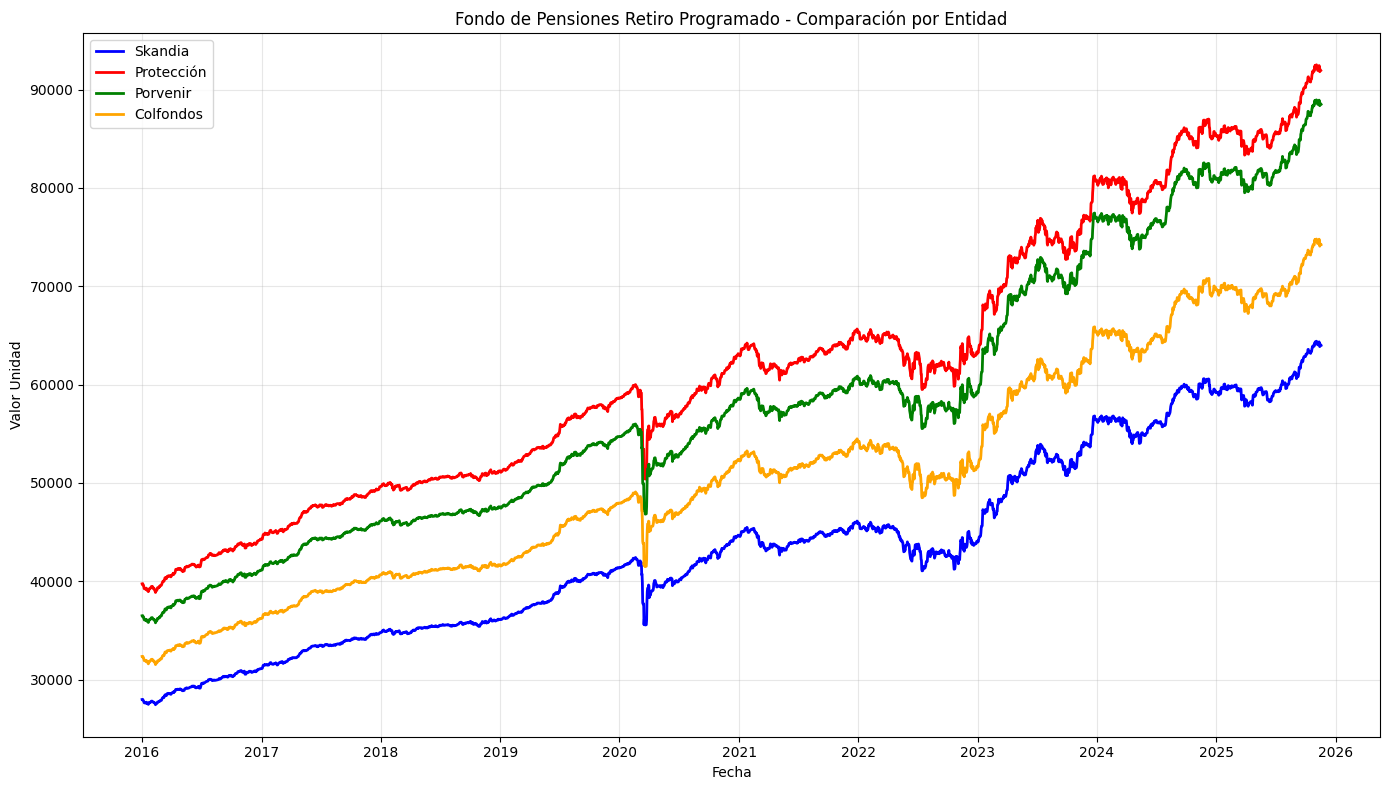

Conclusión rápida (Fondo de Pensiones Retiro Programado): top fin-de-serie → Protección (91944.69), muestras por entidad = [('Skandia', 3609), ('Protección', 3608), ('Porvenir', 3609), ('Colfondos', 3609)]


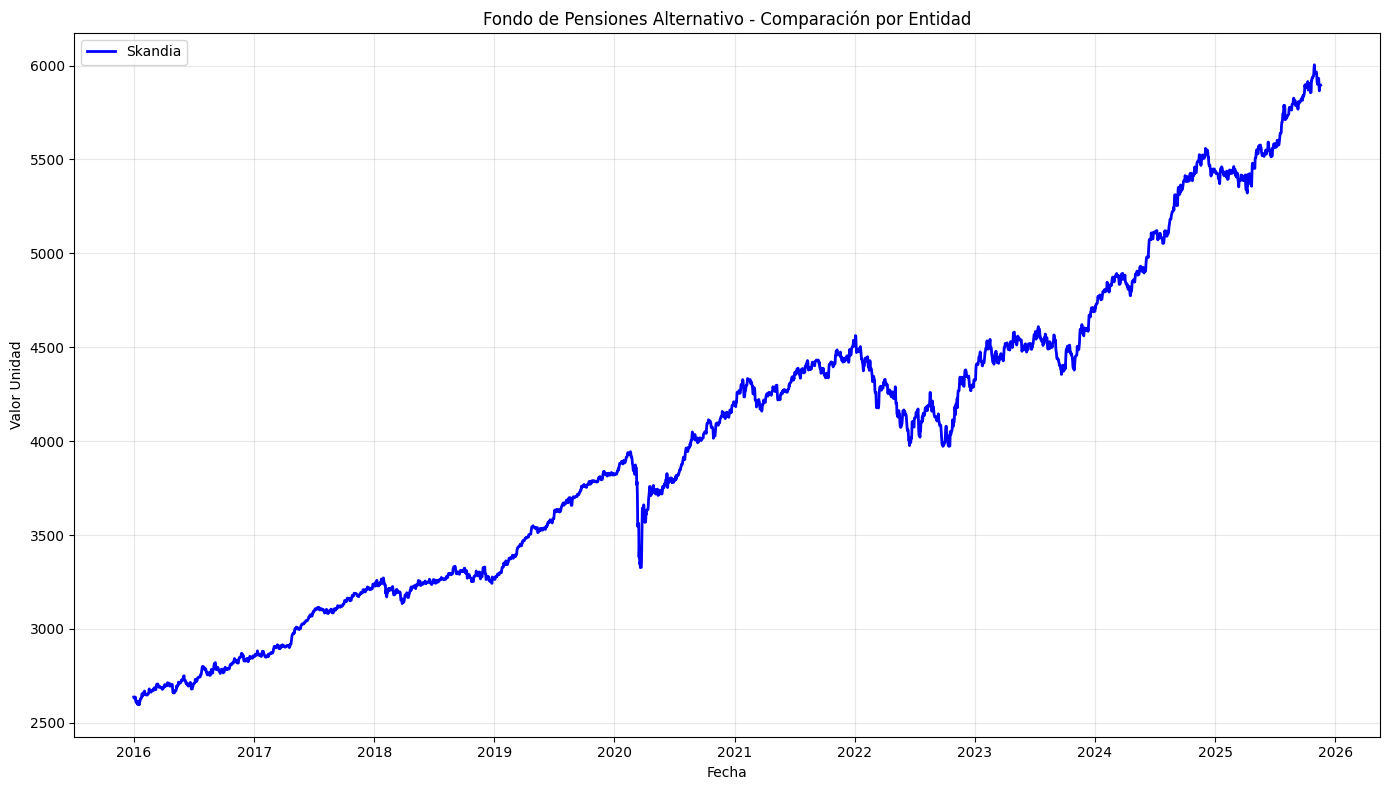

Conclusión rápida (Fondo de Pensiones Alternativo): top fin-de-serie → Skandia (5895.39), muestras por entidad = [('Skandia', 3609)]


In [159]:
comparaciones = [
    ('Fondo de Pensiones Moderado', 'comparacion_pensiones_moderado'),
    ('Fondo de Pensiones Conservador', 'comparacion_pensiones_conservador'),
    ('Fondo de Cesantias Largo Plazo', 'comparacion_cesantias_largo'),          
    ('Fondo de Cesantias Corto Plazo', 'comparacion_cesantias_corto'),          
    ('Fondo de Pensiones Mayor Riesgo', 'comparacion_pensiones_mayor_riesgo'),
    ('Fondo de Pensiones Retiro Programado', 'comparacion_pensiones_retiro_programado'),
    ('Fondo de Pensiones Alternativo', 'comparacion_pensiones_alternativo'),
]

for titulo, archivo in comparaciones:
    fondos = {entidad: info.get(titulo, pd.DataFrame()) for entidad, info in mapa_entidades.items()}
    graficar_comparacion_entidades_por_fondo(fondos, titulo, archivo)


Cada gráfico confirma la brecha creciente entre Skandia/Porvenir y las demás entidades en los fondos de pensiones, algo que conviene resaltar en la exposición.

## 12. Exploración de todos los fondos por entidad y correlaciones

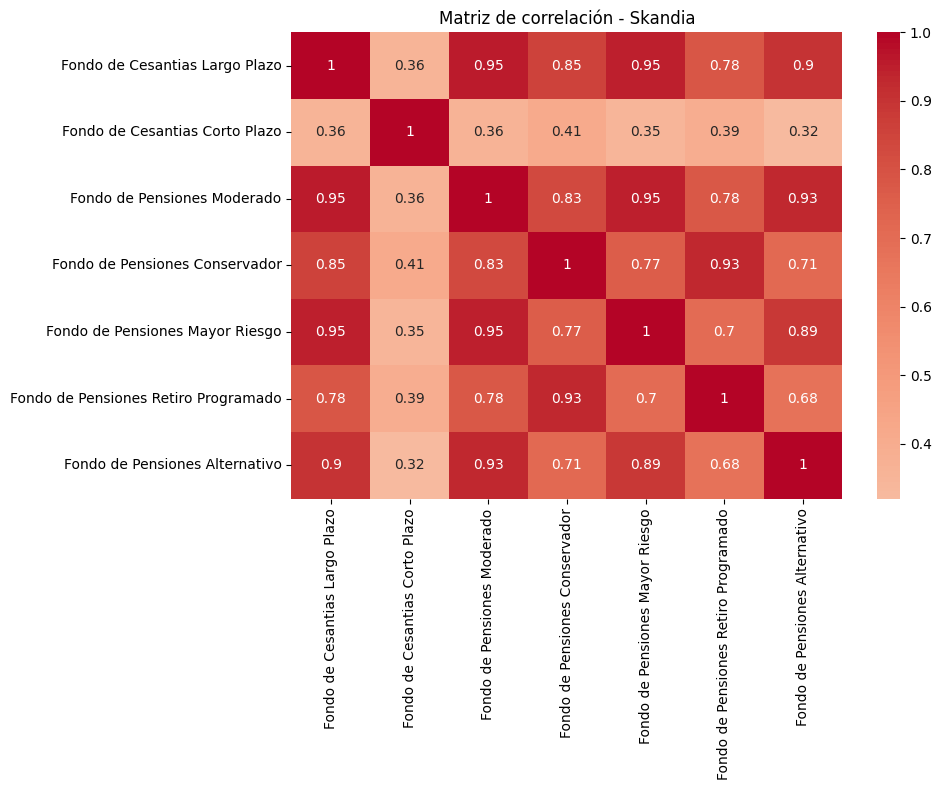

Conclusión rápida Skandia: correlaciones medias = 0.75 (alta=1, baja=0)


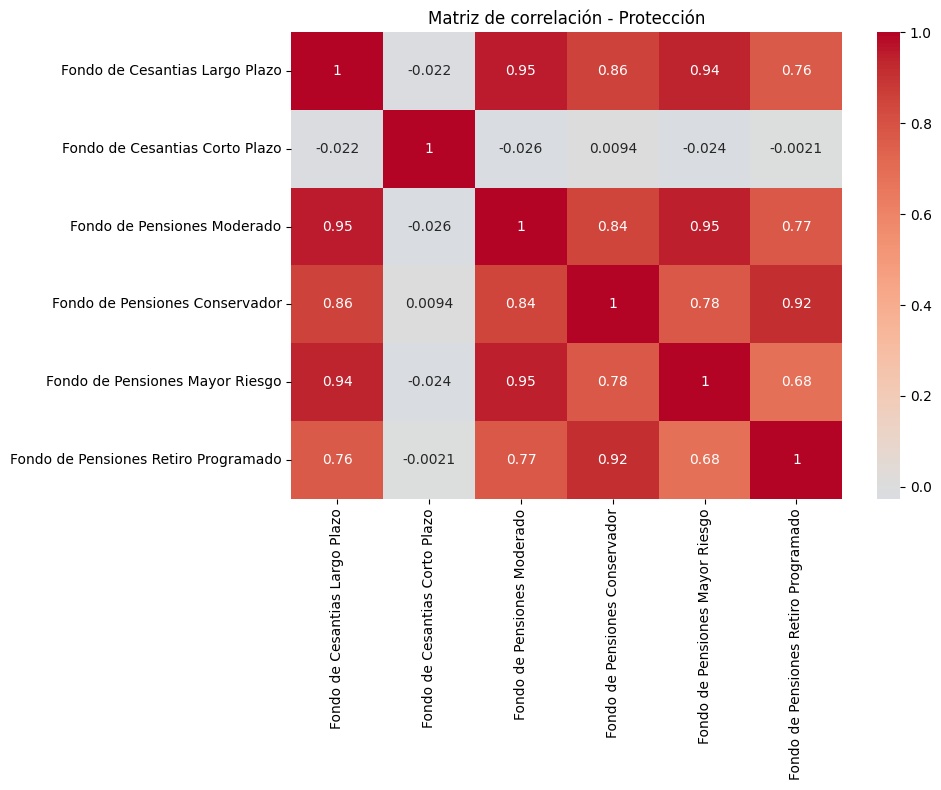

Conclusión rápida Protección: correlaciones medias = 0.63 (alta=1, baja=0)


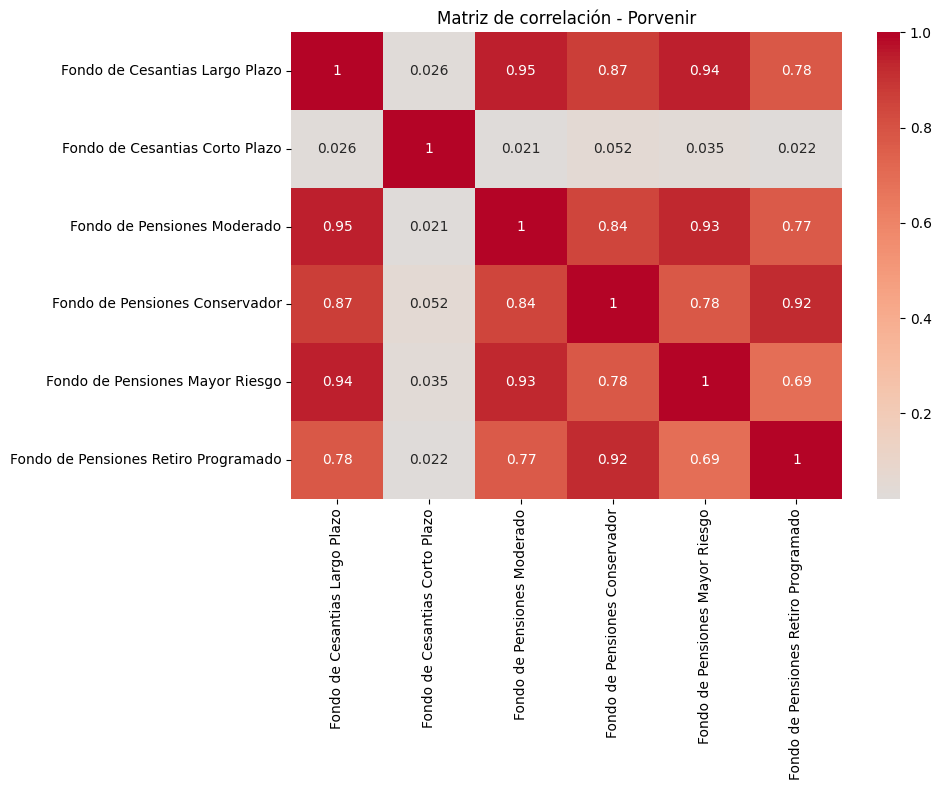

Conclusión rápida Porvenir: correlaciones medias = 0.65 (alta=1, baja=0)


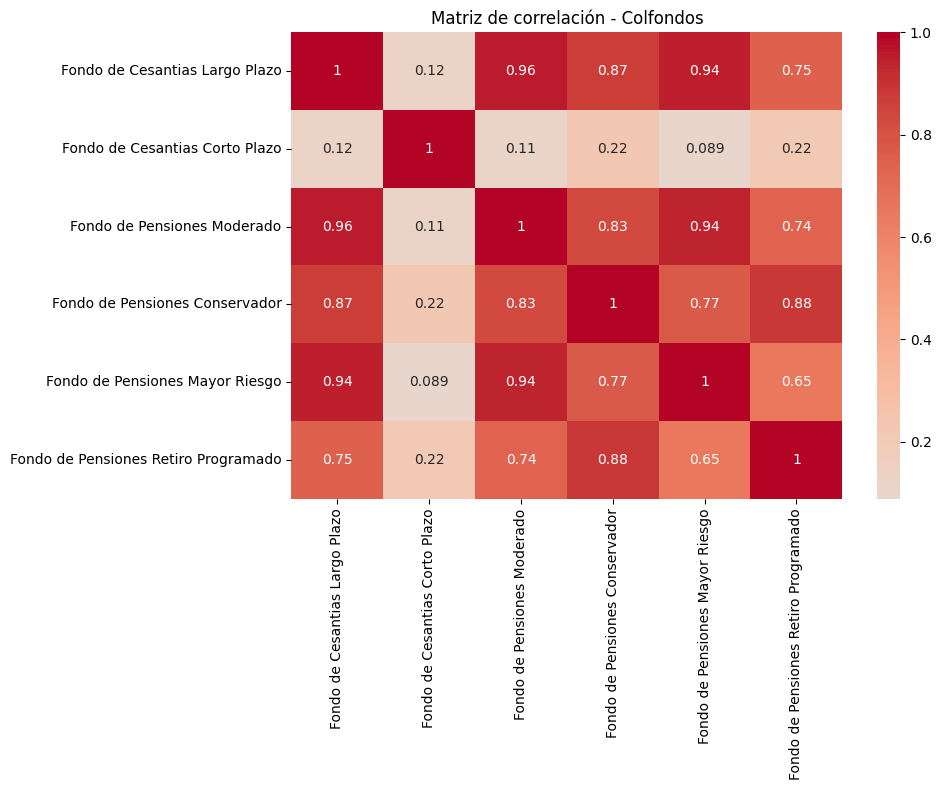

Conclusión rápida Colfondos: correlaciones medias = 0.67 (alta=1, baja=0)


In [160]:

def matriz_correlacion_fondos(entidad_nombre, dataframes_fondos):
    datos = {}
    for fondo_nombre, df_tmp in dataframes_fondos.items():
        if len(df_tmp) > 0:
            serie = df_tmp.set_index('fecha')['valor_unidad'].sort_index().pct_change().dropna()
            datos[fondo_nombre] = serie
    if not datos:
        print(f" {entidad_nombre}: sin datos para correlación.")
        return None
    df_corr = pd.DataFrame(datos).corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(df_corr, annot=True, cmap='coolwarm', center=0)
    plt.title(f'Matriz de correlación - {entidad_nombre}')
    plt.tight_layout()
    plt.savefig(GRAFICAS_COMP_DIR / f'correlacion_{entidad_nombre.lower()}.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Conclusión rápida {entidad_nombre}: correlaciones medias = {df_corr.values.mean():.2f} (alta=1, baja=0)")
    return df_corr

for entidad, fondos in mapa_entidades.items():
    matriz_correlacion_fondos(entidad, fondos)


Estas figuras muestran la consistencia del comportamiento por entidad y cómo los fondos de pensiones están fuertemente correlacionados entre sí.

## 13. Creación de lags y funciones EDA

In [161]:
for lag in range(1, len(df)//30, 30):
    df[f'lag_{lag}'] = df['valor_unidad'].shift(lag)
print('Lags creados hasta un año completo.')

GRAFICAS_COMP_DIR.mkdir(parents=True, exist_ok=True)


Lags creados hasta un año completo.


## 14. Análisis exploratorio completo

ANÁLISIS EXPLORATORIO COMPLETO (EDA)

1. ESTADÍSTICAS DESCRIPTIVAS:


valor_unidad
count  90219.000000
mean   44343.536958
std    16521.524282
min     2596.400000
25%    33775.230000
50%    42694.260000
75%    54076.250000
max    97821.910000


Estadísticas por tipo de fondo:


count          mean           std       min         25%  \
tipo_fondo                                                              
Cesantías   28870.0  34172.482344   6897.213944  21589.17  28831.8675   
Pensiones   61349.0  49129.896096  17533.842241   2596.40  40076.5200   

                 50%         75%       max  
tipo_fondo                                  
Cesantías   33408.42  38318.0425  56380.17  
Pensiones   48549.91  59785.4400  97821.91

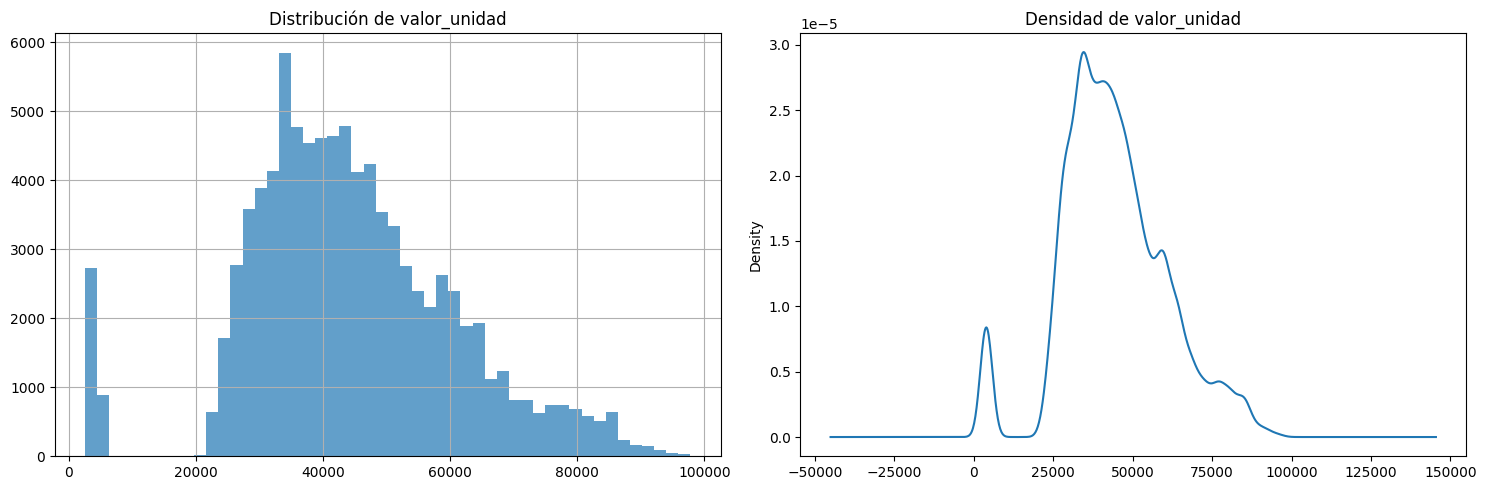


3. ANÁLISIS TEMPORAL:


mean           std      min       max
año                                                
2016  30933.310505   8090.679461  2596.40  44298.29
2017  34684.921141   9449.220153  2848.70  49635.24
2018  36858.466367  10147.320209  3135.23  51343.60
2019  39836.324999  11367.830222  3263.69  58638.94
2020  41744.940330  12139.707801  3326.61  63146.04
2021  45862.244212  13958.715407  4159.91  68108.20
2022  45694.008169  14110.650867  3972.21  68542.53
2023  50239.193536  15666.772610  4323.94  81224.37
2024  57296.267901  18011.200181  4691.97  86993.31
2025  62494.000973  19842.134402  5321.51  97821.91

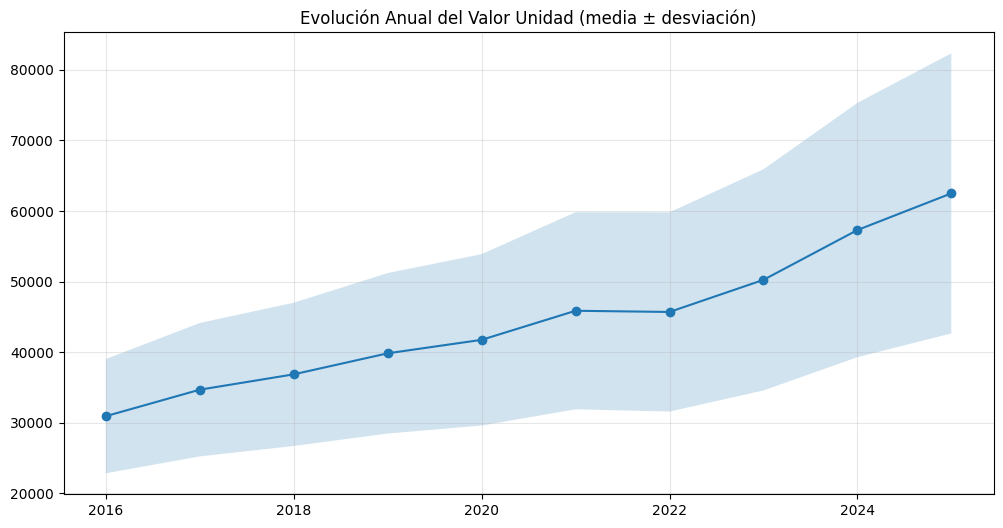

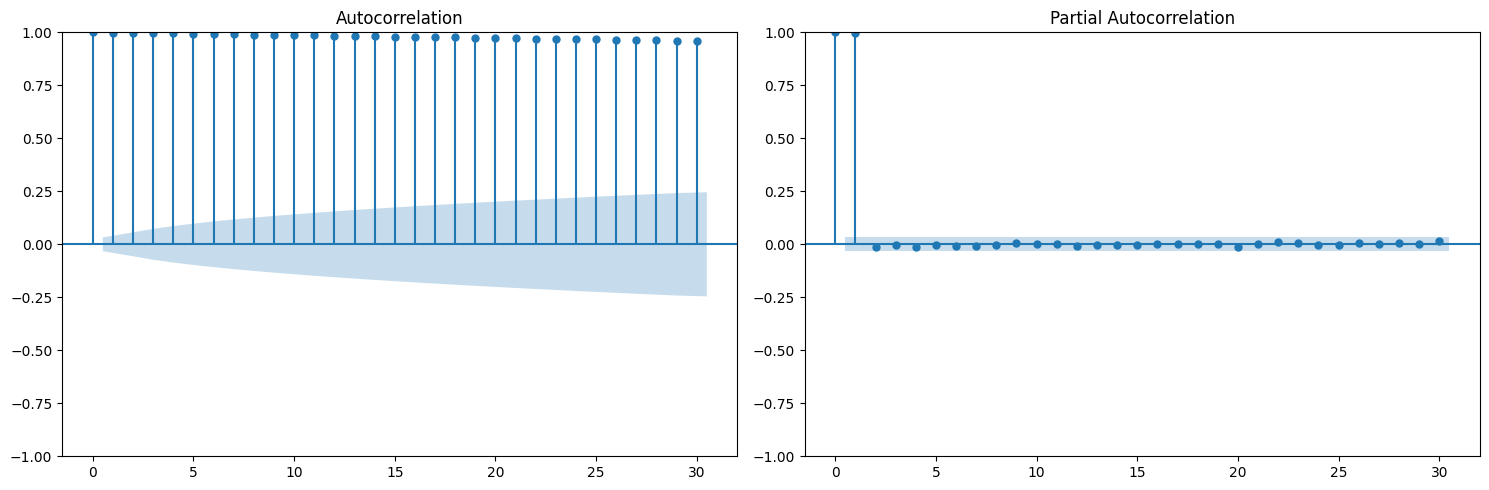

<Figure size 1200x600 with 0 Axes>

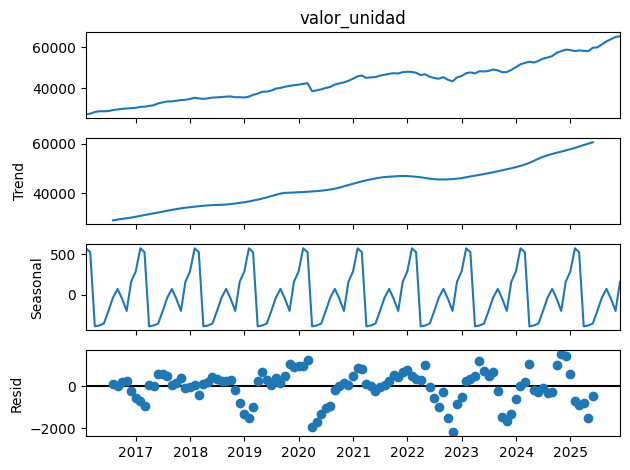

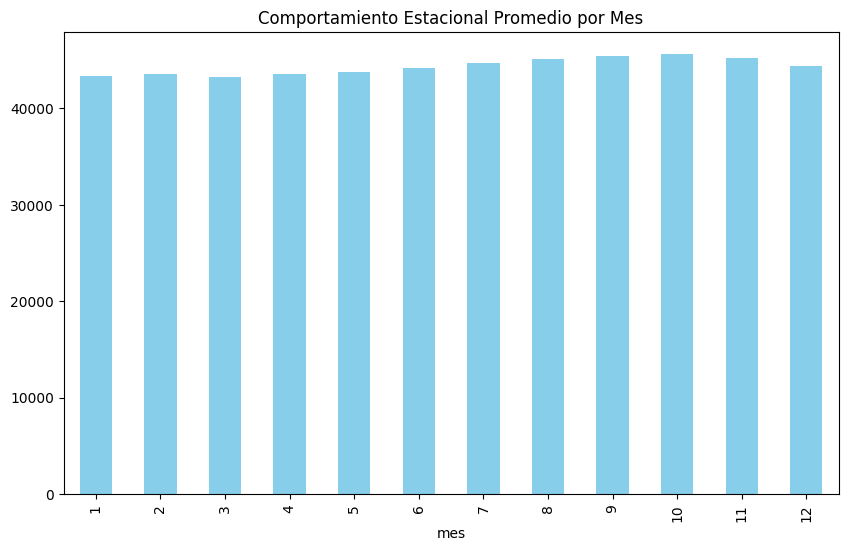

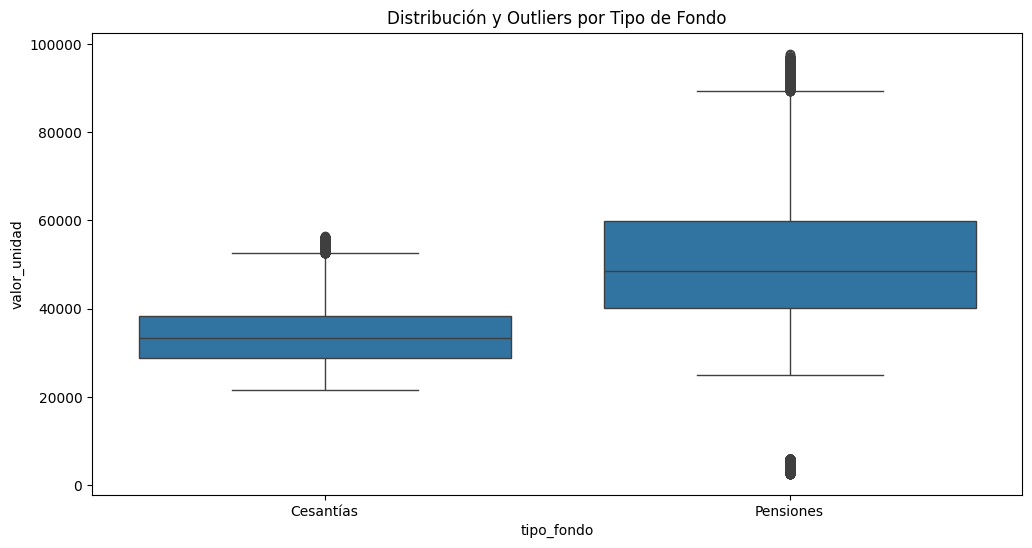

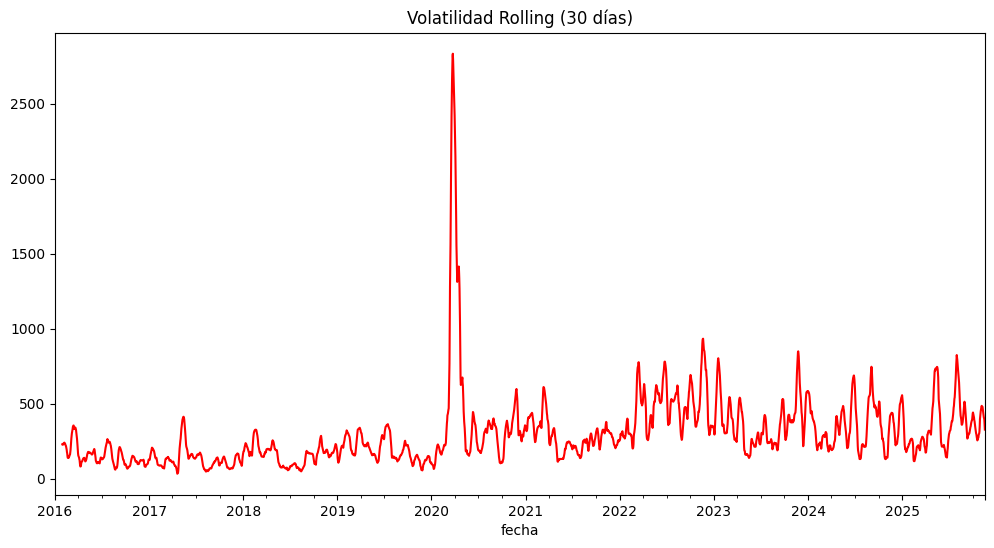

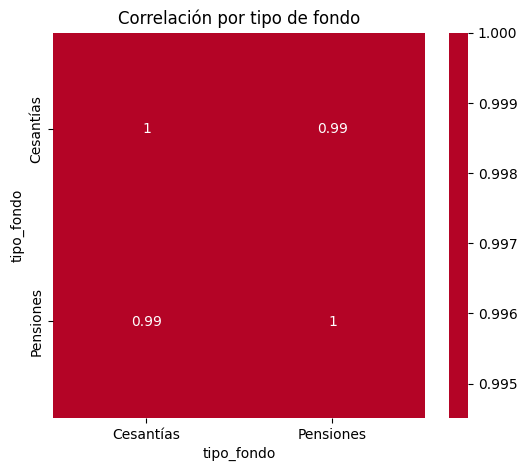

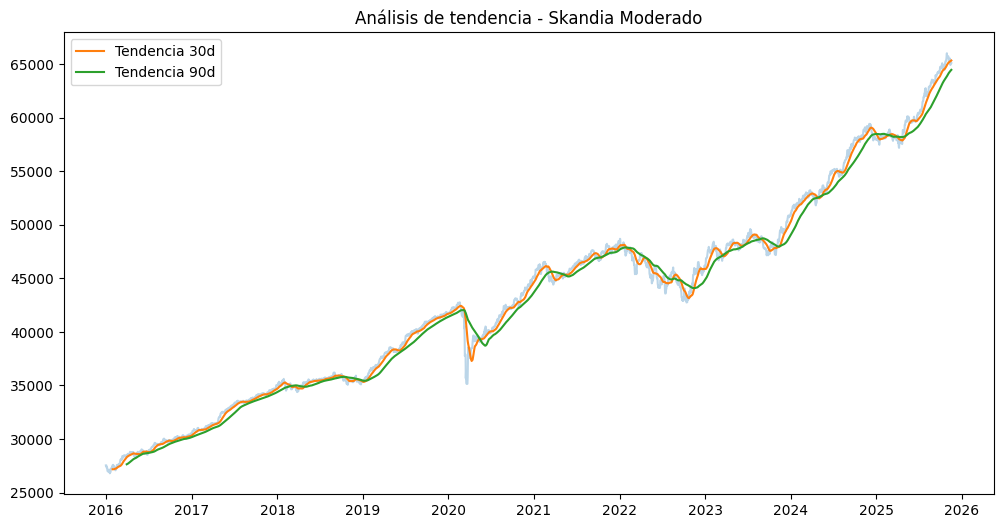

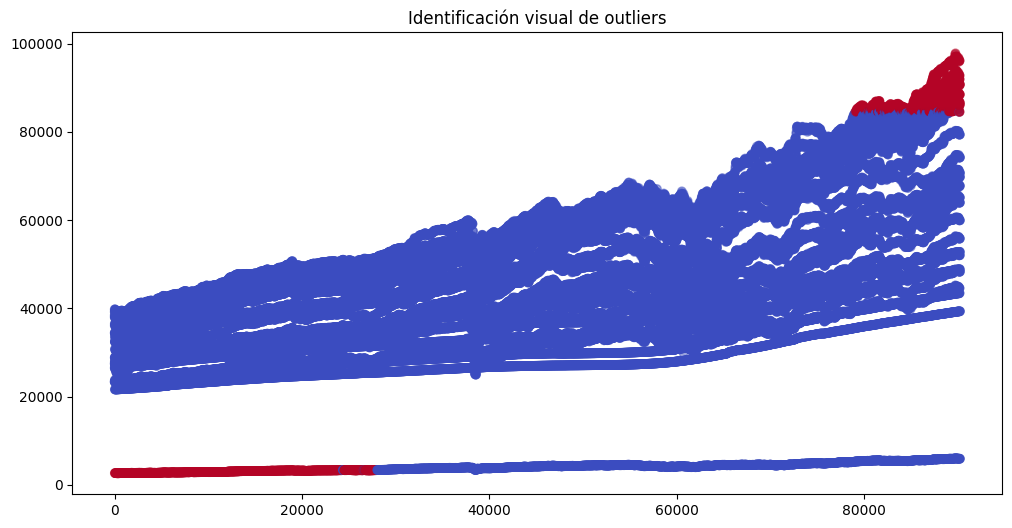

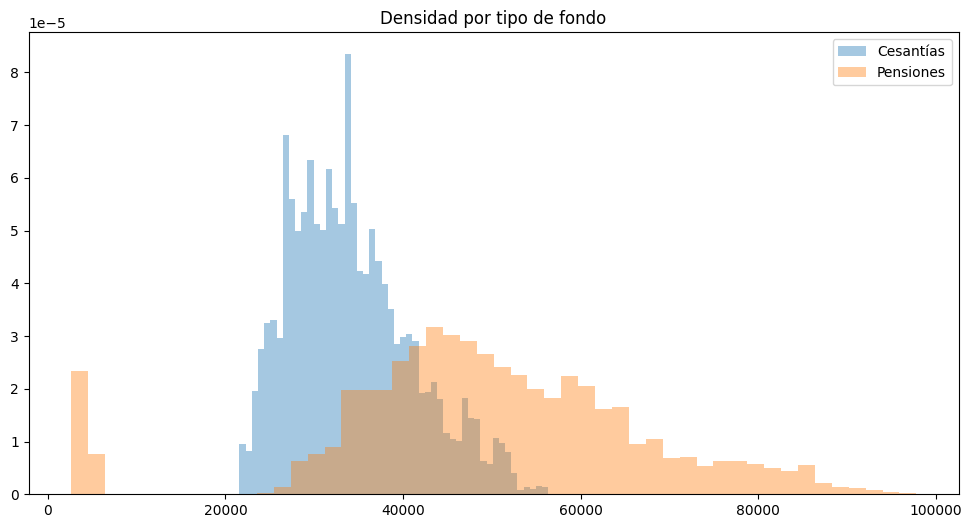


13. ANÁLISIS TEMPORAL POR AÑO:


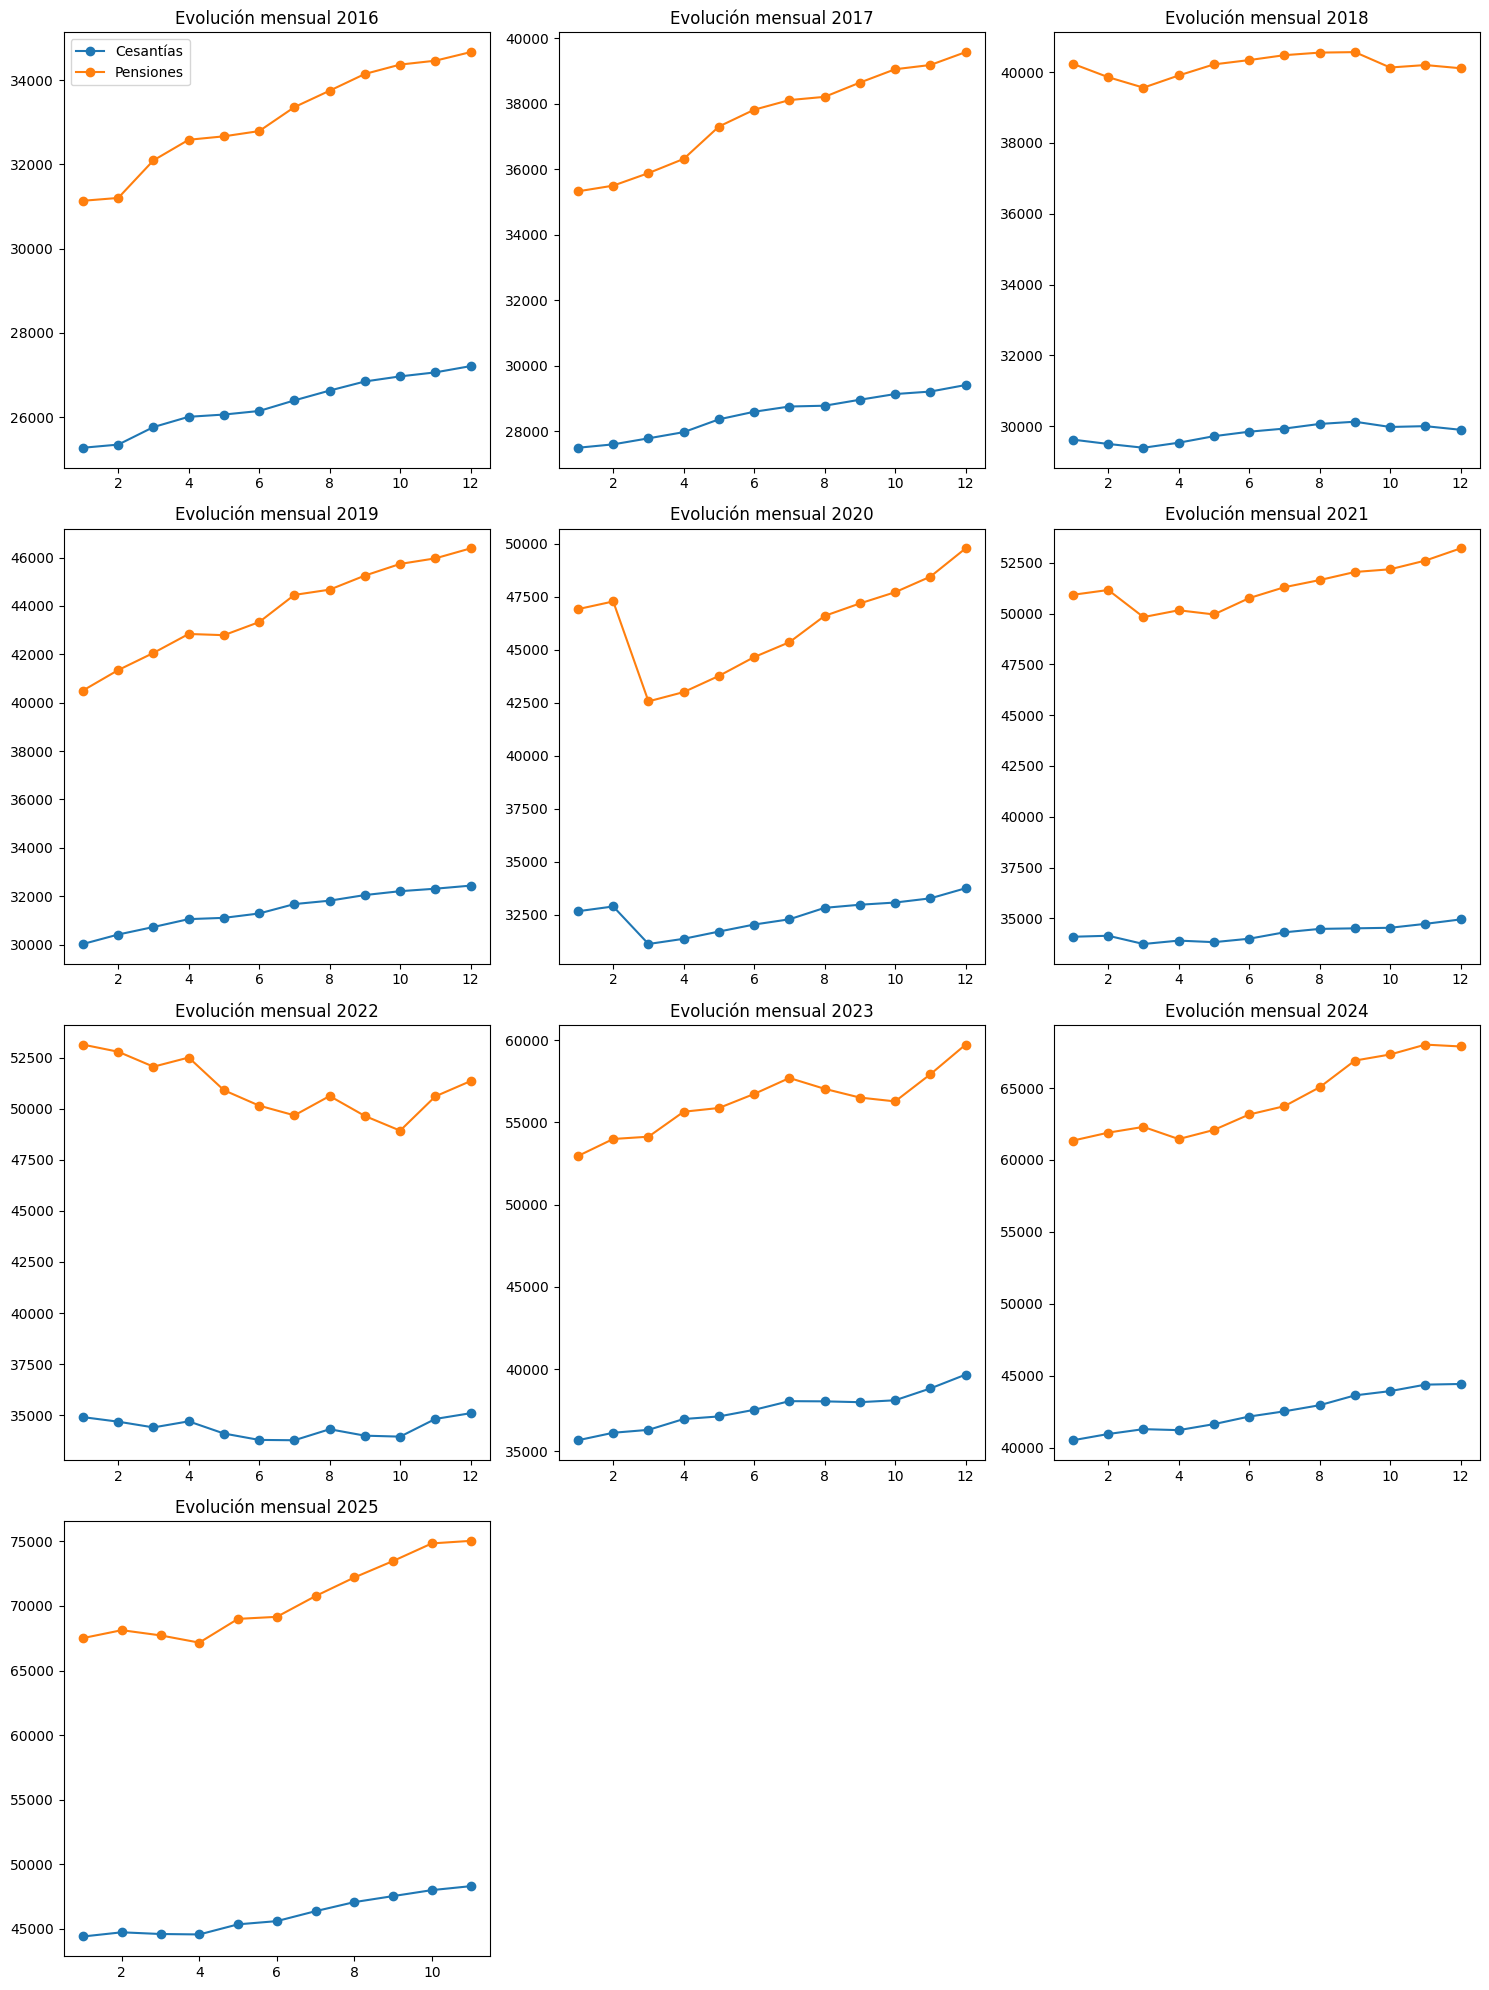


14. RESUMEN PARA MODELADO:
Rango temporal: 2016-01-01 00:00:00 a 2025-11-17 00:00:00
Observaciones: 90,219
Entidades únicas: 4
Fondos únicos: 7
Rango valores: 2596.40 - 97821.91
Coeficiente de variación: 37.26%

15. EXPORTAR DATASET PARA MODELADO
EDA COMPLETADO


In [162]:
print('='*60) ; print('ANÁLISIS EXPLORATORIO COMPLETO (EDA)') ; print('='*60)
print('\n1. ESTADÍSTICAS DESCRIPTIVAS:')
display(df[['valor_unidad']].describe())
print('\nEstadísticas por tipo de fondo:')
display(df.groupby('tipo_fondo', observed=True)['valor_unidad'].describe())

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
df['valor_unidad'].hist(bins=50, alpha=0.7)
plt.title('Distribución de valor_unidad')
plt.subplot(1,2,2)
df['valor_unidad'].plot(kind='density')
plt.title('Densidad de valor_unidad')
plt.tight_layout()
plt.savefig(GRAFICAS_COMP_DIR / 'distribucion_valor_unidad.png', dpi=300, bbox_inches='tight')
plt.show()

print('\n3. ANÁLISIS TEMPORAL:')
evolucion_anual = df.groupby('año')['valor_unidad'].agg(['mean','std','min','max'])
display(evolucion_anual)
plt.figure(figsize=(12,6))
plt.plot(evolucion_anual.index, evolucion_anual['mean'], marker='o')
plt.fill_between(evolucion_anual.index, evolucion_anual['mean']-evolucion_anual['std'], evolucion_anual['mean']+evolucion_anual['std'], alpha=0.2)
plt.title('Evolución Anual del Valor Unidad (media ± desviación)')
plt.grid(True, alpha=0.3)
plt.savefig(GRAFICAS_COMP_DIR / 'evolucion_anual.png', dpi=300, bbox_inches='tight')
plt.show()

fondo_ejemplo = mapa_fondos_skandia['Fondo de Pensiones Moderado'].set_index('fecha')['valor_unidad']
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(fondo_ejemplo, lags=30, ax=plt.gca())
plt.subplot(1,2,2)
plot_pacf(fondo_ejemplo, lags=30, ax=plt.gca())
plt.tight_layout()
plt.savefig(GRAFICAS_COMP_DIR / 'autocorrelacion.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12,6))
fondo_mensual = fondo_ejemplo.resample('ME').mean()
res = seasonal_decompose(fondo_mensual, model='additive', period=12)
res.plot()
plt.tight_layout()
plt.savefig(GRAFICAS_COMP_DIR / 'descomposicion_estacional.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,6))
estacionalidad_mensual = df.groupby('mes')['valor_unidad'].mean()
estacionalidad_mensual.plot(kind='bar', color='skyblue')
plt.title('Comportamiento Estacional Promedio por Mes')
plt.savefig(GRAFICAS_COMP_DIR / 'estacionalidad_mensual.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='tipo_fondo', y='valor_unidad')
plt.title('Distribución y Outliers por Tipo de Fondo')
plt.savefig(GRAFICAS_COMP_DIR / 'boxplot_tipos_fondo.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12,6))
(fondo_ejemplo.rolling(window=30).std()).plot(color='red')
plt.title('Volatilidad Rolling (30 días)')
plt.savefig(GRAFICAS_COMP_DIR / 'volatilidad_rolling.png', dpi=300, bbox_inches='tight')
plt.show()

pivot_corr = df.pivot_table(index='fecha', columns='tipo_fondo', values='valor_unidad', observed=False).corr()
plt.figure(figsize=(6,5))
sns.heatmap(pivot_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlación por tipo de fondo')
plt.savefig(GRAFICAS_COMP_DIR / 'correlacion_tipos_fondo.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12,6))
plt.plot(fondo_ejemplo.index, fondo_ejemplo.values, alpha=0.3)
plt.plot(fondo_ejemplo.rolling(30).mean(), label='Tendencia 30d')
plt.plot(fondo_ejemplo.rolling(90).mean(), label='Tendencia 90d')
plt.legend(); plt.title('Análisis de tendencia - Skandia Moderado')
plt.savefig(GRAFICAS_COMP_DIR / 'analisis_tendencia.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12,6))
plt.scatter(df.index, df['valor_unidad'], c=df['es_outlier'], cmap='coolwarm', alpha=0.5)
plt.title('Identificación visual de outliers')
plt.savefig(GRAFICAS_COMP_DIR / 'outliers_detallado.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12,6))
for tipo in df['tipo_fondo'].unique():
    subset = df[df['tipo_fondo']==tipo]
    plt.hist(subset['valor_unidad'], bins=50, alpha=0.4, label=tipo, density=True)
plt.legend(); plt.title('Densidad por tipo de fondo')
plt.savefig(GRAFICAS_COMP_DIR / 'densidad_tipos_fondo.png', dpi=300, bbox_inches='tight')
plt.show()

print('\n13. ANÁLISIS TEMPORAL POR AÑO:')
years = sorted(df['año'].unique())
n_cols = 3
n_rows = (len(years) + n_cols - 1) // n_cols
plt.figure(figsize=(15,5*n_rows))
for i, year in enumerate(years,1):
    plt.subplot(n_rows, n_cols, i)
    data_year = df[df['año']==year]
    for tipo in data_year['tipo_fondo'].unique():
        monthly_avg = data_year[data_year['tipo_fondo']==tipo].groupby('mes')['valor_unidad'].mean()
        plt.plot(monthly_avg.index, monthly_avg.values, marker='o', label=tipo)
    plt.title(f'Evolución mensual {year}')
    if i==1:
        plt.legend()
plt.tight_layout()
plt.savefig(EDA_IMG_DIR / 'evolucion_mensual_por_año.png', dpi=300, bbox_inches='tight')
plt.show()

print('\n14. RESUMEN PARA MODELADO:')
print(f"Rango temporal: {df['fecha'].min()} a {df['fecha'].max()}")
print(f"Observaciones: {len(df):,}")
print(f"Entidades únicas: {df['nombre_entidad'].nunique()}")
print(f"Fondos únicos: {df['nombre_fondo'].nunique()}")
print(f"Rango valores: {df['valor_unidad'].min():.2f} - {df['valor_unidad'].max():.2f}")
print(f"Coeficiente de variación: {(df['valor_unidad'].std()/df['valor_unidad'].mean()*100):.2f}%")

print('\n15. EXPORTAR DATASET PARA MODELADO')
df_modelado = df.dropna(subset=['valor_unidad','fecha','nombre_entidad','nombre_fondo']).copy()
df_modelado.to_csv(PROCESSED_DIR / 'pensiones_listo_modelado.csv', index=False, encoding='utf-8')

print('='*60)
print('EDA COMPLETADO')
print('='*60)


Con este bloque mostramos todas las gráficas clave directamente en el cuaderno, lo que permite narrar los hallazgos en vivo.

## 15. Funciones de modelado ARIMA

In [ ]:

print("\n" + "="*60)
print("FASE 4: MODELADO DE SERIES TEMPORALES")
print("="*60)

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

def analizar_estacionariedad(serie, nombre_serie=""):
    """
    Analiza la estacionariedad de una serie temporal usando la prueba ADF.
    """
    print(f"\n--- Análisis de Estacionariedad: {nombre_serie} ---")
    resultado_adf = adfuller(serie.dropna())
    metricas = {
        'estadistico_adf': resultado_adf[0],
        'p_valor': resultado_adf[1],
        'valores_criticos': resultado_adf[4],
        'es_estacionaria': resultado_adf[1] < 0.05
    }
    print(f"Estadístico ADF: {metricas['estadistico_adf']:.4f}")
    print(f"P-valor: {metricas['p_valor']:.4f}")
    if metricas['es_estacionaria']:
        print("✓ La serie ES estacionaria (p-valor < 0.05)")
    else:
        print("✗ La serie NO es estacionaria (p-valor > 0.05)")
        print("  Se recomienda diferenciar antes de modelar")
    return metricas

def entrenar_modelo_arima(serie, orden, nombre_serie=""):
    """
    Entrena un modelo ARIMA y devuelve el ajuste y sus métricas clave.
    """
    print(f"Entrenando ARIMA{orden} para {nombre_serie}...")
    try:
        modelo = ARIMA(serie, order=orden)
        modelo_ajustado = modelo.fit()
        metricas = {
            'aic': modelo_ajustado.aic,
            'bic': modelo_ajustado.bic,
            'residuos_media': modelo_ajustado.resid.mean(),
            'residuos_std': modelo_ajustado.resid.std()
        }
        print(f" ARIMA{orden} entrenado | AIC={metricas['aic']:.2f} | BIC={metricas['bic']:.2f}")
        return modelo_ajustado, metricas
    except Exception as e:
        print(f" Error entrenando ARIMA{orden}: {e}")
        return None, None

def buscar_mejor_arima(serie, parametros_a_probar, nombre_serie=""):
    """
    Busca el mejor ARIMA dentro de una grilla reducida de parámetros.
    """
    print(f"\nBuscando mejor modelo ARIMA para {nombre_serie}...")
    mejores_metricas = {'aic': float('inf')}
    mejor_modelo = None
    mejor_orden = None
    for orden in parametros_a_probar:
        modelo, metricas = entrenar_modelo_arima(serie, orden, nombre_serie)
        if modelo and metricas and metricas['aic'] < mejores_metricas['aic']:
            mejores_metricas = metricas
            mejor_modelo = modelo
            mejor_orden = orden
    if mejor_modelo:
        print(f"\n MEJOR MODELO: ARIMA{mejor_orden} con AIC={mejores_metricas['aic']:.2f}")
        return {'modelo': mejor_modelo, 'orden': mejor_orden, 'metricas': mejores_metricas}
    print("✗ No se pudo encontrar un modelo adecuado")
    return None

def evaluar_pronostico(real, pronosticado, nombre_serie=""):
    """
    Calcula métricas MAE, MSE, RMSE y MAPE para el tramo de validación.
    """
    print(f"\n--- Evaluación de Pronósticos: {nombre_serie} ---")
    mse = np.mean((real - pronosticado)**2)
    mae = np.mean(np.abs(real - pronosticado))
    mape = np.mean(np.abs((real - pronosticado) / real)) * 100
    rmse = np.sqrt(mse)
    metricas = {'MSE': mse, 'MAE': mae, 'MAPE': mape, 'RMSE': rmse}
    for metrica, valor in metricas.items():
        print(f"  {metrica}: {valor:.4f}")
    print(f"  Error porcentual promedio (MAPE): {mape:.2f}%")
    return metricas

def pipeline_modelado_completo(df_serie, nombre_serie, columna_valor='valor_unidad'):
    """
    Ejecuta el pipeline completo: estaciónariedad, búsqueda ARIMA, validación y pronóstico.
    """
    print(f"\n{'='*50}")
    print(f"INICIANDO PIPELINE DE MODELADO: {nombre_serie}")
    print(f"{'='*50}")
    resultados = {}
    print("\n1.  PREPARANDO DATOS...")
    serie = df_serie.set_index('fecha')[columna_valor].sort_index()
    resultados['serie_original'] = serie.copy()
    print("\n2. ANALIZANDO ESTACIONARIEDAD...")
    resultados['estacionariedad'] = analizar_estacionariedad(serie, nombre_serie)
    if not resultados['estacionariedad']['es_estacionaria']:
        print("\n3.  APLICANDO DIFERENCIACIÓN...")
        serie_diff = serie.diff().dropna()
        resultados['serie_diferenciada'] = serie_diff
        resultados['estacionariedad_diff'] = analizar_estacionariedad(serie_diff, f"{nombre_serie} (diferenciada)")
        serie_para_modelar = serie_diff
        resultados['usa_diferencia'] = True
    else:
        serie_para_modelar = serie
        resultados['usa_diferencia'] = False
    print("\n4.  BUSCANDO MEJOR MODELO ARIMA...")
    if resultados['usa_diferencia']:
        parametros_a_probar = [(1,0,0), (2,0,0), (1,0,1), (2,0,1)]
    else:
        parametros_a_probar = [(1,0,0), (1,1,1), (2,1,2), (0,1,1), (1,1,0)]
    resultados['serie_para_modelar'] = serie_para_modelar
    resultados['mejor_modelo'] = buscar_mejor_arima(serie_para_modelar, parametros_a_probar, nombre_serie)
    if resultados['mejor_modelo']:
        modelo = resultados['mejor_modelo']['modelo']
        print("\n5. VALIDANDO MODELO...")
        train_size = int(len(serie_para_modelar) * 0.8)
        train, test = serie_para_modelar[:train_size], serie_para_modelar[train_size:]
        modelo_train = ARIMA(train, order=resultados['mejor_modelo']['orden']).fit()
        pronostico = modelo_train.forecast(steps=len(test))
        resultados['evaluacion'] = evaluar_pronostico(test.values, pronostico.values, nombre_serie)
        print("\n6. GENERANDO PRONÓSTICOS FUTUROS...")
        pronostico_futuro = modelo.forecast(steps=30)
        resultados['pronostico_futuro'] = pronostico_futuro
        print(" Pronóstico listo para los próximos 30 pasos (en escala del modelado).")
    return resultados



FASE 4: MODELADO DE SERIES TEMPORALES


## 16. Modelado ARIMA sobre series representativas
Ejecutamos el pipeline anterior en tres series con suficiente historial para presentar resultados en vivo.

In [ ]:

print("\n" + "="*60)
print("EJECUTANDO MODELADO EN SERIES REPRESENTATIVAS")
print("="*60)

series_a_modelar = {
    "Fondo Moderado Skandia": df_skandia_pensiones_moderado,
    "Fondo Conservador Porvenir": df_porvenir_pensiones_conservador,
    "Cesantías Largo Plazo Colfondos": df_colfondos_cesantias_largo_plazo
}

resultados_modelado = {}
for nombre_serie, df_serie in series_a_modelar.items():
    if len(df_serie) > 100:
        try:
            resultados = pipeline_modelado_completo(df_serie, nombre_serie)
            resultados_modelado[nombre_serie] = resultados
        except Exception as exc:
            print(f"✗ Error en modelado de {nombre_serie}: {exc}")
    else:
        print(f" Serie {nombre_serie} muy corta para modelado ({len(df_serie)} registros)")

print("Series con resultados:", list(resultados_modelado.keys()))



EJECUTANDO MODELADO EN SERIES REPRESENTATIVAS

INICIANDO PIPELINE DE MODELADO: Fondo Moderado Skandia

1.  PREPARANDO DATOS...

2. 🔍 ANALIZANDO ESTACIONARIEDAD...

--- Análisis de Estacionariedad: Fondo Moderado Skandia ---
Estadístico ADF: 0.8230
P-valor: 0.9920
✗ La serie NO es estacionaria (p-valor > 0.05)
  Se recomienda diferenciar antes de modelar

3. ⚙️  APLICANDO DIFERENCIACIÓN...

--- Análisis de Estacionariedad: Fondo Moderado Skandia (diferenciada) ---
Estadístico ADF: -11.3657
P-valor: 0.0000
✓ La serie ES estacionaria (p-valor < 0.05)

4. 🤖 BUSCANDO MEJOR MODELO ARIMA...

Buscando mejor modelo ARIMA para Fondo Moderado Skandia...
Entrenando ARIMA(1, 0, 0) para Fondo Moderado Skandia...
✓ ARIMA(1, 0, 0) entrenado | AIC=45930.40 | BIC=45948.97
Entrenando ARIMA(2, 0, 0) para Fondo Moderado Skandia...
✓ ARIMA(2, 0, 0) entrenado | AIC=45928.66 | BIC=45953.42
Entrenando ARIMA(1, 0, 1) para Fondo Moderado Skandia...
✓ ARIMA(1, 0, 1) entrenado | AIC=45920.39 | BIC=45945.15
Entren

## 17. Comparación y visualización de modelos
Tabulamos métricas, discutimos recomendaciones y mostramos los gráficos reconstruidos en niveles.

In [165]:

print("\n" + "="*60)
print("ANÁLISIS COMPARATIVO DE MODELOS")
print("="*60)

if resultados_modelado:
    comparacion_modelos = []
    for nombre, resultados in resultados_modelado.items():
        mejor = resultados.get('mejor_modelo')
        if mejor:
            comparacion_modelos.append({
                'Serie': nombre,
                'Mejor Modelo': f"ARIMA{mejor['orden']}",
                'AIC': mejor['metricas']['aic'],
                'Estacionaria': resultados['estacionariedad']['es_estacionaria'],
                'MAPE (%)': resultados.get('evaluacion', {}).get('MAPE', np.nan)
            })
    if comparacion_modelos:
        df_comparacion = pd.DataFrame(comparacion_modelos)
        display(df_comparacion)
        print("\nResumen estadístico de las métricas numéricas:")
        display(df_comparacion.describe(include='all'))
        mejor_modelo = df_comparacion.loc[df_comparacion['AIC'].idxmin()]
        print(f"\n• Mejor AIC: {mejor_modelo['Serie']} ({mejor_modelo['Mejor Modelo']})")
        print("Recomendaciones:")
        print("  1. Series estacionarias -> ARMA puro puede simplificar el pipeline.")
        print("  2. Series no estacionarias -> probar SARIMA con diferenciación estacional.")
        print("  3. Revisar outliers en series con MAPE más alto para reducir errores.")
    else:
        print("No se generaron métricas comparables.")
else:
    print("✗ No se pudieron generar modelos para comparación")



ANÁLISIS COMPARATIVO DE MODELOS


Serie    Mejor Modelo           AIC  \
0           Fondo Moderado Skandia  ARIMA(1, 0, 1)  45920.390442   
1       Fondo Conservador Porvenir  ARIMA(1, 0, 1)  46040.734743   
2  Cesantías Largo Plazo Colfondos  ARIMA(1, 0, 1)  44151.846806   

   Estacionaria   MAPE (%)  
0         False  89.941259  
1         False  89.172435  
2         False  83.649067


Resumen estadístico de las métricas numéricas:


Serie    Mejor Modelo           AIC Estacionaria  \
count                        3               3      3.000000            3   
unique                       3               1           NaN            1   
top     Fondo Moderado Skandia  ARIMA(1, 0, 1)           NaN        False   
freq                         1               3           NaN            3   
mean                       NaN             NaN  45370.990664          NaN   
std                        NaN             NaN   1057.522812          NaN   
min                        NaN             NaN  44151.846806          NaN   
25%                        NaN             NaN  45036.118624          NaN   
50%                        NaN             NaN  45920.390442          NaN   
75%                        NaN             NaN  45980.562593          NaN   
max                        NaN             NaN  46040.734743          NaN   

         MAPE (%)  
count    3.000000  
unique        NaN  
top           NaN  
freq          NaN  
mean    87.587587  
std      3.432452  
min     83.649067  
25%     86.410751  
50%     89.172435  
75%     89.556847  
max     89.941259


• Mejor AIC: Cesantías Largo Plazo Colfondos (ARIMA(1, 0, 1))
Recomendaciones:
  1. Series estacionarias -> ARMA puro puede simplificar el pipeline.
  2. Series no estacionarias -> probar SARIMA con diferenciación estacional.
  3. Revisar outliers en series con MAPE más alto para reducir errores.



🎨 GENERANDO VISUALIZACIONES DE RESULTADOS...


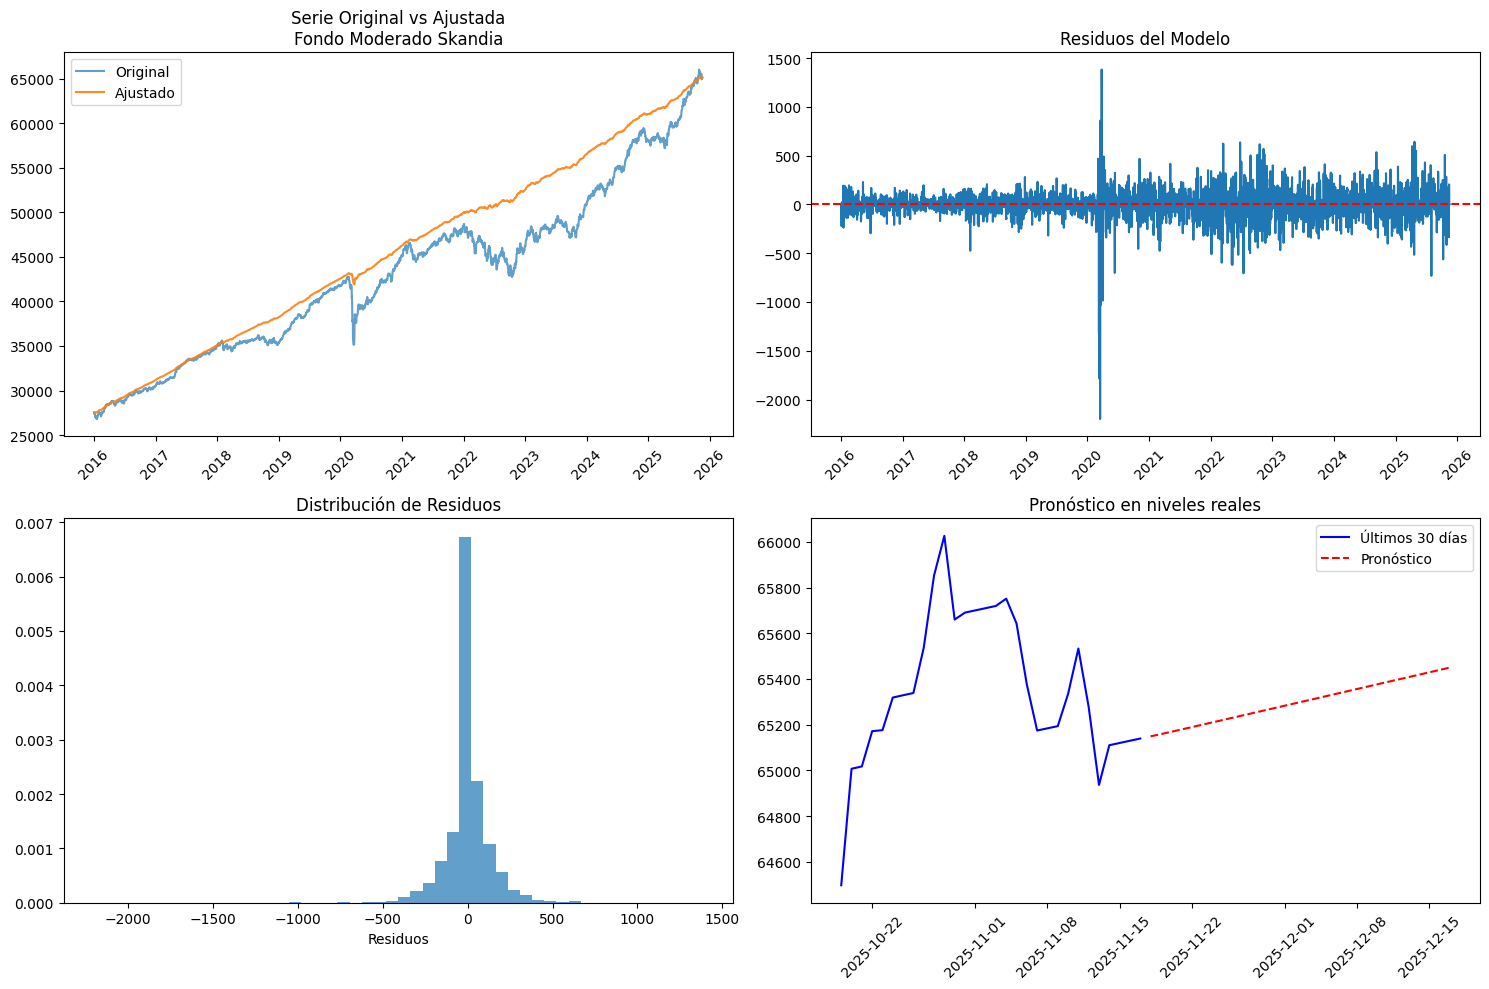

✓ Gráficas reconstruidas para: Fondo Moderado Skandia


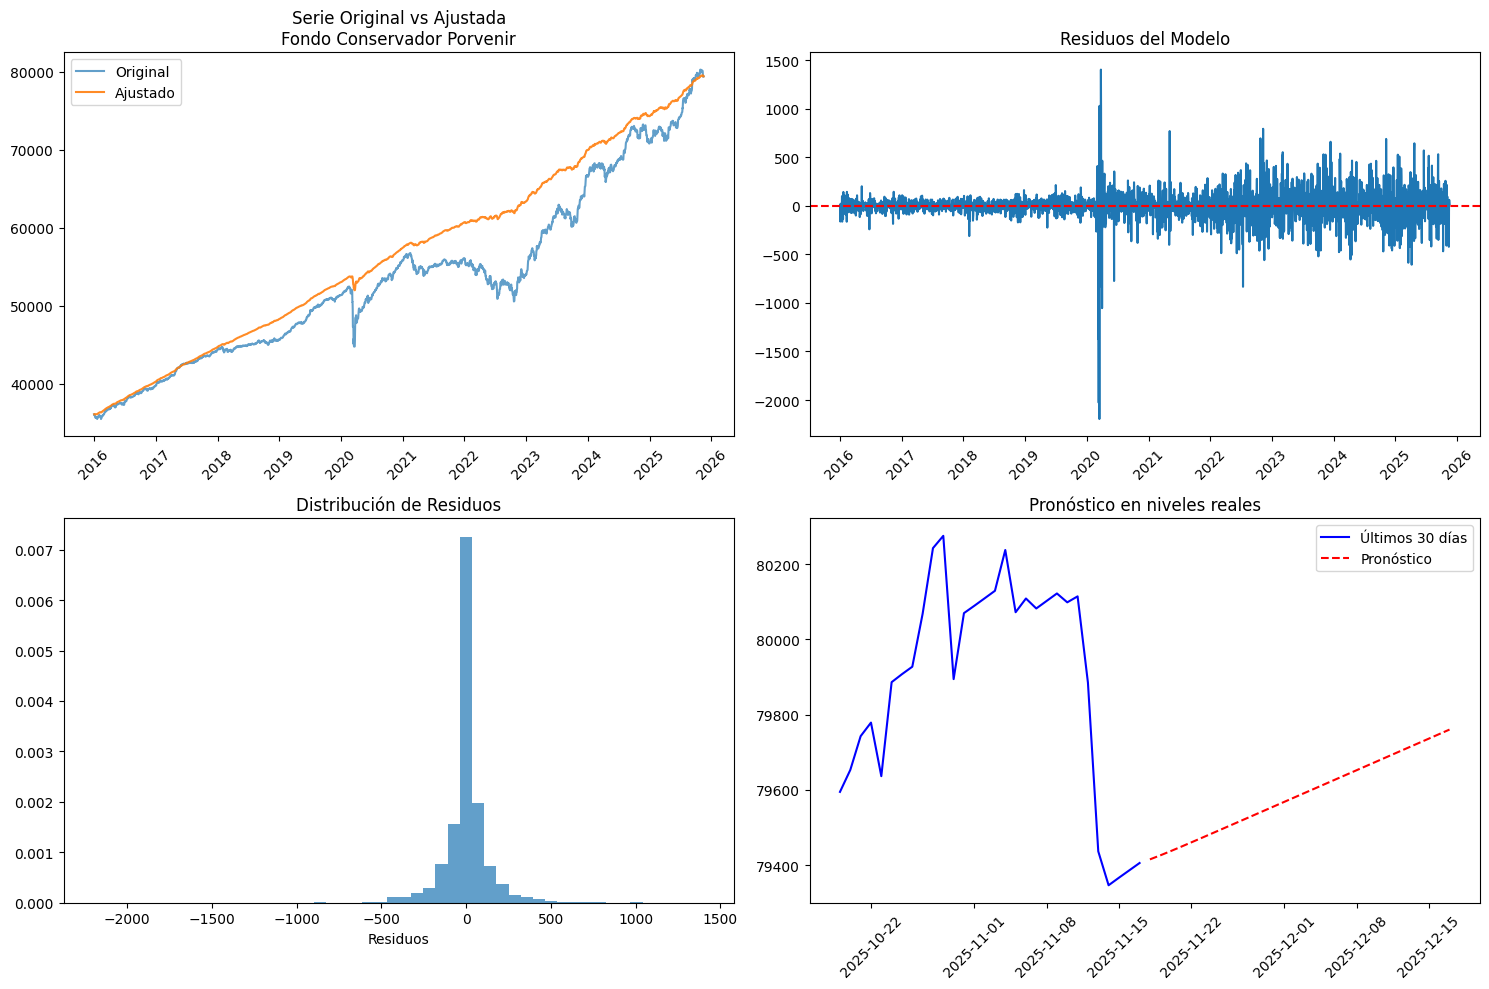

✓ Gráficas reconstruidas para: Fondo Conservador Porvenir


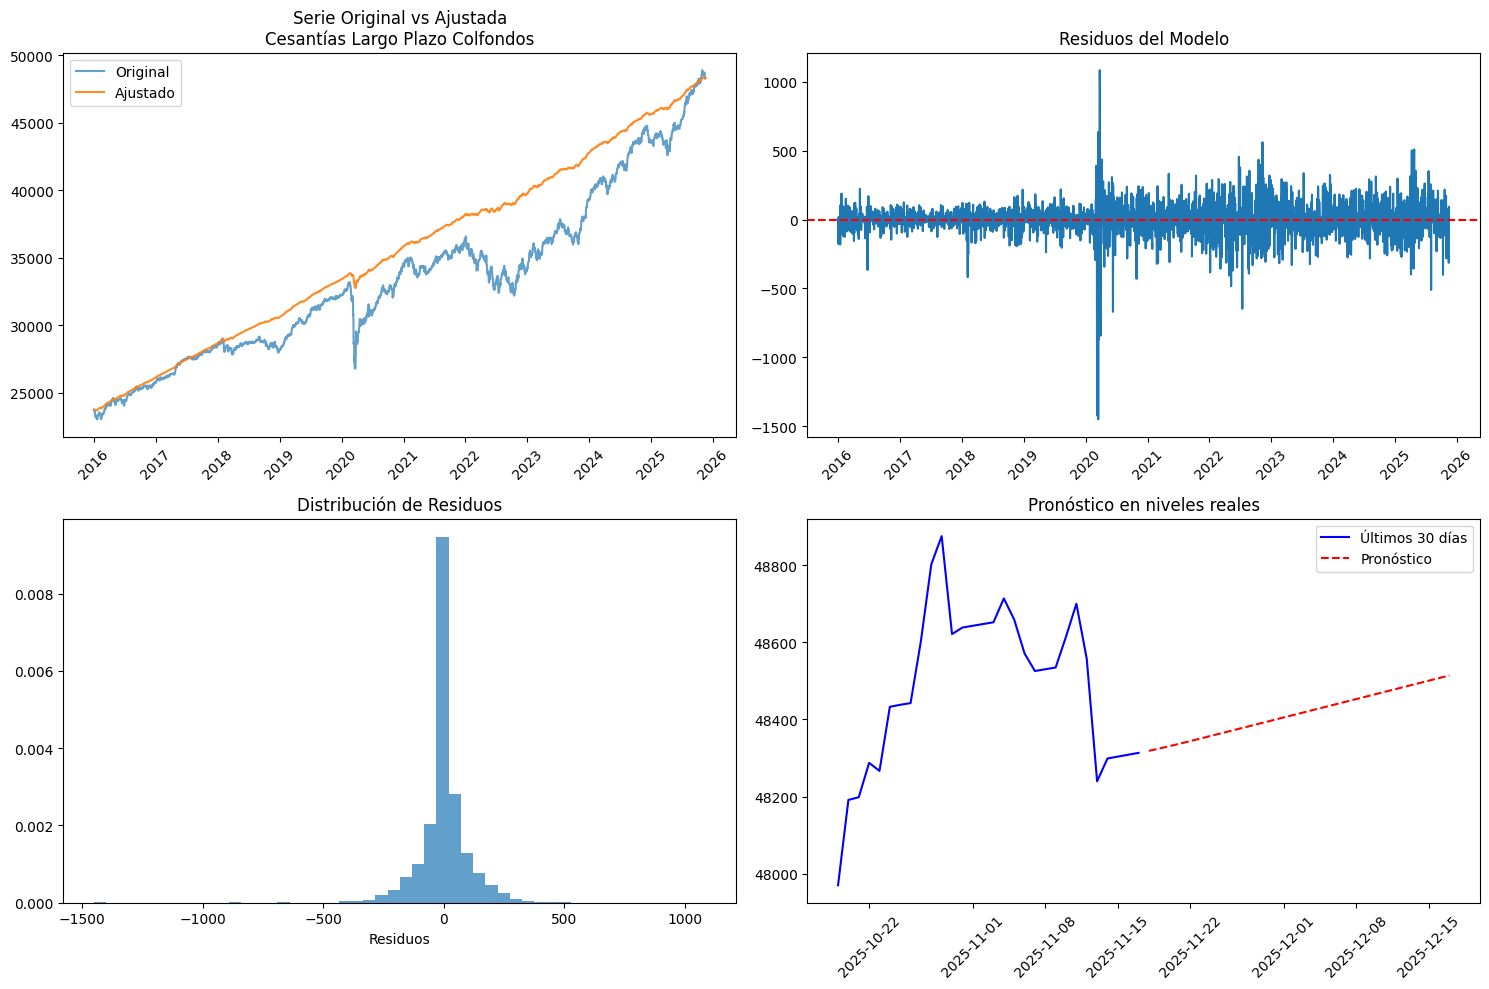

✓ Gráficas reconstruidas para: Cesantías Largo Plazo Colfondos


In [ ]:

def visualizar_resultados_modelado(resultados_modelado):
    """Reconstruye en niveles los ajustes/pronósticos y muestra panel de 4 gráficas por serie."""
    print("\n GENERANDO VISUALIZACIONES DE RESULTADOS...")
    GRAFICAS_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    for nombre_serie, resultados in resultados_modelado.items():
        mejor = resultados.get('mejor_modelo')
        if not mejor:
            continue
        try:
            serie_original = resultados['serie_original']
            modelo = mejor['modelo']
            usa_dif = resultados.get('usa_diferencia', False)
            if usa_dif:
                serie_diff = resultados['serie_diferenciada']
                fitted_diff = modelo.fittedvalues
                fitted_diff = fitted_diff.loc[serie_diff.index]
                first_idx = serie_diff.index[0]
                base_pos = serie_original.index.get_loc(first_idx) - 1
                base_level = serie_original.iloc[base_pos]
                fitted_level = base_level + fitted_diff.cumsum()
                pronostico_diff = resultados['pronostico_futuro']
                last_level = serie_original.iloc[-1]
                forecast_level = last_level + pronostico_diff.cumsum()
            else:
                fitted_level = modelo.fittedvalues
                forecast_level = resultados.get('pronostico_futuro')
            plt.figure(figsize=(15, 10))
            plt.subplot(2, 2, 1)
            plt.plot(serie_original.index, serie_original.values, label='Original', alpha=0.7)
            idx_comun = serie_original.index.intersection(fitted_level.index)
            plt.plot(idx_comun, fitted_level.loc[idx_comun], label='Ajustado', alpha=0.9)
            plt.title(f'Serie Original vs Ajustada\n{nombre_serie}')
            plt.legend(); plt.xticks(rotation=45)
            plt.subplot(2, 2, 2)
            residuos = modelo.resid
            plt.plot(residuos.index, residuos.values)
            plt.title('Residuos del Modelo'); plt.axhline(y=0, color='r', linestyle='--')
            plt.xticks(rotation=45)
            plt.subplot(2, 2, 3)
            plt.hist(residuos.dropna(), bins=50, alpha=0.7, density=True)
            plt.title('Distribución de Residuos'); plt.xlabel('Residuos')
            plt.subplot(2, 2, 4)
            if forecast_level is not None:
                ultimos_30 = serie_original.tail(30)
                plt.plot(ultimos_30.index, ultimos_30.values, label='Últimos 30 días', color='blue')
                plt.plot(forecast_level.index, forecast_level.values, label='Pronóstico', color='red', linestyle='--')
                plt.title('Pronóstico en niveles reales'); plt.legend(); plt.xticks(rotation=45)
            plt.tight_layout()
            out = GRAFICAS_MODEL_DIR / f"resultados_{nombre_serie.replace(' ', '_').lower()}.png"
            plt.savefig(out, dpi=300, bbox_inches='tight')
            plt.show()
            plt.close()
            print(f"✓ Gráficas reconstruidas para: {nombre_serie}")
        except Exception as exc:
            print(f"✗ Error generando gráficas para {nombre_serie}: {exc}")

visualizar_resultados_modelado(resultados_modelado)


In [167]:

print("\n" + "="*60)
print("PIPELINE DE MODELADO COMPLETADO ✓")
print("="*60)
print(f"• Series modeladas: {len(resultados_modelado)}")
print(f"• Modelos con resultado: {sum(1 for r in resultados_modelado.values() if r.get('mejor_modelo'))}")
print(f"• Resultados guardados en: {MODELOS_DIR}")
print(f"• Gráficas guardadas en: {GRAFICAS_MODEL_DIR}")



PIPELINE DE MODELADO COMPLETADO ✓
• Series modeladas: 3
• Modelos con resultado: 3
• Resultados guardados en: /home/wolfang-sanchez/Documents/proyecto/data/modelos
• Gráficas guardadas en: /home/wolfang-sanchez/Documents/proyecto/data/graficas_modelado


## 18. Regresión lineal: Cesantías Corto Plazo (Skandia)
Extendemos una recta de tendencia de 2016 a 2026 para exponer la trayectoria y sus métricas de ajuste.

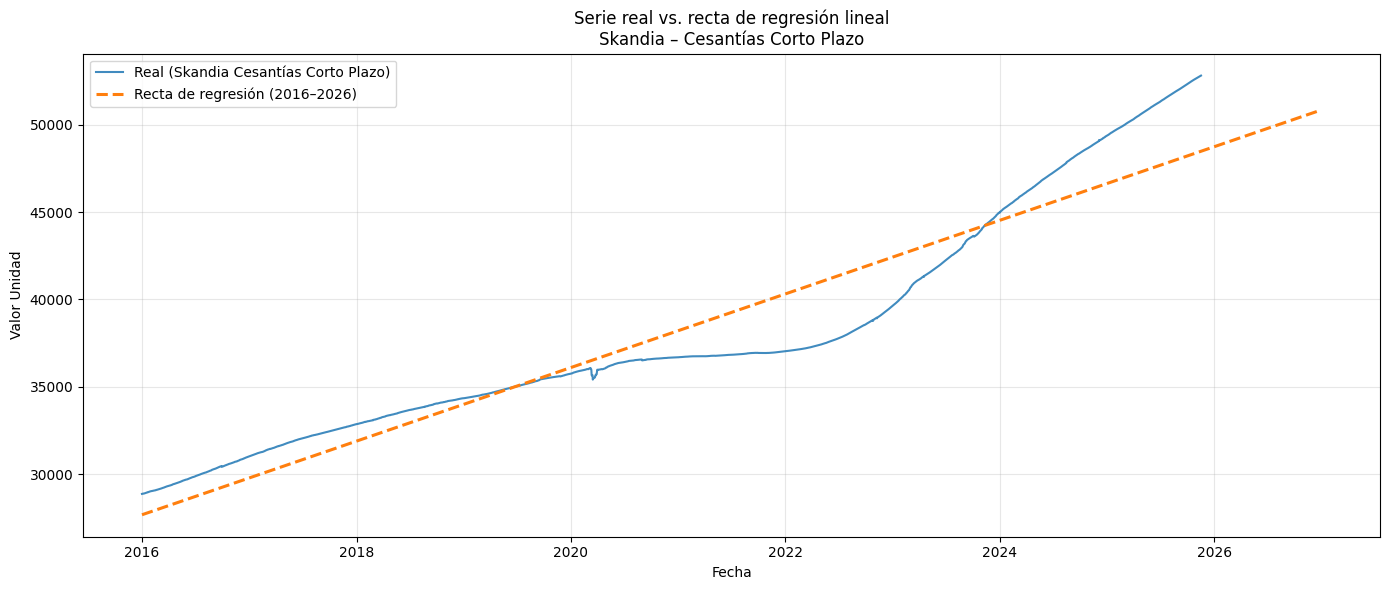

✓ Gráfica guardada en /home/wolfang-sanchez/Documents/proyecto/data/graficas_comparativas/reg_lineal_skandia_cesantias_corto_plazo.png
Métricas sobre la muestra | MAE=1603.81  RMSE=1969.73  MAPE=4.09%


In [168]:

serie_cp = (
    df_skandia_cesantias_corto_plazo[['fecha', 'valor_unidad']]
    .dropna()
    .sort_values('fecha')
    .copy()
)
if serie_cp.empty:
    raise ValueError("No hay datos para Skandia Cesantías Corto Plazo.")

t0 = serie_cp['fecha'].min()
X = (serie_cp['fecha'] - t0).dt.days.values.reshape(-1, 1)
y = serie_cp['valor_unidad'].values

lin = LinearRegression()
lin.fit(X, y)
y_fit = lin.predict(X)

inicio_linea = pd.Timestamp('2016-01-01')
fin_datos = serie_cp['fecha'].max()
fin_linea = max(fin_datos, pd.Timestamp('2026-12-31'))
fechas_linea = pd.date_range(start=inicio_linea, end=fin_linea, freq='D')
X_linea = ((fechas_linea - t0).days.values).reshape(-1, 1)
y_linea = lin.predict(X_linea)

plt.figure(figsize=(14, 6))
plt.plot(serie_cp['fecha'], serie_cp['valor_unidad'], label='Real (Skandia Cesantías Corto Plazo)', alpha=0.85)
plt.plot(fechas_linea, y_linea, '--', linewidth=2.2, label='Recta de regresión (2016–2026)')
plt.title('Serie real vs. recta de regresión lineal\nSkandia – Cesantías Corto Plazo')
plt.xlabel('Fecha'); plt.ylabel('Valor Unidad'); plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
out_img = GRAFICAS_COMP_DIR / 'reg_lineal_skandia_cesantias_corto_plazo.png'
plt.savefig(out_img, dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print(f"✓ Gráfica guardada en {out_img}")

mae = mean_absolute_error(y, y_fit)
rmse = np.sqrt(mean_squared_error(y, y_fit))
mape = np.mean(np.abs((y - y_fit) / y)) * 100
print(f"Métricas sobre la muestra | MAE={mae:.2f}  RMSE={rmse:.2f}  MAPE={mape:.2f}%")


## 19. Pronóstico lineal a 1 año para todos los fondos de Skandia
Mostramos la tendencia individual, el punto de predicción y registramos las métricas en un CSV.

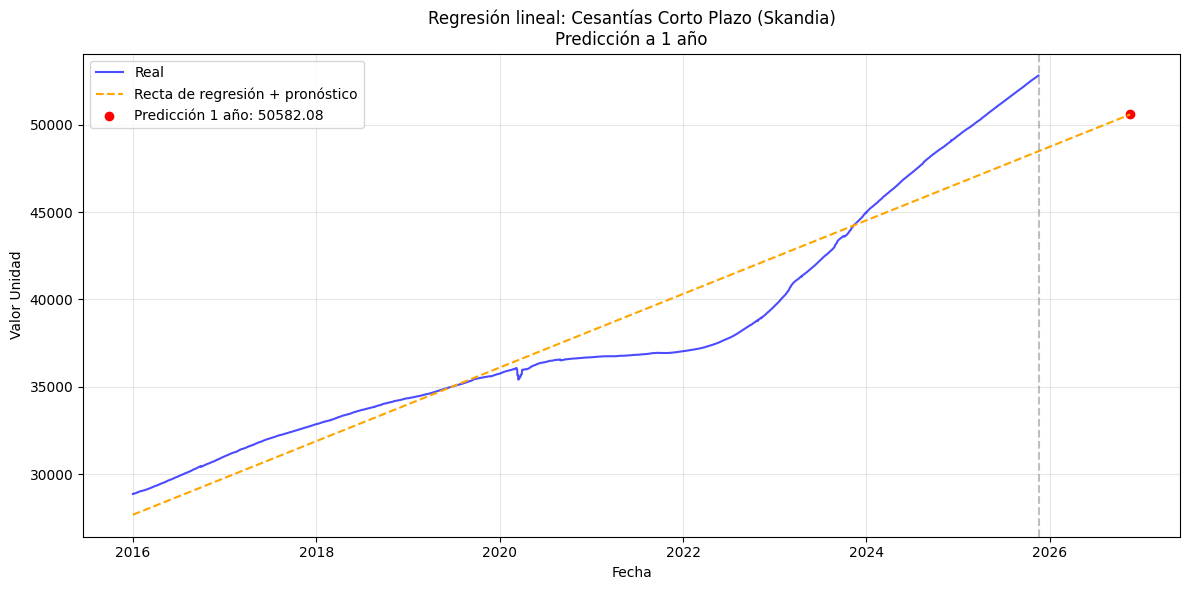

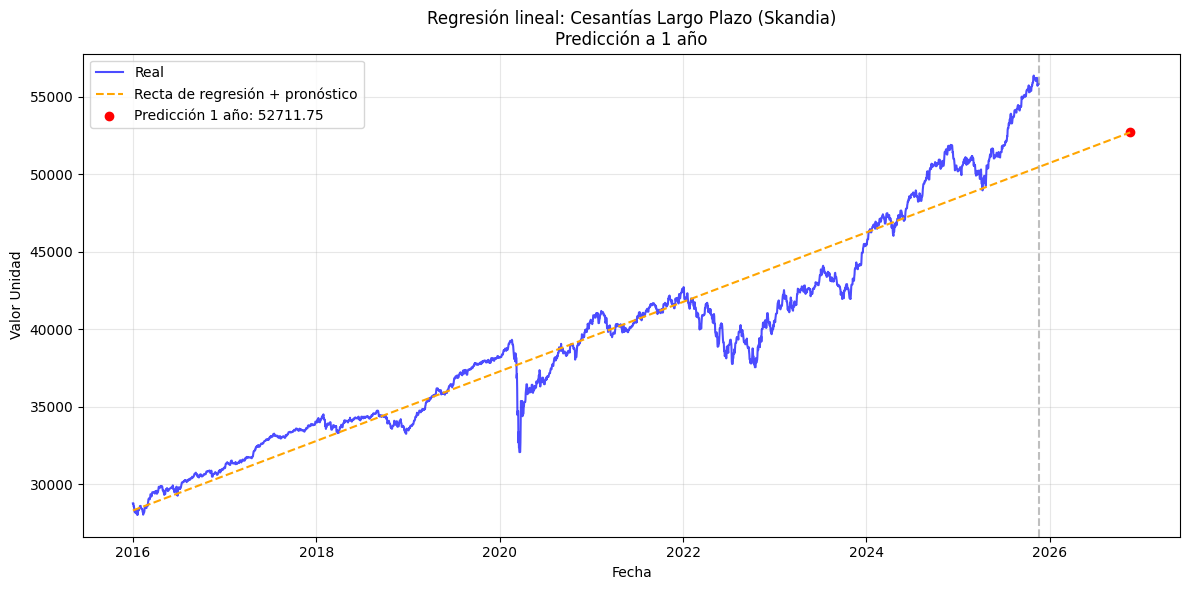

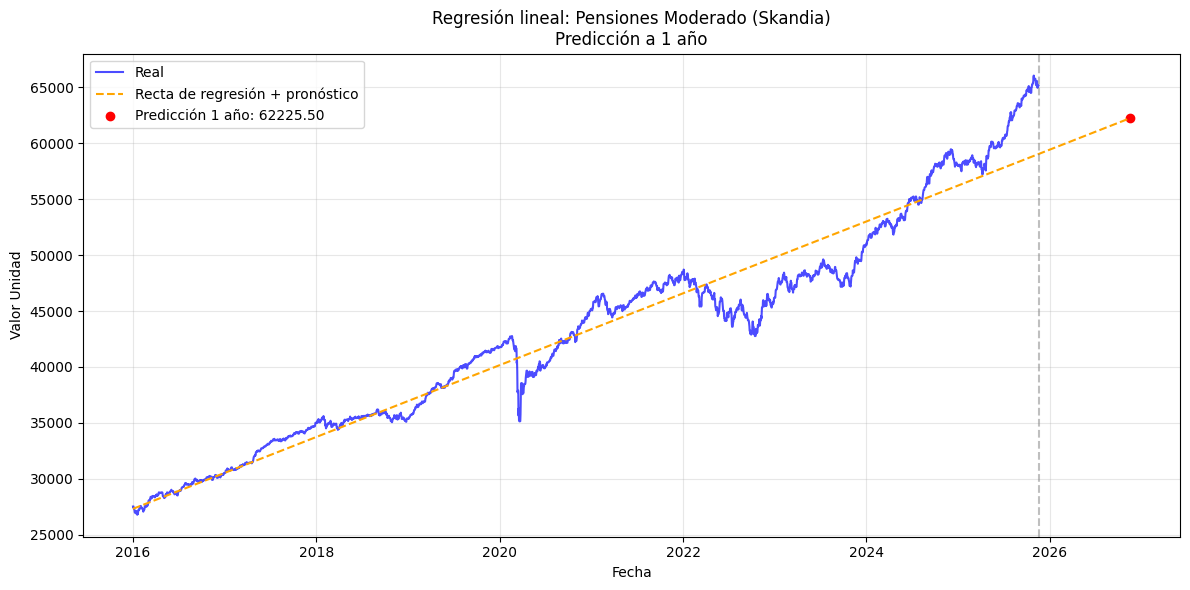

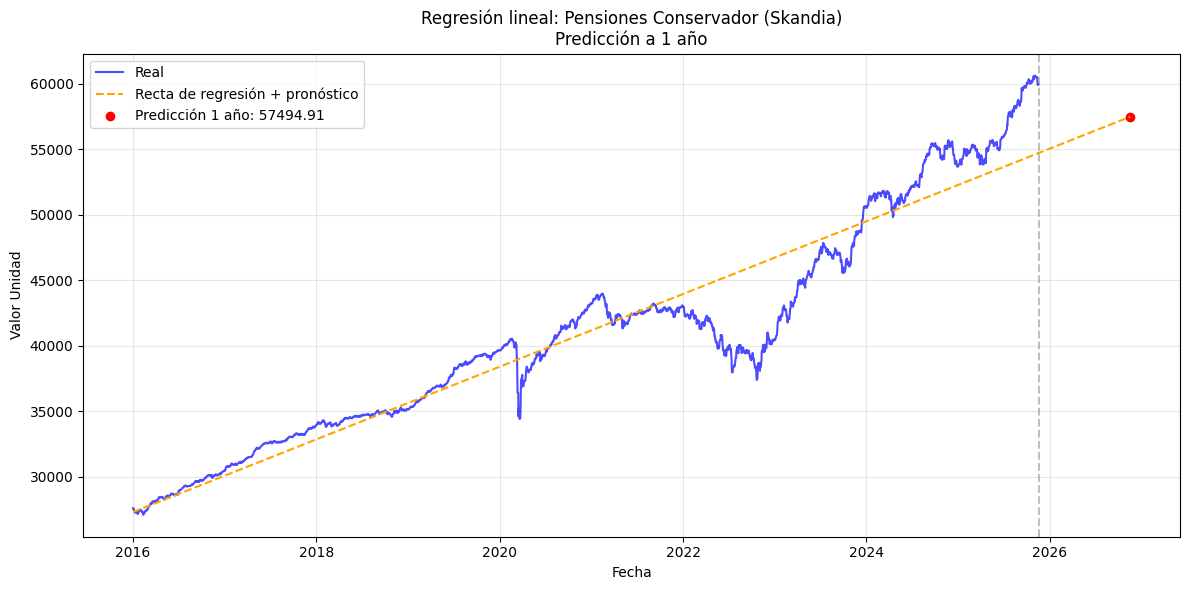

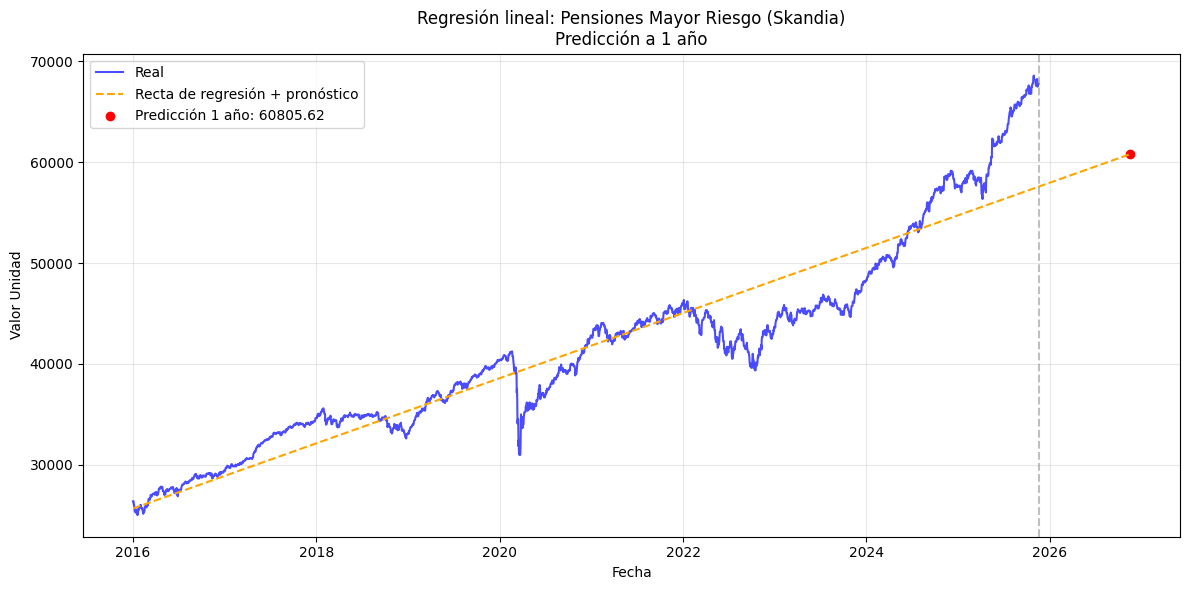

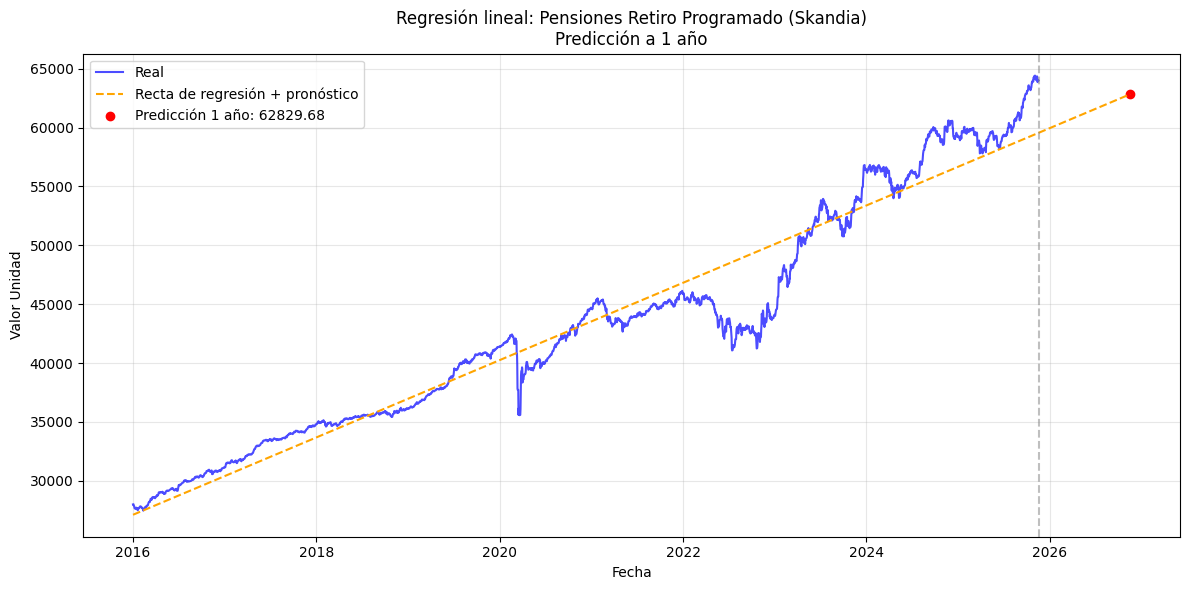

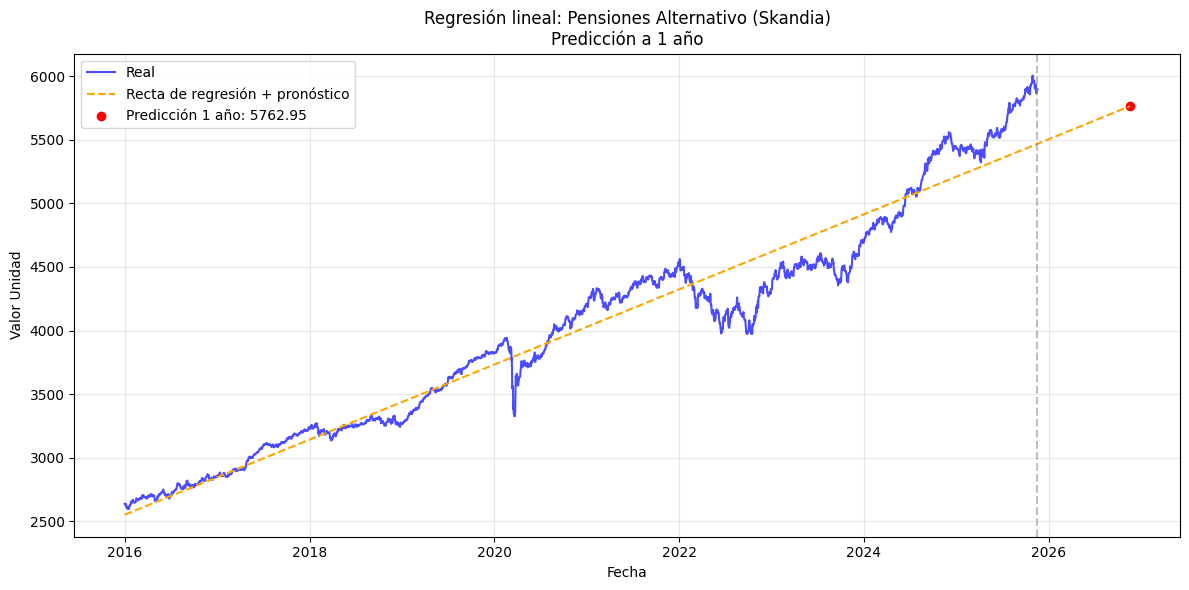


📈 PRONÓSTICOS A 1 AÑO (Regresión Lineal - Skandia):


MAE         RMSE  MAPE (%)  \
Cesantías Corto Plazo        1603.805861  1969.725909  4.093099   
Cesantías Largo Plazo        1368.546615  1885.263841  3.334753   
Pensiones Moderado           1571.541277  2121.249257  3.382488   
Pensiones Conservador        1656.116034  2406.523344  3.841786   
Pensiones Mayor Riesgo       2321.593071  3175.308884  5.257554   
Pensiones Retiro Programado  1580.804242  2200.085482  3.562944   
Pensiones Alternativo         145.567017   188.655775  3.394826   

                            Valor_predicho_1año Última_fecha Fecha_predicha  
Cesantías Corto Plazo              50582.075245   2025-11-17     2026-11-17  
Cesantías Largo Plazo              52711.752057   2025-11-17     2026-11-17  
Pensiones Moderado                 62225.503926   2025-11-17     2026-11-17  
Pensiones Conservador              57494.907211   2025-11-17     2026-11-17  
Pensiones Mayor Riesgo             60805.617385   2025-11-17     2026-11-17  
Pensiones Retiro Programado        62829.680879   2025-11-17     2026-11-17  
Pensiones Alternativo               5762.948042   2025-11-17     2026-11-17


✓ Resultados guardados en: /home/wolfang-sanchez/Documents/proyecto/data/modelos/predicciones_skandia_1ano.csv


In [169]:

fondos_skandia = {
    "Cesantías Corto Plazo": df_skandia_cesantias_corto_plazo,
    "Cesantías Largo Plazo": df_skandia_cesantias_largo_plazo,
    "Pensiones Moderado": df_skandia_pensiones_moderado,
    "Pensiones Conservador": df_skandia_pensiones_conservador,
    "Pensiones Mayor Riesgo": df_skandia_pensiones_mayor_riesgo,
    "Pensiones Retiro Programado": df_skandia_pensiones_retiro_programado,
    "Pensiones Alternativo": df_skandia_pensiones_alternativo
}

resultados_skandia = {}
for nombre_fondo, df_fondo in fondos_skandia.items():
    if len(df_fondo) < 30:
        print(f"⚠️ Fondo '{nombre_fondo}' tiene muy pocos datos. Se omite.")
        continue
    df_temp = df_fondo[['fecha', 'valor_unidad']].dropna().sort_values('fecha').copy()
    t0 = df_temp['fecha'].min()
    X = (df_temp['fecha'] - t0).dt.days.values.reshape(-1, 1)
    y = df_temp['valor_unidad'].values
    modelo = LinearRegression()
    modelo.fit(X, y)
    y_fit = modelo.predict(X)
    ultima_fecha = df_temp['fecha'].max()
    fecha_futura = ultima_fecha + pd.Timedelta(days=365)
    dias_futuros = np.array([(fecha_futura - t0).days]).reshape(-1, 1)
    pred_futuro = modelo.predict(dias_futuros)[0]
    fechas_linea = pd.date_range(start=t0, end=fecha_futura, freq='D')
    X_linea = ((fechas_linea - t0).days.values).reshape(-1, 1)
    y_linea = modelo.predict(X_linea)
    mae = mean_absolute_error(y, y_fit)
    rmse = np.sqrt(mean_squared_error(y, y_fit))
    mape = np.mean(np.abs((y - y_fit) / y)) * 100
    resultados_skandia[nombre_fondo] = {
        "MAE": mae,
        "RMSE": rmse,
        "MAPE (%)": mape,
        "Valor_predicho_1año": pred_futuro,
        "Última_fecha": ultima_fecha.strftime('%Y-%m-%d'),
        "Fecha_predicha": fecha_futura.strftime('%Y-%m-%d')
    }
    plt.figure(figsize=(12, 6))
    plt.plot(df_temp['fecha'], df_temp['valor_unidad'], label='Real', color='blue', alpha=0.7)
    plt.plot(fechas_linea, y_linea, '--', label='Recta de regresión + pronóstico', color='orange')
    plt.axvline(ultima_fecha, color='gray', linestyle='--', alpha=0.5)
    plt.scatter(fecha_futura, pred_futuro, color='red', label=f'Predicción 1 año: {pred_futuro:.2f}')
    plt.title(f"Regresión lineal: {nombre_fondo} (Skandia)\nPredicción a 1 año")
    plt.xlabel("Fecha"); plt.ylabel("Valor Unidad"); plt.legend(); plt.grid(True, alpha=0.3)
    plt.tight_layout()
    out_path = GRAFICAS_MODEL_DIR / f"reg_lineal_skandia_{nombre_fondo.replace(' ', '_').lower()}.png"
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

if resultados_skandia:
    df_resultados_skandia = pd.DataFrame(resultados_skandia).T
    out_csv = MODELOS_DIR / "predicciones_skandia_1ano.csv"
    df_resultados_skandia.to_csv(out_csv, encoding='utf-8')
    print("\n📈 PRONÓSTICOS A 1 AÑO (Regresión Lineal - Skandia):")
    display(df_resultados_skandia.round(2))
    print(f"\n✓ Resultados guardados en: {out_csv}")


## 20. IPC Colombia vs Fondo Moderado (Base 100 común)
Normalizamos ambas series desde 2016 para comparar poder adquisitivo vs desempeño del fondo.

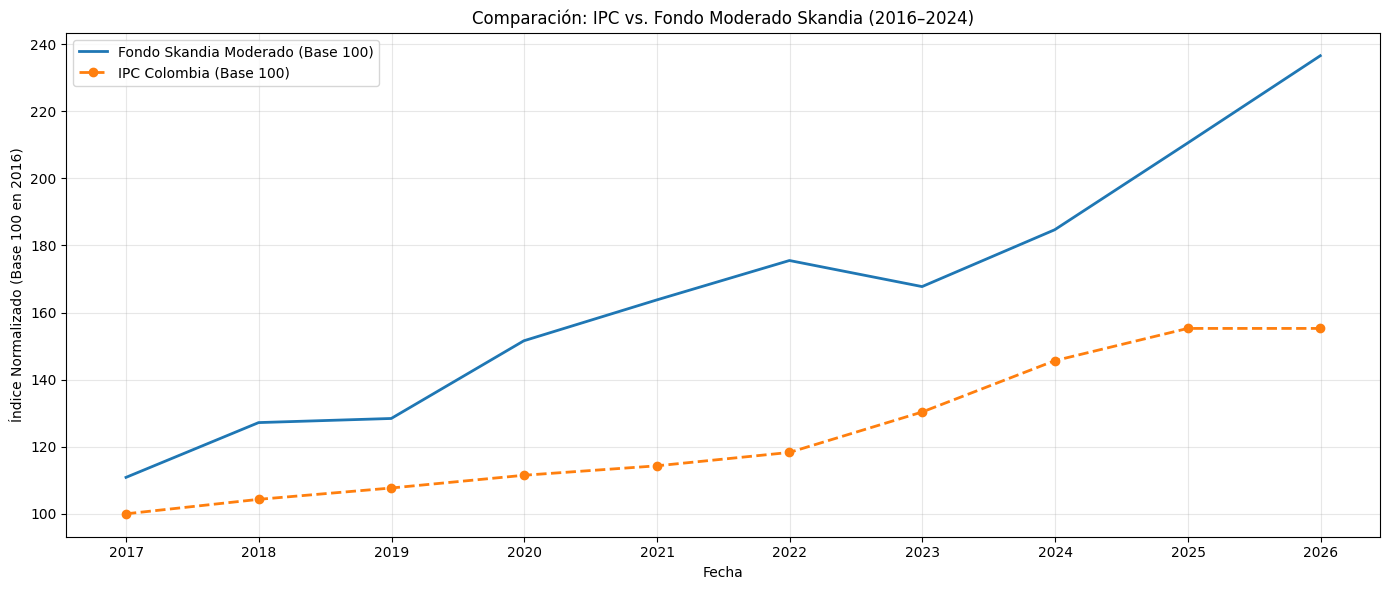

✓ Gráfica guardada en: /home/wolfang-sanchez/Documents/proyecto/data/graficas_comparativas/ipc_vs_skandia_moderado.png
Rangos utilizados -> IPC: 2016-12-31 a 2024-12-31 | Skandia anual: 2016-12-31 a 2025-12-31
Vista previa de la tabla combinada:


IPC (base=100)  Skandia Moderado (base=100)
2021-12-31      118.300761                   175.505540
2022-12-31      130.340503                   167.732870
2023-12-31      145.637140                   184.671780
2024-12-31      155.262424                   210.525712
2025-12-31      155.262424                   236.543564

In [170]:

import re
ipc_csv = DATA_DIR / 'API_FP.CPI.TOTL_DS2_es_csv_v2_59981.csv'
ipc_raw = pd.read_csv(ipc_csv, skiprows=4)
col_country = next(c for c in ipc_raw.columns if c.lower().startswith(("country name", "nombre del país", "nombre del pais")))
ipc_col = ipc_raw.loc[ipc_raw[col_country].str.lower() == "colombia"].copy()

def es_col_anio(c):
    return re.match(r"^\d{4}($|\s|\[)", str(c)) is not None

year_cols = [c for c in ipc_col.columns if es_col_anio(c)]
rename_map = {c: int(re.match(r"^(\d{4})", str(c)).group(1)) for c in year_cols}
ipc_col = ipc_col[year_cols].rename(columns=rename_map)
ipc_col = ipc_col.apply(pd.to_numeric, errors="coerce")
anio_ini, anio_fin_deseado = 2016, 2025
anios_disp = sorted(ipc_col.columns.dropna())
if not anios_disp:
    raise ValueError("No se detectaron columnas de años numéricos en el CSV del IPC.")
anio_fin = min(anio_fin_deseado, anios_disp[-1])
anios_sel = [a for a in anios_disp if anio_ini <= a <= anio_fin]
ipc_series = ipc_col.loc[:, anios_sel].T.squeeze()
ipc_series.index = pd.to_datetime(ipc_series.index.astype(str) + "-12-31")
ipc_series.name = "IPC Colombia (Base 100)"
sk_mod = df_skandia_pensiones_moderado.set_index("fecha")["valor_unidad"].sort_index()

def base100(s):
    s = s.dropna()
    return s / s.iloc[0] * 100

sk_b100_diario = base100(sk_mod[sk_mod.index >= "2016-01-01"])
sk_b100_anual = sk_b100_diario.resample('A-DEC').last()
ipc_b100 = base100(ipc_series[ipc_series.index >= "2016-01-01"])
cmp = pd.concat([
    ipc_b100.rename("IPC (base=100)"),
    sk_b100_anual.rename("Skandia Moderado (base=100)")
], axis=1).sort_index().interpolate(limit_direction="both")

plt.figure(figsize=(14, 6))
plt.plot(cmp.index, cmp["Skandia Moderado (base=100)"], label="Fondo Skandia Moderado (Base 100)", linewidth=2)
plt.plot(cmp.index, cmp["IPC (base=100)"], "--", label="IPC Colombia (Base 100)", linewidth=2, marker="o")
plt.title(f"Comparación: IPC vs. Fondo Moderado Skandia (2016–{anio_fin})")
plt.xlabel("Fecha"); plt.ylabel("Índice Normalizado (Base 100 en 2016)")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
out_cmp = GRAFICAS_COMP_DIR / 'ipc_vs_skandia_moderado.png'
plt.savefig(out_cmp, dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print(f"✓ Gráfica guardada en: {out_cmp}")
print("Rangos utilizados -> IPC:", ipc_b100.index.min().date(), "a", ipc_b100.index.max().date(),
      "| Skandia anual:", sk_b100_anual.index.min().date(), "a", sk_b100_anual.index.max().date())
print("Vista previa de la tabla combinada:")
display(cmp.tail())


## 21. IPC vs todos los fondos Skandia
Generamos una gráfica por fondo combinando su versión anual (base 100) y la serie diaria normalizada.

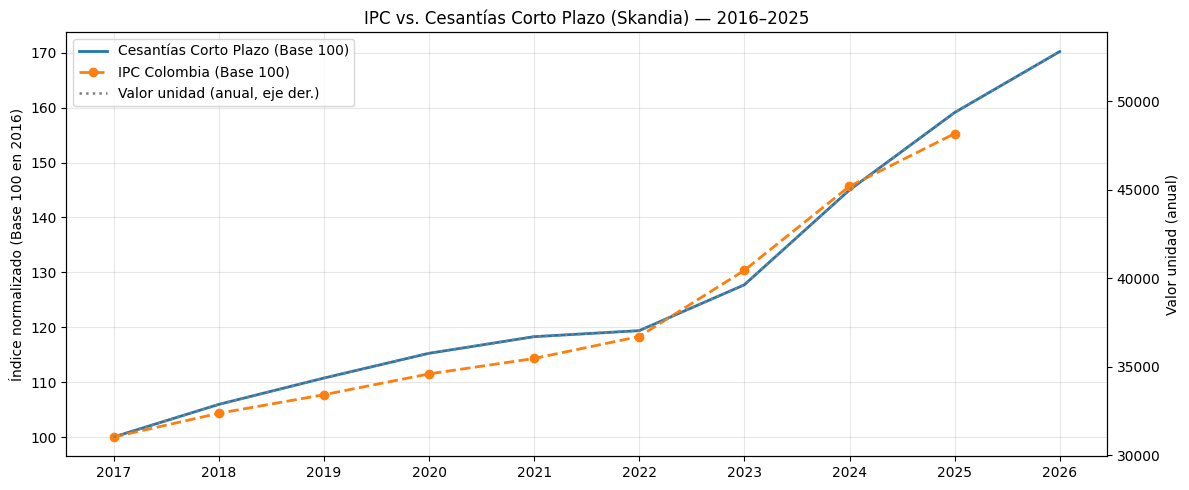

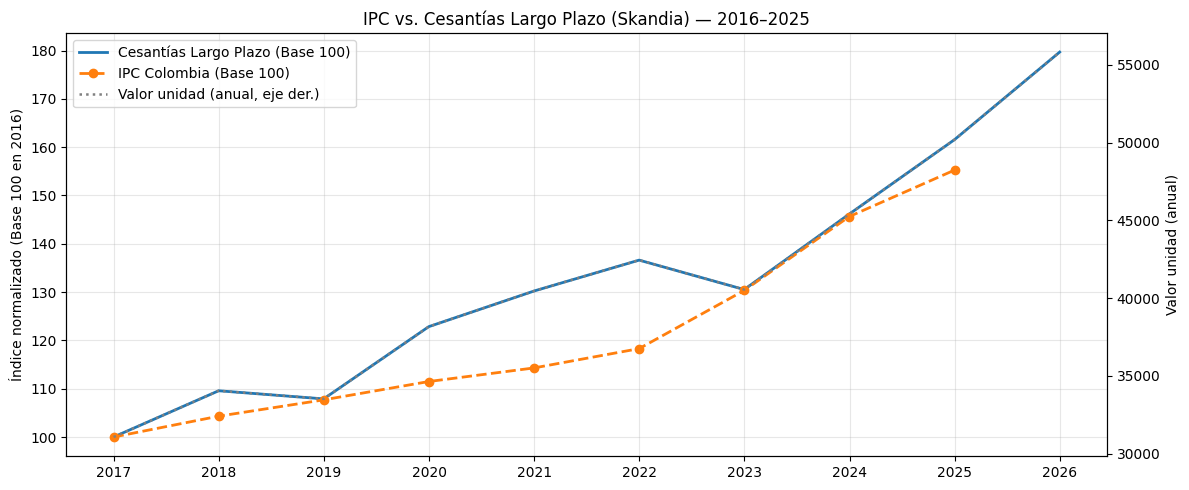

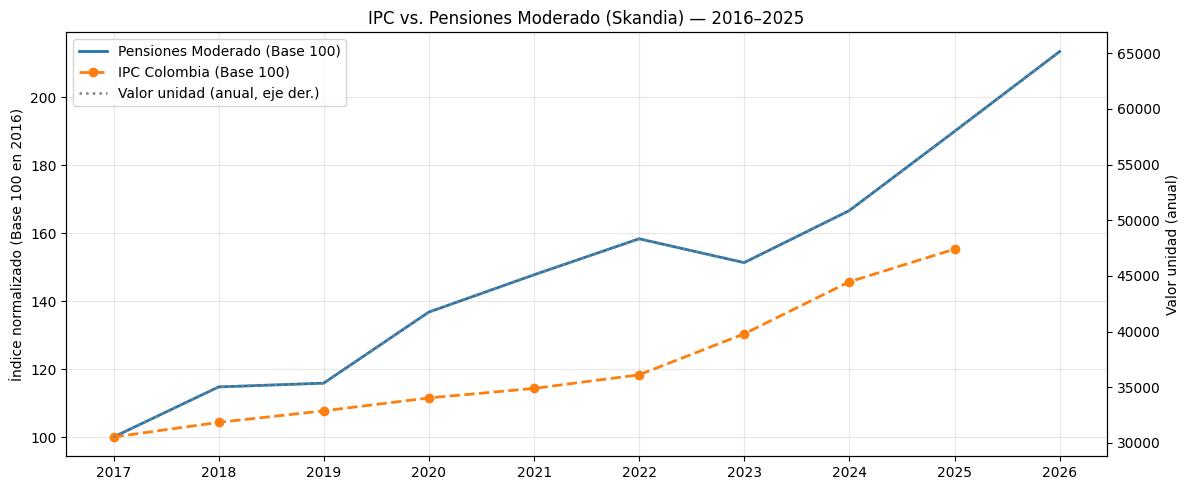

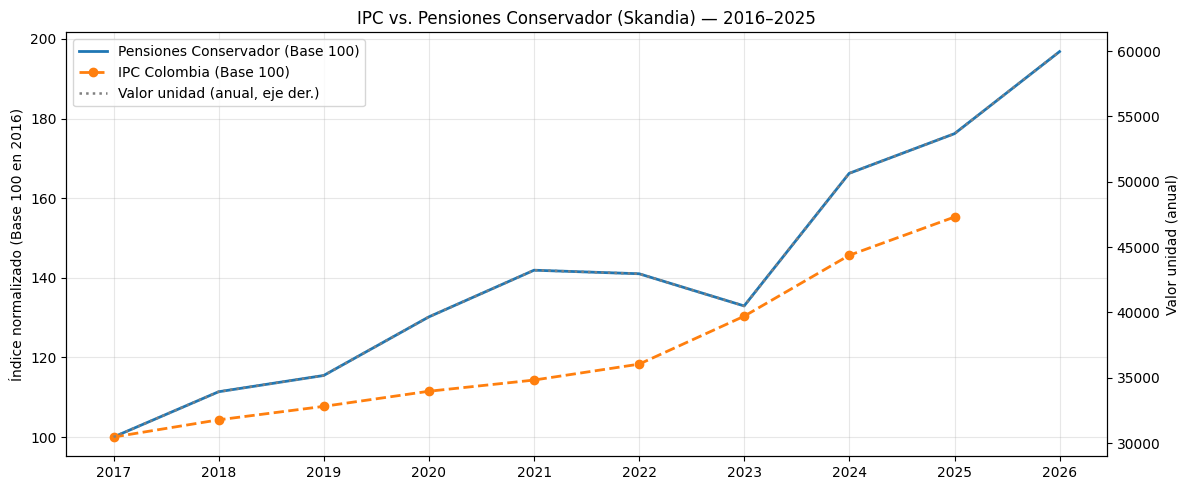

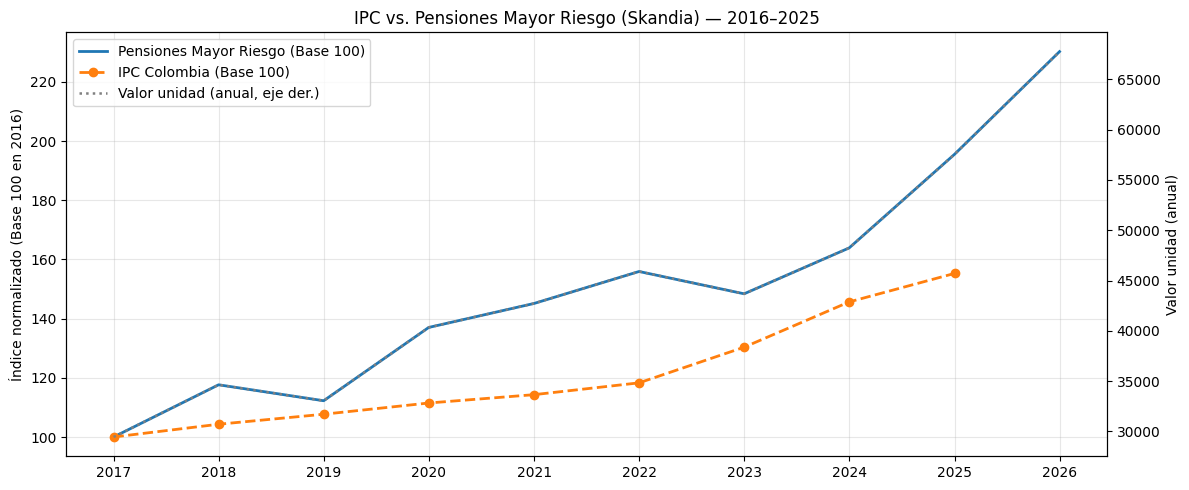

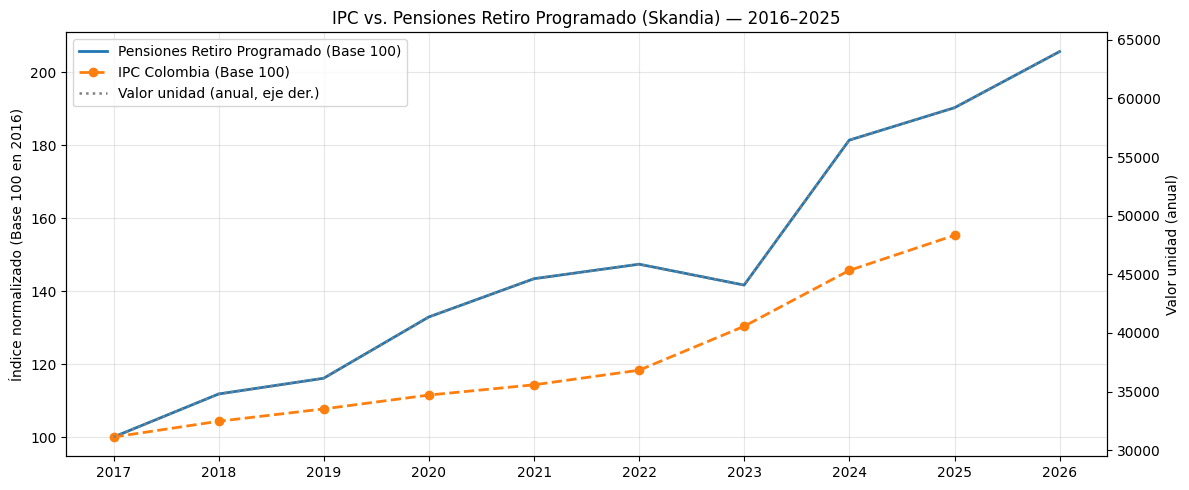

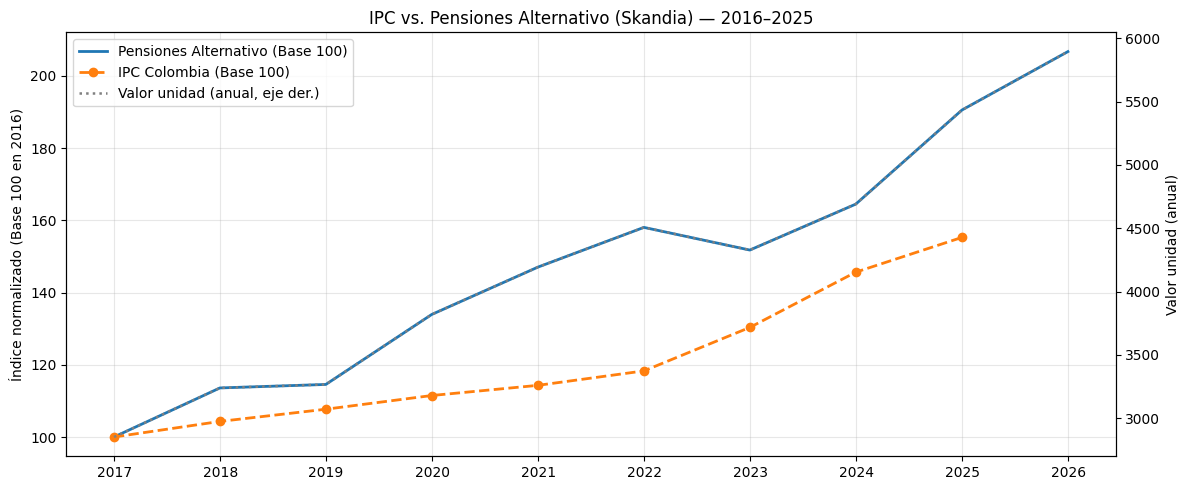

✓ Gráficas por fondo guardadas:
  - /home/wolfang-sanchez/Documents/proyecto/data/graficas_comparativas/ipc_vs_skandia_cesantias_corto_plazo.png
  - /home/wolfang-sanchez/Documents/proyecto/data/graficas_comparativas/ipc_vs_skandia_cesantias_largo_plazo.png
  - /home/wolfang-sanchez/Documents/proyecto/data/graficas_comparativas/ipc_vs_skandia_pensiones_moderado.png
  - /home/wolfang-sanchez/Documents/proyecto/data/graficas_comparativas/ipc_vs_skandia_pensiones_conservador.png
  - /home/wolfang-sanchez/Documents/proyecto/data/graficas_comparativas/ipc_vs_skandia_pensiones_mayor_riesgo.png
  - /home/wolfang-sanchez/Documents/proyecto/data/graficas_comparativas/ipc_vs_skandia_pensiones_retiro_programado.png
  - /home/wolfang-sanchez/Documents/proyecto/data/graficas_comparativas/ipc_vs_skandia_pensiones_alternativo.png


In [171]:

ipc_b100 = base100(ipc_series[ipc_series.index >= "2016-01-01"]).rename("IPC (base=100)")

def _slug(texto):
    return (texto.lower()
            .replace("á","a").replace("é","e").replace("í","i")
            .replace("ó","o").replace("ú","u").replace("ñ","n")
            .replace(" ", "_"))

salidas = []
for nombre, dff in fondos_skandia.items():
    if dff is None or dff.empty:
        print(f"⚠️  Sin datos para: {nombre}")
        continue
    s = dff.set_index("fecha")["valor_unidad"].sort_index().dropna()
    s = s[s.index >= "2016-01-01"]
    if s.empty:
        print(f"⚠️  Sin datos (>=2016) para: {nombre}")
        continue
    s_anual = s.resample("A-DEC").last()
    s_b100a = base100(s_anual).rename(f"{nombre} (base=100)")
    cmp = pd.concat([ipc_b100, s_b100a], axis=1).sort_index()
    plt.figure(figsize=(12, 5))
    ax = plt.gca()
    ax.plot(cmp.index, cmp[f"{nombre} (base=100)"], label=f"{nombre} (Base 100)", linewidth=2)
    ax.plot(cmp.index, cmp["IPC (base=100)"], "--", label="IPC Colombia (Base 100)", linewidth=2, marker="o")
    ax.set_ylabel("Índice normalizado (Base 100 en 2016)"); ax.grid(True, alpha=0.3)
    ax2 = ax.twinx()
    ax2.plot(s_anual.index, s_anual.values, ":", linewidth=1.8, color="gray", label="Valor unidad (anual, eje der.)")
    ax2.set_ylabel("Valor unidad (anual)")
    anio_fin_local = max(ipc_b100.index.year.max(), s_anual.index.year.max())
    plt.title(f"IPC vs. {nombre} (Skandia) — 2016–{anio_fin_local}")
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h1 + h2, l1 + l2, loc="upper left")
    plt.tight_layout()
    out = GRAFICAS_COMP_DIR / f"ipc_vs_skandia_{_slug(nombre)}.png"
    plt.savefig(out, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
    salidas.append(out)

print("✓ Gráficas por fondo guardadas:")
for p in salidas:
    print("  -", p)


## 22. Cesantías Corto Plazo (todas las entidades) vs IPC
Construimos índices base 100 con la misma malla temporal 2016–2024 para comparar desempeño relativo.

Skandia  Protección    Porvenir   Colfondos         IPC
Año                                                             
2016  100.000000  100.000000  100.000000  100.000000  100.000000
2017  105.935117  106.168421  106.197573  105.779974  104.314313
2018  110.727058  110.703998  110.315028  109.761597  107.694691
2019  115.242907  115.037417  114.510331  113.972960  111.488796
2020  118.276669  118.639902  117.630666  116.706276  114.305711

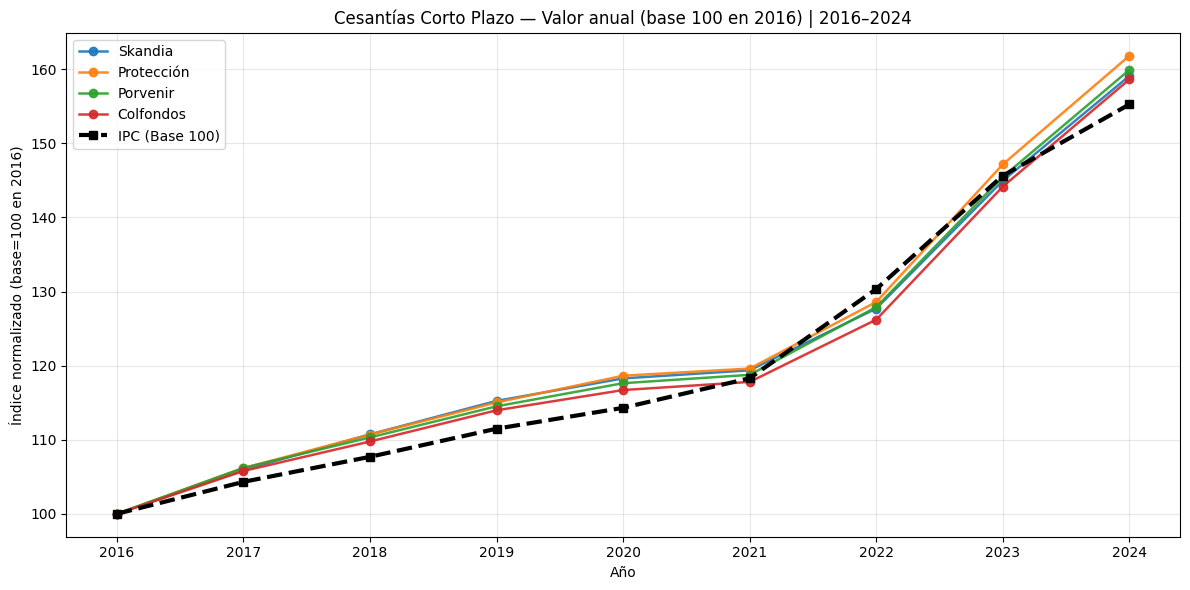

✓ Gráfica guardada: /home/wolfang-sanchez/Documents/proyecto/data/graficas_comparativas/cesantias_corto_plazo_valor_anual_base100_2016_2024.png
✓ Tabla guardada en: /home/wolfang-sanchez/Documents/proyecto/data/modelos/cesantias_corto_plazo_valor_anual_base100_2016_2024.csv
Año base común utilizado: 2016


In [172]:

def _valor_anual_base100(df_fondo, nombre):
    if df_fondo is None or len(df_fondo) == 0:
        print(f"⚠️  Sin datos para: {nombre}")
        return None
    s = (df_fondo.dropna(subset=['fecha','valor_unidad']).set_index('fecha')['valor_unidad'].sort_index())
    s_anual = s.resample('A-DEC').last()
    s_anual = s_anual[s_anual.index.year <= 2024]
    if s_anual.empty:
        print(f"⚠️  Serie anual vacía (<=2024) para: {nombre}")
        return None
    s_anual.index = s_anual.index.year
    s_anual.name = nombre
    return s_anual

ipc_anual_df = (
    ipc_series[ipc_series.index.year <= 2024]
    .rename("valor_unidad")
    .reset_index()
    .rename(columns={"index": "fecha"})
)

fondos_corto_dict = {
    "Skandia": df_skandia_cesantias_corto_plazo,
    "Protección": df_proteccion_cesantias_corto_plazo,
    "Porvenir": df_porvenir_cesantias_corto_plazo,
    "Colfondos": df_colfondos_cesantias_corto_plazo,
    "IPC": ipc_anual_df,
}

series_anuales = {}
for nombre, df_f in fondos_corto_dict.items():
    serie = _valor_anual_base100(df_f, nombre)
    if serie is not None:
        series_anuales[nombre] = serie

if not series_anuales:
    raise ValueError("No se generaron series anuales para ninguna entidad.")

anios_comunes = set.intersection(*[set(s.index) for s in series_anuales.values()])
anios_comunes = sorted([a for a in anios_comunes if 2016 <= a <= 2024])
if len(anios_comunes) < 2:
    raise ValueError(f"No hay años comunes suficientes. Años comunes: {anios_comunes}")

anio_base = anios_comunes[0]

def _base100_mismo_base(s, base_year, anios):
    s = s.loc[anios].copy()
    base_val = s.loc[base_year]
    return (s / base_val) * 100

series_norm = {nombre: _base100_mismo_base(s, anio_base, anios_comunes) for nombre, s in series_anuales.items()}
df_norm = pd.DataFrame(series_norm)
df_norm.index.name = "Año"
display(df_norm.head())

plt.figure(figsize=(12, 6))
for nombre in df_norm.columns:
    if nombre != "IPC":
        plt.plot(df_norm.index, df_norm[nombre], marker='o', linewidth=1.8, alpha=0.9, label=nombre)
if "IPC" in df_norm.columns:
    plt.plot(df_norm.index, df_norm["IPC"], linestyle='--', linewidth=3.0, marker='s', color='black', label='IPC (Base 100)', zorder=10)
plt.title(f"Cesantías Corto Plazo — Valor anual (base 100 en {anio_base}) | 2016–{anios_comunes[-1]}")
plt.xlabel("Año"); plt.ylabel(f"Índice normalizado (base=100 en {anio_base})")
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
out_png = GRAFICAS_COMP_DIR / 'cesantias_corto_plazo_valor_anual_base100_2016_2024.png'
plt.savefig(out_png, dpi=300, bbox_inches="tight")
plt.show()
plt.close()
out_csv = MODELOS_DIR / 'cesantias_corto_plazo_valor_anual_base100_2016_2024.csv'
df_norm.round(2).to_csv(out_csv, encoding="utf-8")
print(f"✓ Gráfica guardada: {out_png}")
print(f"✓ Tabla guardada en: {out_csv}")
print(f"Año base común utilizado: {anio_base}")


## 23. Modelado SARIMA en niveles
Implementamos un flujo que asegura periodicidad mensual, valida contra un bloque de prueba y proyecta 12 meses.

✓ Cesantías Corto Plazo - Skandia: Mejor SARIMA(2, 1, 2)x(0, 1, 1, 12) AIC=736.37
Resultados 'Cesantías Corto Plazo - Skandia' (TEST 2023-12-31 → 2025-11-30):
  MAE=3316.0705  RMSE=4178.9101  MAPE=6.53%


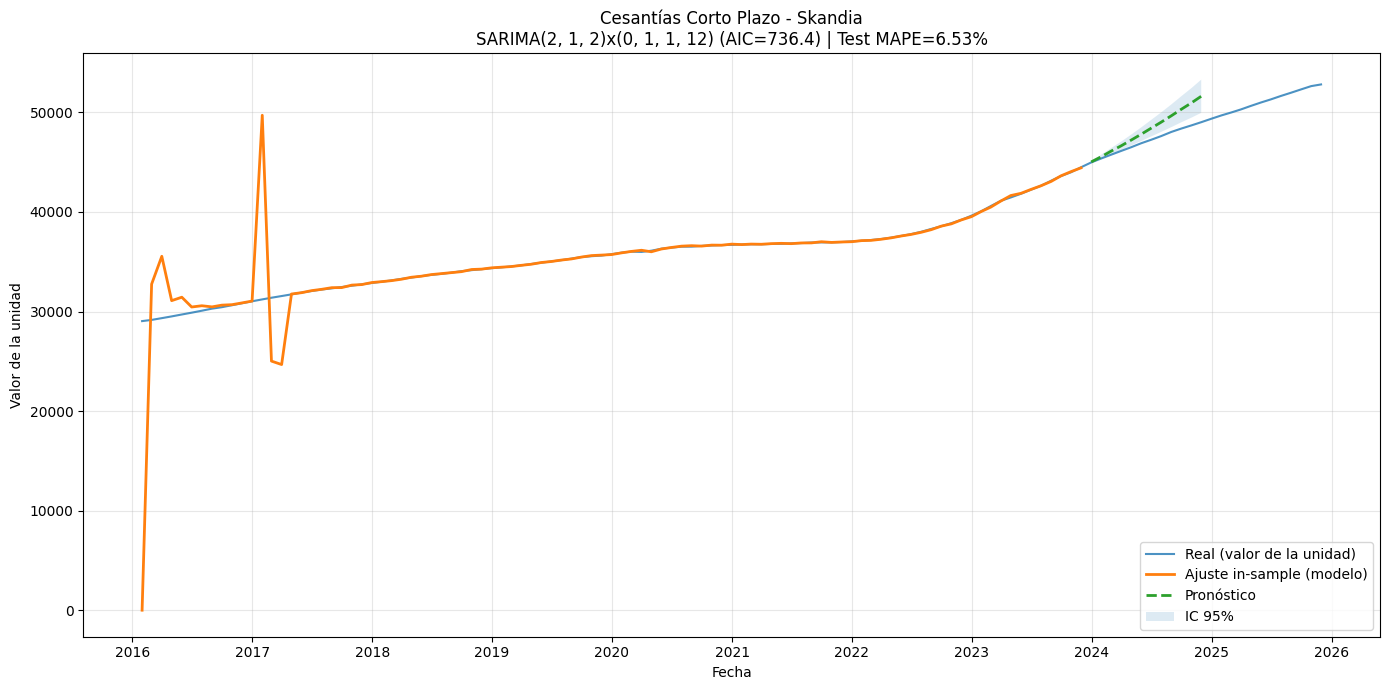

✓ Gráfica guardada: /home/wolfang-sanchez/Documents/proyecto/data/graficas_modelado/sarima_cesantías_corto_plazo_-_skandia.png
✓ Cesantías Corto Plazo - Protección: Mejor SARIMA(2, 1, 2)x(1, 1, 1, 12) AIC=726.25
Resultados 'Cesantías Corto Plazo - Protección' (TEST 2023-12-31 → 2025-11-30):
  MAE=2085.4530  RMSE=2954.9039  MAPE=4.95%


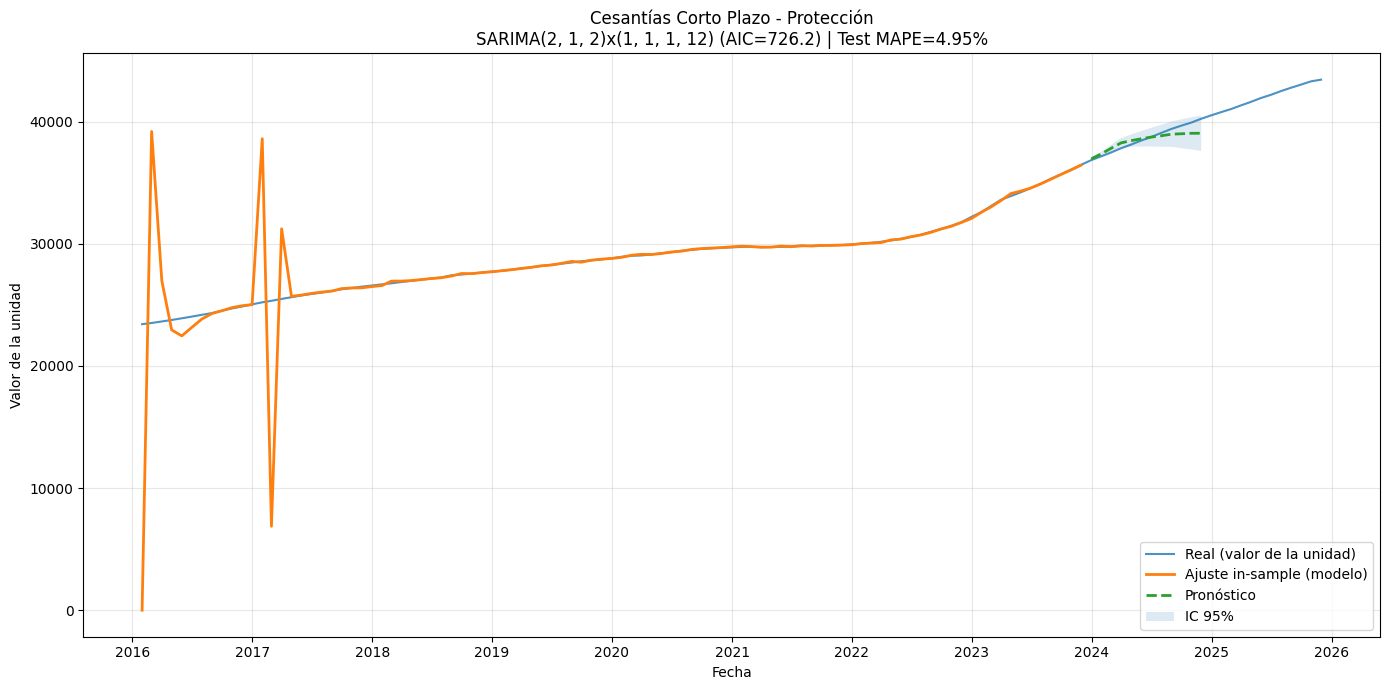

✓ Gráfica guardada: /home/wolfang-sanchez/Documents/proyecto/data/graficas_modelado/sarima_cesantías_corto_plazo_-_protección.png
✓ Cesantías Corto Plazo - Porvenir: Mejor SARIMA(2, 1, 2)x(1, 1, 1, 12) AIC=714.19
Resultados 'Cesantías Corto Plazo - Porvenir' (TEST 2023-12-31 → 2025-11-30):
  MAE=2858.8399  RMSE=3595.2161  MAPE=6.08%


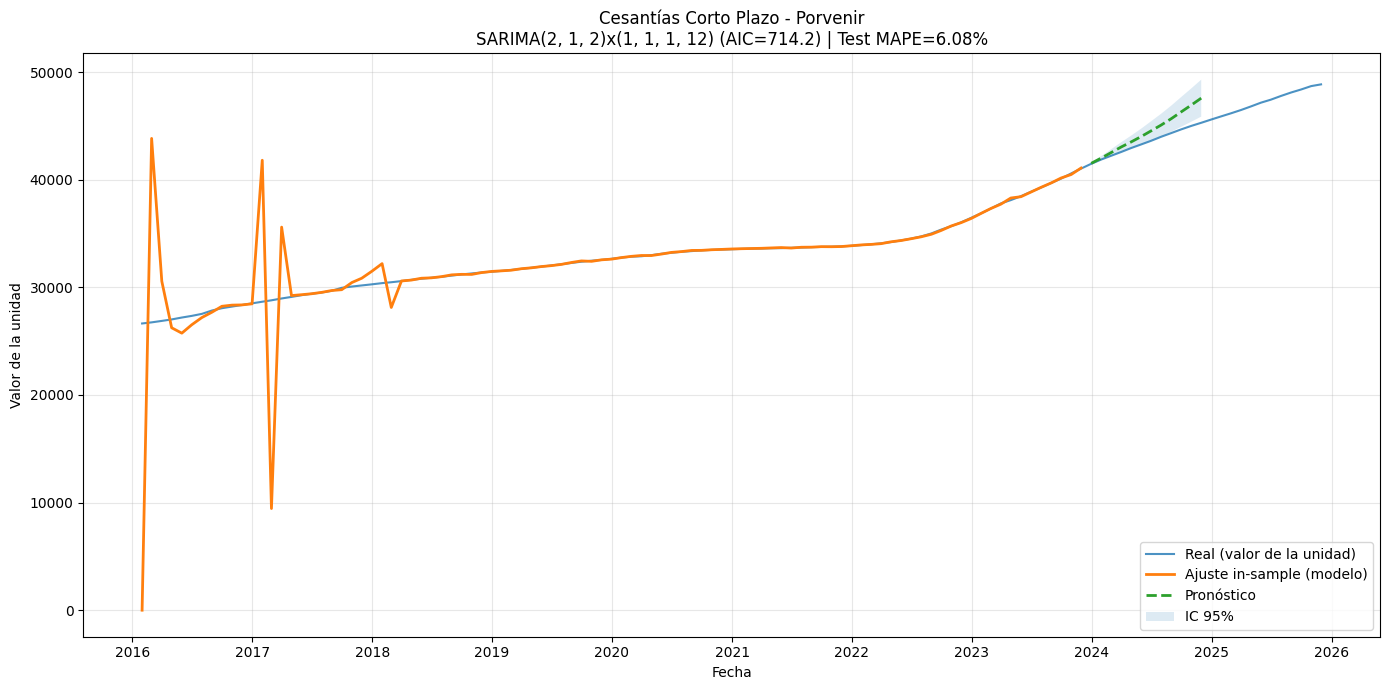

✓ Gráfica guardada: /home/wolfang-sanchez/Documents/proyecto/data/graficas_modelado/sarima_cesantías_corto_plazo_-_porvenir.png
✓ Cesantías Corto Plazo - Colfondos: Mejor SARIMA(2, 1, 2)x(0, 1, 1, 12) AIC=700.38
Resultados 'Cesantías Corto Plazo - Colfondos' (TEST 2023-12-31 → 2025-11-30):
  MAE=3216.0516  RMSE=4112.9893  MAPE=8.50%


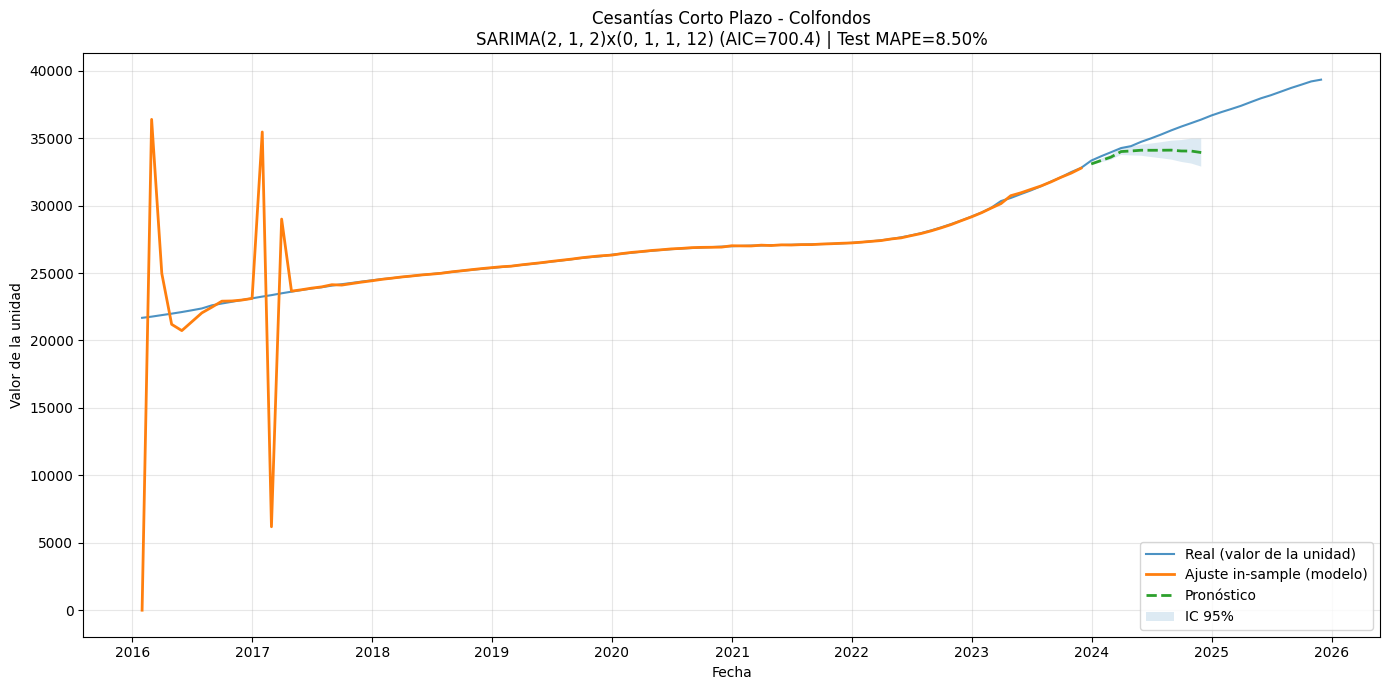

✓ Gráfica guardada: /home/wolfang-sanchez/Documents/proyecto/data/graficas_modelado/sarima_cesantías_corto_plazo_-_colfondos.png


In [173]:

import warnings
warnings.filterwarnings("ignore")

def _ensure_monthly_close(df, col_fecha='fecha', col_valor='valor_unidad'):
    s = (
        df[[col_fecha, col_valor]]
        .dropna()
        .sort_values(col_fecha)
        .drop_duplicates(subset=[col_fecha])
        .set_index(col_fecha)[col_valor]
        .astype(float)
        .sort_index()
    )
    s_m = s.resample('M').last().asfreq('M')
    return s_m.ffill()

def _mape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def _grid_search_sarima(y, pdq_grid, seasonal_pdq_grid, trend='c'):
    best = {'aic': np.inf, 'order': None, 'seasonal_order': None, 'model': None}
    for order in pdq_grid:
        for sorder in seasonal_pdq_grid:
            try:
                m = SARIMAX(y, order=order, seasonal_order=sorder, trend=trend,
                            enforce_stationarity=False, enforce_invertibility=False)
                res = m.fit(disp=False)
                if res.aic < best['aic']:
                    best = {'aic': res.aic, 'order': order, 'seasonal_order': sorder, 'model': res}
            except Exception:
                continue
    return best

def _plot_fit_vs_real(y, fit_in, fc, fc_ci, titulo, out_png):
    plt.figure(figsize=(14, 7))
    plt.plot(y.index, y.values, label='Real (valor de la unidad)', alpha=0.8)
    if fit_in is not None:
        plt.plot(fit_in.index, fit_in.values, label='Ajuste in-sample (modelo)', linewidth=2)
    if fc is not None:
        plt.plot(fc.index, fc.values, '--', label='Pronóstico', linewidth=2)
        if fc_ci is not None:
            plt.fill_between(fc_ci.index, fc_ci.iloc[:, 0], fc_ci.iloc[:, 1], alpha=0.15, label='IC 95%')
    plt.title(titulo)
    plt.xlabel('Fecha'); plt.ylabel('Valor de la unidad')
    plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def entrenar_y_graficar_sarima(df_serie, nombre_serie,
                               meses_test=24, pasos_forecast=12,
                               pdq=((0,0,0),(1,0,0),(0,1,1),(1,1,1),(2,1,2)),
                               spdq=((0,0,0,12),(1,0,0,12),(0,1,1,12),(1,1,1,12))):
    y = _ensure_monthly_close(df_serie, 'fecha', 'valor_unidad')
    if len(y) < (meses_test + 36):
        print(f"⚠️ Serie '{nombre_serie}' es muy corta para validar (len={len(y)}). Se omite.")
        return None
    y_train = y.iloc[:-meses_test]
    y_test = y.iloc[-meses_test:]
    best = _grid_search_sarima(y_train, list(pdq), list(spdq), trend='c')
    if best['model'] is None:
        print(f"✗ No se encontró modelo para '{nombre_serie}'.")
        return None
    order, sorder, res = best['order'], best['seasonal_order'], best['model']
    print(f"✓ {nombre_serie}: Mejor SARIMA{order}x{sorder} AIC={best['aic']:.2f}")
    pred = res.get_prediction(start=y_test.index[0], end=y_test.index[-1], dynamic=False)
    y_pred = pred.predicted_mean
    mae = np.mean(np.abs(y_test - y_pred))
    rmse = np.sqrt(np.mean((y_test - y_pred)**2))
    mape = _mape(y_test.values, y_pred.values)
    print(f"Resultados '{nombre_serie}' (TEST {y_test.index[0].date()} → {y_test.index[-1].date()}):")
    print(f"  MAE={mae:.4f}  RMSE={rmse:.4f}  MAPE={mape:.2f}%")
    fc_res = res.get_forecast(steps=pasos_forecast)
    fc = fc_res.predicted_mean
    fc_ci = fc_res.conf_int()
    titulo = (f"{nombre_serie}\nSARIMA{order}x{sorder} (AIC={best['aic']:.1f}) | Test MAPE={mape:.2f}%")
    out_png = GRAFICAS_MODEL_DIR / f"sarima_{nombre_serie.replace(' ','_').lower()}.png"
    _plot_fit_vs_real(y, res.fittedvalues, fc, fc_ci, titulo, out_png)
    print(f"✓ Gráfica guardada: {out_png}")
    pd.Series({
        'serie': nombre_serie,
        'order': str(order),
        'seasonal_order': str(sorder),
        'aic': best['aic'],
        'mae': mae,
        'rmse': rmse,
        'mape_%': mape,
        'train_ini': y_train.index[0].strftime('%Y-%m'),
        'train_fin': y_train.index[-1].strftime('%Y-%m'),
        'test_ini': y_test.index[0].strftime('%Y-%m'),
        'test_fin': y_test.index[-1].strftime('%Y-%m'),
        'forecast_steps': pasos_forecast
    }).to_csv(MODELOS_DIR / f"sarima_{nombre_serie.replace(' ','_').lower()}_metrics.csv")
    return {
        'nombre_serie': nombre_serie,
        'order': order,
        'seasonal_order': sorder,
        'aic': best['aic'],
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'fitted': res.fittedvalues,
        'forecast': fc,
        'forecast_ci': fc_ci,
        'y_train': y_train,
        'y_test': y_test,
        'y_all': y
    }

resultados_arima = {}
series_a_modelar_nuevas = {
    "Cesantías Corto Plazo - Skandia": df_skandia_cesantias_corto_plazo,
    "Cesantías Corto Plazo - Protección": df_proteccion_cesantias_corto_plazo,
    "Cesantías Corto Plazo - Porvenir": df_porvenir_cesantias_corto_plazo,
    "Cesantías Corto Plazo - Colfondos": df_colfondos_cesantias_corto_plazo,
}
for nombre, dfx in series_a_modelar_nuevas.items():
    if dfx is None or len(dfx) == 0:
        print(f"⚠️ Sin datos para {nombre}")
        continue
    try:
        res = entrenar_y_graficar_sarima(dfx, nombre)
        if res:
            resultados_arima[nombre] = res
    except Exception as exc:
        print(f"✗ Error modelando {nombre}: {exc}")


## 24. Diferenciación (ARIMA/SARIMA) — Colfondos Cesantías Largo Plazo
Mostramos la serie en niveles y sus diferencias sucesivas para justificar el orden `d`.


--- Estacionariedad Colfondos Cesantías Largo Plazo ---

--- Análisis de Estacionariedad: Colfondos CLP - Nivel ---
Estadístico ADF: 0.6452
P-valor: 0.9887
✗ La serie NO es estacionaria (p-valor > 0.05)
  Se recomienda diferenciar antes de modelar

--- Análisis de Estacionariedad: Colfondos CLP - Diferencia 1 (d=1) ---
Estadístico ADF: -11.3022
P-valor: 0.0000
✓ La serie ES estacionaria (p-valor < 0.05)

--- Análisis de Estacionariedad: Colfondos CLP - Diferencia 2 (d=2) ---
Estadístico ADF: -18.0217
P-valor: 0.0000
✓ La serie ES estacionaria (p-valor < 0.05)

--- Análisis de Estacionariedad: Colfondos CLP - Diferencia 3 (d=3) ---
Estadístico ADF: -23.3612
P-valor: 0.0000
✓ La serie ES estacionaria (p-valor < 0.05)


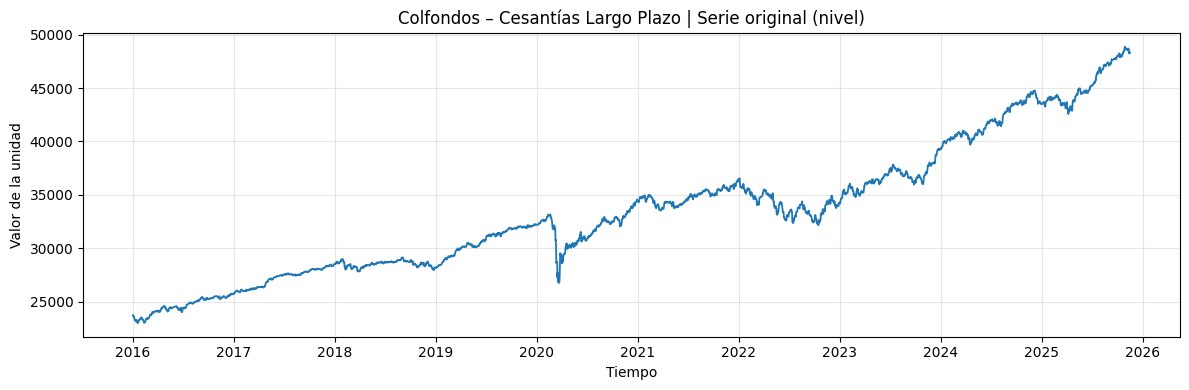

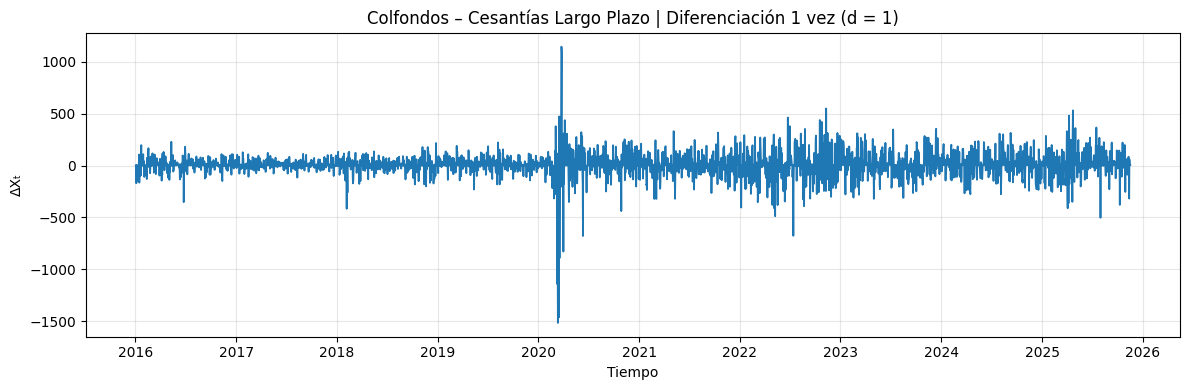

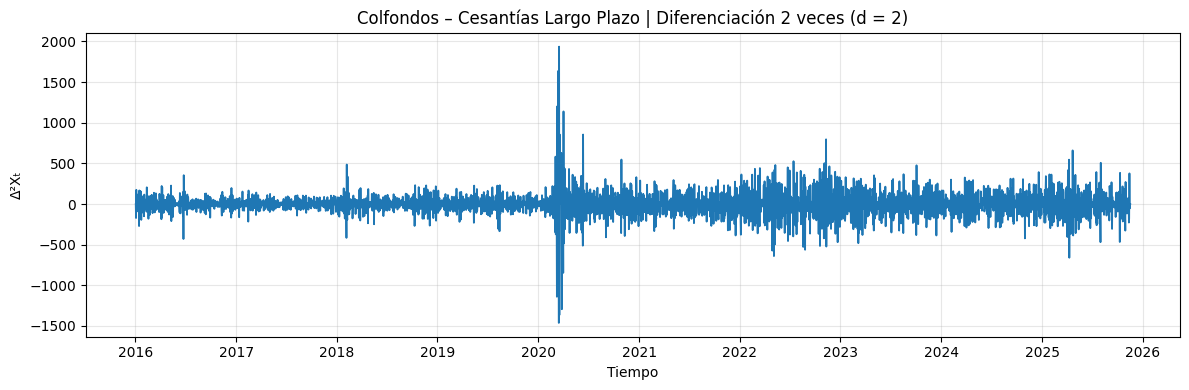

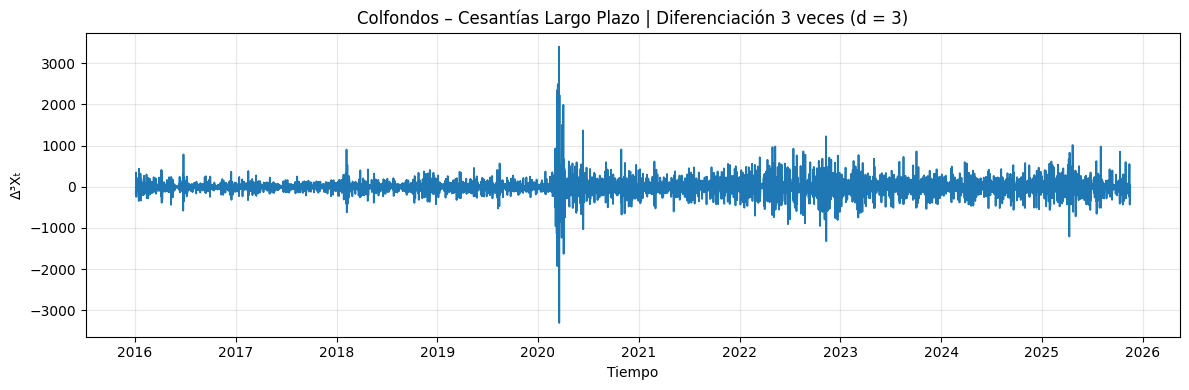

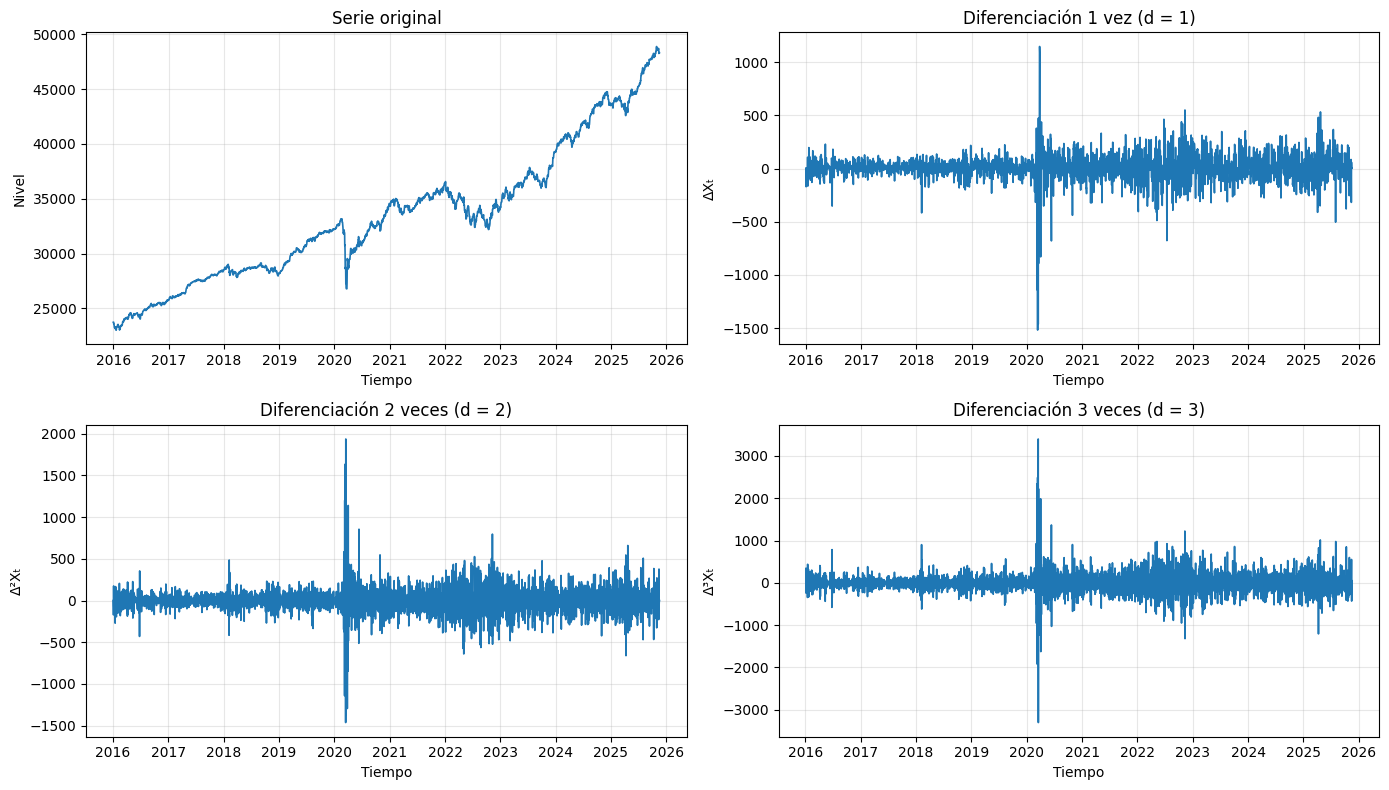

In [174]:

serie_colfondos_clp = (
    df_colfondos_cesantias_largo_plazo[['fecha', 'valor_unidad']]
    .dropna(subset=['fecha', 'valor_unidad'])
    .sort_values('fecha')
    .set_index('fecha')['valor_unidad']
    .astype(float)
)
serie_diff1 = serie_colfondos_clp.diff(1).dropna()
serie_diff2 = serie_diff1.diff(1).dropna()
serie_diff3 = serie_diff2.diff(1).dropna()

print("\n--- Estacionariedad Colfondos Cesantías Largo Plazo ---")
_ = analizar_estacionariedad(serie_colfondos_clp, "Colfondos CLP - Nivel")
_ = analizar_estacionariedad(serie_diff1, "Colfondos CLP - Diferencia 1 (d=1)")
_ = analizar_estacionariedad(serie_diff2, "Colfondos CLP - Diferencia 2 (d=2)")
_ = analizar_estacionariedad(serie_diff3, "Colfondos CLP - Diferencia 3 (d=3)")

GRAFICAS_MODEL_DIR.mkdir(parents=True, exist_ok=True)
plt.figure(figsize=(12, 4))
plt.plot(serie_colfondos_clp, linewidth=1.3)
plt.title("Colfondos – Cesantías Largo Plazo | Serie original (nivel)")
plt.xlabel("Tiempo"); plt.ylabel("Valor de la unidad"); plt.grid(True, alpha=0.3)
plt.tight_layout()
out_lvl = GRAFICAS_MODEL_DIR / 'colfondos_clp_nivel.png'
plt.savefig(out_lvl, dpi=300, bbox_inches="tight")
plt.show()
plt.close()

plt.figure(figsize=(12, 4))
plt.plot(serie_diff1, linewidth=1.3)
plt.title("Colfondos – Cesantías Largo Plazo | Diferenciación 1 vez (d = 1)")
plt.xlabel("Tiempo"); plt.ylabel("ΔXₜ"); plt.grid(True, alpha=0.3)
plt.tight_layout()
out_d1 = GRAFICAS_MODEL_DIR / 'colfondos_clp_diff1.png'
plt.savefig(out_d1, dpi=300, bbox_inches="tight")
plt.show()
plt.close()

plt.figure(figsize=(12, 4))
plt.plot(serie_diff2, linewidth=1.3)
plt.title("Colfondos – Cesantías Largo Plazo | Diferenciación 2 veces (d = 2)")
plt.xlabel("Tiempo"); plt.ylabel("Δ²Xₜ"); plt.grid(True, alpha=0.3)
plt.tight_layout()
out_d2 = GRAFICAS_MODEL_DIR / 'colfondos_clp_diff2.png'
plt.savefig(out_d2, dpi=300, bbox_inches="tight")
plt.show()
plt.close()

plt.figure(figsize=(12, 4))
plt.plot(serie_diff3, linewidth=1.3)
plt.title("Colfondos – Cesantías Largo Plazo | Diferenciación 3 veces (d = 3)")
plt.xlabel("Tiempo"); plt.ylabel("Δ³Xₜ"); plt.grid(True, alpha=0.3)
plt.tight_layout()
out_d3 = GRAFICAS_MODEL_DIR / 'colfondos_clp_diff3.png'
plt.savefig(out_d3, dpi=300, bbox_inches="tight")
plt.show()
plt.close()

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes[0, 0].plot(serie_colfondos_clp, linewidth=1.2)
axes[0, 0].set_title("Serie original"); axes[0, 0].set_xlabel("Tiempo"); axes[0, 0].set_ylabel("Nivel"); axes[0, 0].grid(True, alpha=0.3)
axes[0, 1].plot(serie_diff1, linewidth=1.2)
axes[0, 1].set_title("Diferenciación 1 vez (d = 1)"); axes[0, 1].set_xlabel("Tiempo"); axes[0, 1].set_ylabel("ΔXₜ"); axes[0, 1].grid(True, alpha=0.3)
axes[1, 0].plot(serie_diff2, linewidth=1.2)
axes[1, 0].set_title("Diferenciación 2 veces (d = 2)"); axes[1, 0].set_xlabel("Tiempo"); axes[1, 0].set_ylabel("Δ²Xₜ"); axes[1, 0].grid(True, alpha=0.3)
axes[1, 1].plot(serie_diff3, linewidth=1.2)
axes[1, 1].set_title("Diferenciación 3 veces (d = 3)"); axes[1, 1].set_xlabel("Tiempo"); axes[1, 1].set_ylabel("Δ³Xₜ"); axes[1, 1].grid(True, alpha=0.3)
plt.tight_layout()
out_grid = GRAFICAS_MODEL_DIR / 'colfondos_clp_differencing_2x2.png'
plt.savefig(out_grid, dpi=300, bbox_inches="tight")
plt.show()
plt.close()


## 25. Diccionario de variables y análisis complementarios
Cerramos con tableros de nulos, tablas dinámicas, distribuciones de rendimiento y métricas de riesgo.

Vista previa del diccionario de variables:


tipo  n_null  %_null  n_unique
fecha              datetime64[ns]       0     0.0      3609
codigo_entidad             object       0     0.0         4
nombre_entidad           category       0     0.0         4
codigo_patrimonio          object       0     0.0         7
nombre_fondo             category       0     0.0         7

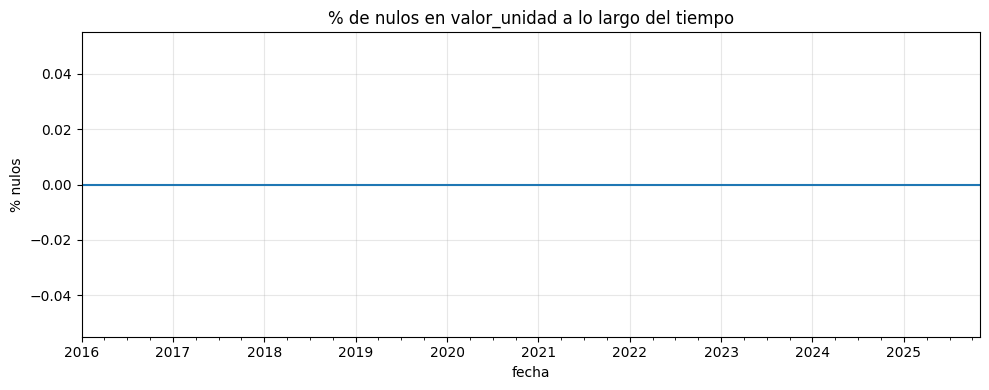

✓ Gráfica de nulos guardada en: /home/wolfang-sanchez/Documents/proyecto/data/graficas_comparativas/nulos_valor_unidad_tiempo.png


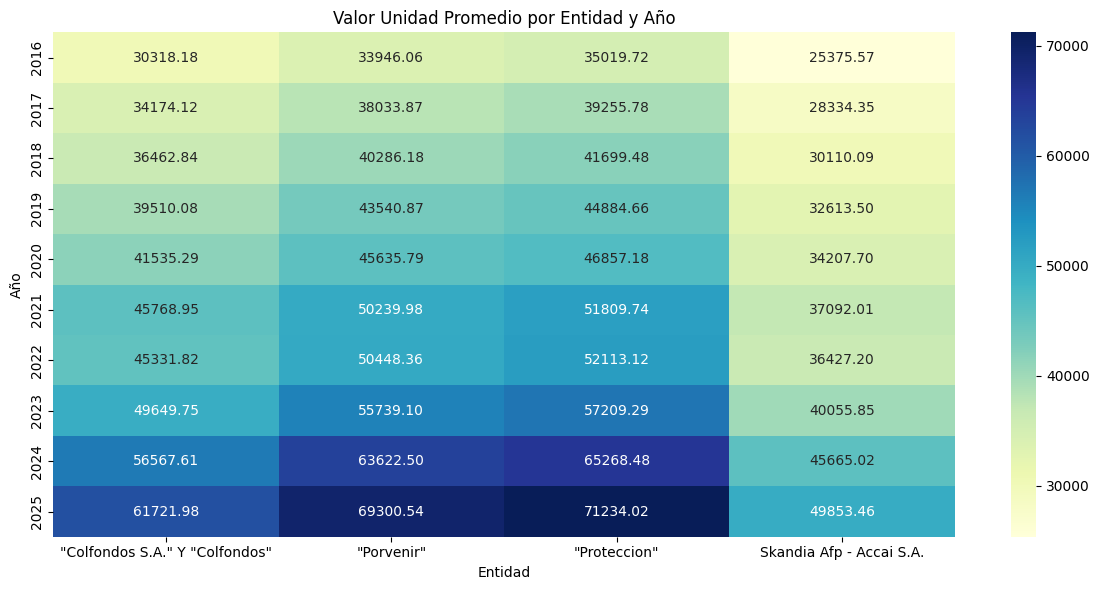

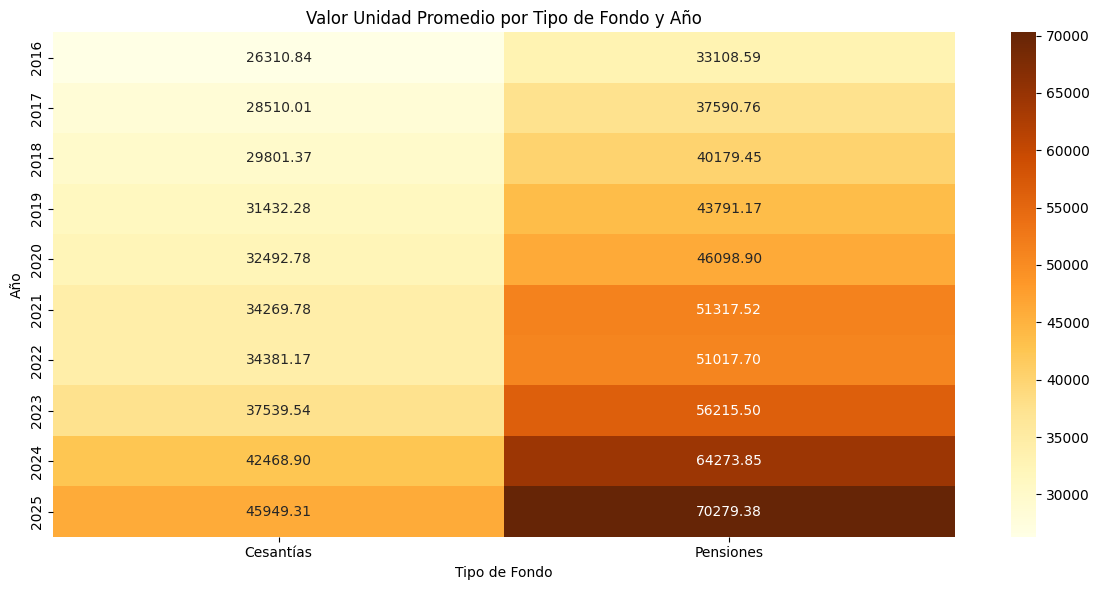

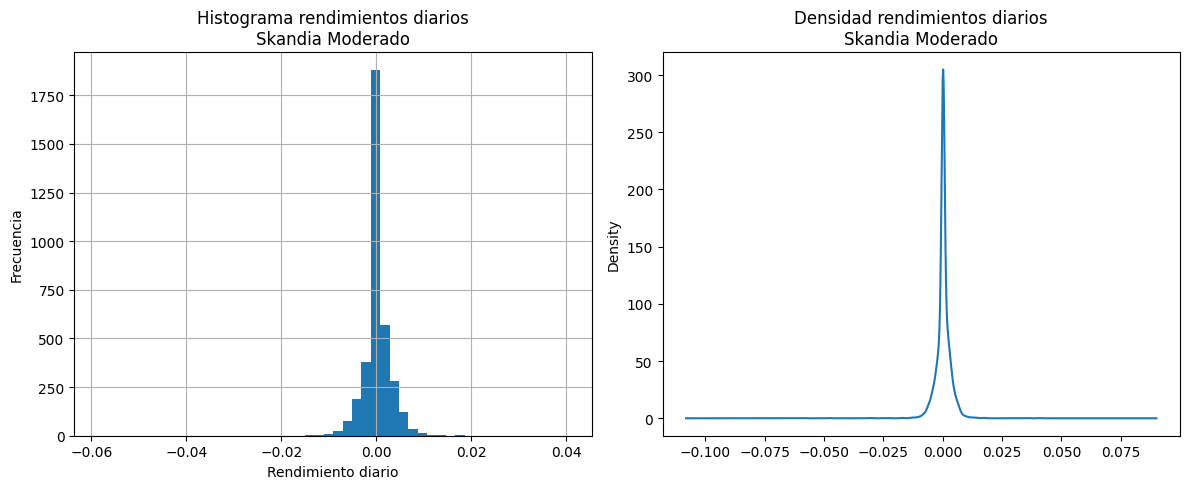

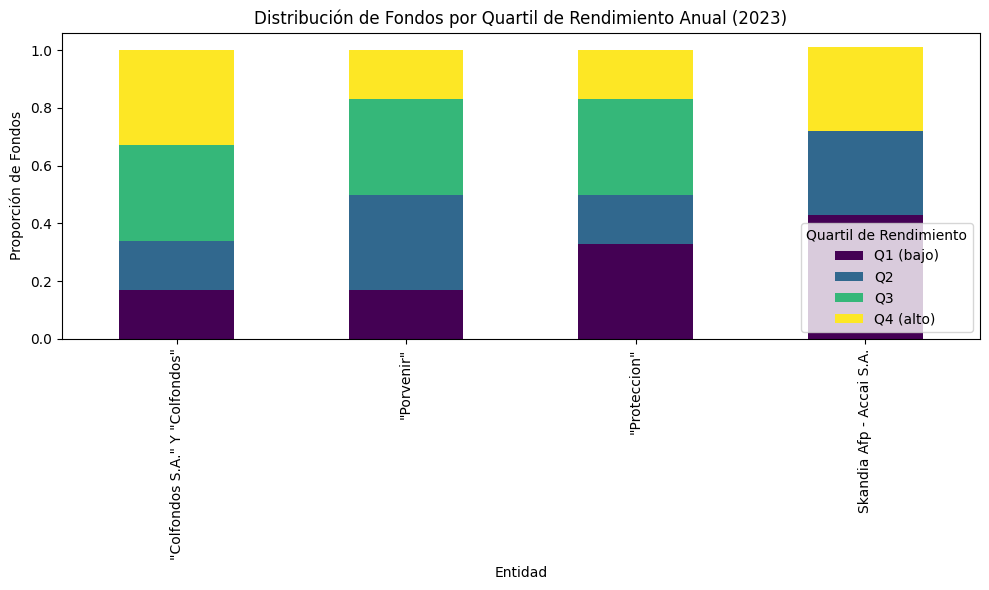

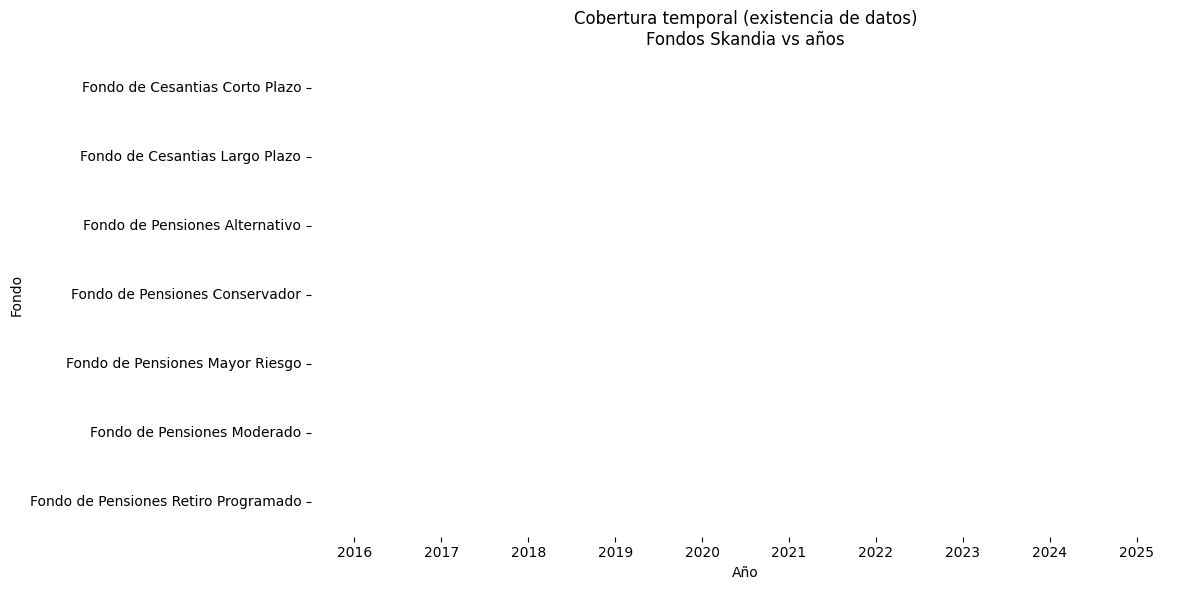

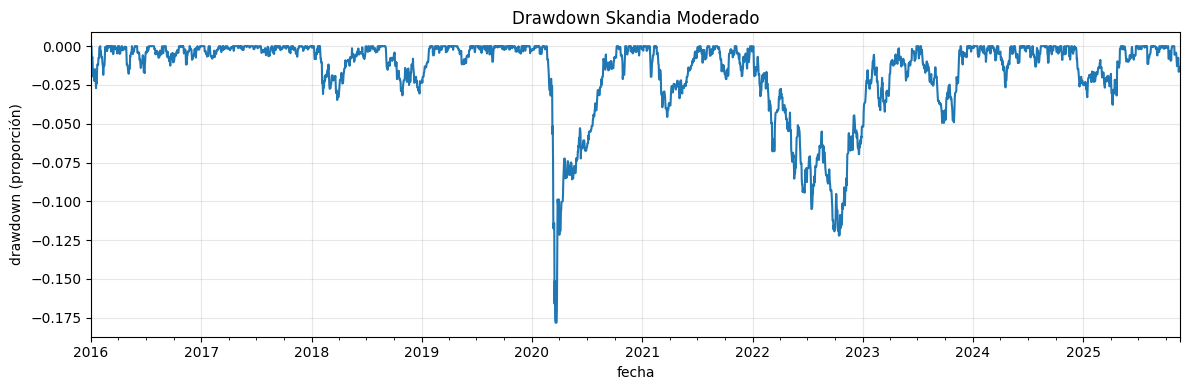

In [175]:

resumen_columnas = pd.DataFrame({
    "tipo": df.dtypes.astype(str),
    "n_null": df.isna().sum(),
    "%_null": df.isna().mean().mul(100).round(2),
    "n_unique": df.nunique()
})
resumen_columnas.to_csv(PROCESSED_DIR / "resumen_columnas.csv")
print("Vista previa del diccionario de variables:")
display(resumen_columnas.head())

nulls_por_mes = (
    df.set_index("fecha")
      .isna()
      .resample("M")
      .mean()
      .mul(100)
)
plt.figure(figsize=(10,4))
nulls_por_mes['valor_unidad'].plot()
plt.title("% de nulos en valor_unidad a lo largo del tiempo")
plt.ylabel("% nulos"); plt.grid(True, alpha=0.3); plt.tight_layout()
out_nulls = GRAFICAS_COMP_DIR / 'nulos_valor_unidad_tiempo.png'
plt.savefig(out_nulls, dpi=300, bbox_inches="tight")
plt.show()
plt.close()
print(f"✓ Gráfica de nulos guardada en: {out_nulls}")

tabla_entidad_anio = pd.pivot_table(
    df,
    values="valor_unidad",
    index="año",
    columns="nombre_entidad",
    aggfunc="mean"
)
tabla_entidad_anio.to_csv(PROCESSED_DIR / "tabla_entidad_anio_mean_valor_unidad.csv")
plt.figure(figsize=(12,6))
sns.heatmap(tabla_entidad_anio, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Valor Unidad Promedio por Entidad y Año")
plt.ylabel("Año"); plt.xlabel("Entidad"); plt.tight_layout()
out_heat_ent = GRAFICAS_COMP_DIR / 'heatmap_valor_unidad_entidad_anio.png'
plt.savefig(out_heat_ent, dpi=300, bbox_inches="tight")
plt.show()
plt.close()

tabla_tipo_anio = pd.pivot_table(
    df,
    values="valor_unidad",
    index="año",
    columns="tipo_fondo",
    aggfunc=["mean", "std"]
)
tabla_tipo_anio.to_csv(PROCESSED_DIR / "tabla_tipo_anio_mean_std.csv")
plt.figure(figsize=(12,6))
sns.heatmap(tabla_tipo_anio["mean"], annot=True, fmt=".2f", cmap="YlOrBr")
plt.title("Valor Unidad Promedio por Tipo de Fondo y Año")
plt.ylabel("Año"); plt.xlabel("Tipo de Fondo"); plt.tight_layout()
out_heat_tipo = GRAFICAS_COMP_DIR / 'heatmap_valor_unidad_tipo_anio.png'
plt.savefig(out_heat_tipo, dpi=300, bbox_inches="tight")
plt.show()
plt.close()

fondo = df_skandia_pensiones_moderado.set_index("fecha")["valor_unidad"].sort_index()
returns = fondo.pct_change().dropna()
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
returns.hist(bins=50)
plt.title("Histograma rendimientos diarios\nSkandia Moderado")
plt.xlabel("Rendimiento diario"); plt.ylabel("Frecuencia")
plt.subplot(1,2,2)
returns.plot(kind="density")
plt.title("Densidad rendimientos diarios\nSkandia Moderado")
plt.tight_layout()
out_ret = GRAFICAS_COMP_DIR / 'rendimientos_skandia_moderado.png'
plt.savefig(out_ret, dpi=300, bbox_inches="tight")
plt.show()
plt.close()

df_returns = (
    df.set_index("fecha")
      .groupby(["nombre_entidad", "nombre_fondo"])
      ["valor_unidad"]
      .resample("A-DEC")
      .last()
      .groupby(level=[0,1])
      .pct_change()
      .reset_index(name="rend_anual")
)
df_2023 = df_returns[df_returns["fecha"].dt.year == 2023].dropna(subset=["rend_anual"])
df_2023["quartil_rend"] = pd.qcut(df_2023["rend_anual"], 4, labels=["Q1 (bajo)", "Q2", "Q3", "Q4 (alto)"])
tabla_quartiles = pd.crosstab(df_2023["nombre_entidad"], df_2023["quartil_rend"], normalize="index").round(2)
tabla_quartiles.to_csv(PROCESSED_DIR / "entidad_por_quartil_rend_2023.csv")
plt.figure(figsize=(10,6))
tabla_quartiles.plot(kind="bar", stacked=True, colormap="viridis", ax=plt.gca())
plt.title("Distribución de Fondos por Quartil de Rendimiento Anual (2023)")
plt.xlabel("Entidad"); plt.ylabel("Proporción de Fondos"); plt.legend(title="Quartil de Rendimiento")
plt.tight_layout()
out_quart = GRAFICAS_COMP_DIR / 'entidad_por_quartil_rend_2023.png'
plt.savefig(out_quart, dpi=300, bbox_inches="tight")
plt.show()
plt.close()

df["anio"] = df["fecha"].dt.year
tabla_cobertura = (
    df.groupby(["nombre_entidad", "nombre_fondo", "anio"])
      .size()
      .unstack("anio")
      .fillna(0)
)
tabla_skandia_cob = tabla_cobertura.loc["Skandia Afp - Accai S.A."]
plt.figure(figsize=(12,6))
sns.heatmap((tabla_skandia_cob > 0).astype(int), cmap="Greys", cbar=False)
plt.title("Cobertura temporal (existencia de datos)\nFondos Skandia vs años")
plt.xlabel("Año"); plt.ylabel("Fondo"); plt.tight_layout()
out_cob = GRAFICAS_COMP_DIR / 'cobertura_fondos_skandia.png'
plt.savefig(out_cob, dpi=300, bbox_inches="tight")
plt.show()
plt.close()

cummax = fondo.cummax()
drawdown = (fondo - cummax) / cummax
plt.figure(figsize=(12,4))
drawdown.plot()
plt.title("Drawdown Skandia Moderado"); plt.ylabel("drawdown (proporción)")
plt.grid(True, alpha=0.3); plt.tight_layout()
out_dd = GRAFICAS_COMP_DIR / 'drawdown_skandia_moderado.png'
plt.savefig(out_dd, dpi=300, bbox_inches="tight")
plt.show()
plt.close()
